In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

per_process_gpu_memory_fraction: 0.333

In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4084, done.
remote: Counting objects: 100% (4084/4084), done.
remote: Compressing objects: 100% (3075/3075), done.
remote: Total 4084 (delta 1189), reused 2902 (delta 949), pack-reused 0
Receiving objects: 100% (4084/4084), 44.61 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (1189/1189), done.


In [4]:
  # Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [6]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2024-03-05 03:15:38.799448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 03:15:38.799501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 03:15:38.800745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 03:15:39.746586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Running tests under Python 3.10.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2024-03-05 03:15:42.269244: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting beca

In [7]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

## Exporting a Trained Inference Graph
Still to come for TF2 models, we will be updating this Colab notebook accordingly as the functionality is added.

In [8]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cp /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/training.zip /content

In [10]:
%cp /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/fine_tuned_model.zip /content

In [11]:
%cp /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/test_.zip /content


In [12]:
!unzip /content/training.zip -d /content
!unzip /content/fine_tuned_model.zip -d /content



Archive:  /content/training.zip
   creating: /content/content/training/
   creating: /content/content/training/train/
  inflating: /content/content/training/train/events.out.tfevents.1708678883.b71bddb958e5.3862.0.v2  
  inflating: /content/content/training/ckpt-3.data-00000-of-00001  
  inflating: /content/content/training/ckpt-5.index  
  inflating: /content/content/training/ckpt-3.index  
  inflating: /content/content/training/ckpt-2.data-00000-of-00001  
  inflating: /content/content/training/ckpt-4.index  
  inflating: /content/content/training/ckpt-6.data-00000-of-00001  
  inflating: /content/content/training/ckpt-4.data-00000-of-00001  
  inflating: /content/content/training/ckpt-5.data-00000-of-00001  
  inflating: /content/content/training/checkpoint  
  inflating: /content/content/training/ckpt-2.index  
  inflating: /content/content/training/ckpt-6.index  
  inflating: /content/content/training/ckpt-1.data-00000-of-00001  
  inflating: /content/content/training/ckpt-1.index

In [13]:
!unzip /content/test_.zip -d /content

Archive:  /content/test_.zip
   creating: /content/Data/
  inflating: /content/Data/01FWJD7JTS1E8YVXVSWZAFNVAA_jpeg_jpg.rf.1253fe66374565fa55aa9ff39f97562a.jpg  
  inflating: /content/Data/01FWJD7JTS1E8YVXVSWZAFNVAA_jpeg_jpg.rf.1253fe66374565fa55aa9ff39f97562a.xml  
  inflating: /content/Data/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.jpg  
  inflating: /content/Data/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.xml  
  inflating: /content/Data/35_jpg.rf.e32534be2e26d36d0f23c01b0aaee780.jpg  
  inflating: /content/Data/35_jpg.rf.e32534be2e26d36d0f23c01b0aaee780.xml  
  inflating: /content/Data/38_png.rf.09a44607aebc2043d29140d22c79b819.jpg  
  inflating: /content/Data/38_png.rf.09a44607aebc2043d29140d22c79b819.xml  
  inflating: /content/Data/ppe_0311_jpg.rf.4e27ff56c3222a9187c20a3a014fbcae.jpg  
  inflating: /content/Data/ppe_0311_jpg.rf.4e27ff56c3222a9187c20a3a014fbcae.xml  
  inflating: /content/Data/01FWJD7JQDGP196BREGG8EKRX9_jpeg_jpg.rf.74bd31101a8aa9887f47bf644df259ec.jpg  
  inflat

In [14]:
#see where our model saved weights
%ls '/content/content/training/'

checkpoint                  ckpt-2.index                ckpt-4.index                ckpt-6.index
ckpt-1.data-00000-of-00001  ckpt-3.data-00000-of-00001  ckpt-5.data-00000-of-00001  train/
ckpt-1.index                ckpt-3.index                ckpt-5.index
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001  ckpt-6.data-00000-of-00001


In [15]:
pipeline_file = '/content/content/fine_tuned_model/pipeline.config'
model_dir = '/content/content/training/'

In [16]:
  #run conversion script
import re
import numpy as np

output_directory = '/content/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/content/training/
2024-03-05 03:23:03.164046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 03:23:03.164096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 03:23:03.165458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 03:23:04.113804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-05 03:23:06.615977: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0

In [17]:
import pathlib

filenames = list(pathlib.Path('/content/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('/content/content/training/ckpt-1.index'), PosixPath('/content/content/training/ckpt-2.index'), PosixPath('/content/content/training/ckpt-3.index'), PosixPath('/content/content/training/ckpt-4.index'), PosixPath('/content/content/training/ckpt-5.index'), PosixPath('/content/content/training/ckpt-6.index')]


In [18]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map_path = '/content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/safety_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Image inference

In [ ]:
#test image
#it takes a little longer on the first run and then runs at normal speed.
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

TEST_IMAGE_PATHS = glob.glob('/content/test/*')
# image_path = random.choice(TEST_IMAGE_PATHS)
images = os.listdir('/content/test_')
print(len(images))
isExist = os.path.exists('/content/raw_test_image_output')
if not isExist:
  os.mkdir('/content/raw_test_image_output')
for img in images:
  image_path = '/content/test_/'+img
  try:
    image_np = load_image_into_numpy_array(image_path)
    print('image shape : ',image_np.shape)
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.5,
          agnostic_mode=False,
    )

    plt.figure(figsize=(12,16))
    plt.imshow(image_np_with_detections)
    plt.show()
    save_path = f'/content/raw_test_image_output/{img[:14]}'
    # plt.savefig(save_path)
    print(save_path)
    plt.savefig(f'/content/raw_test_image_output/{img}')
  except Exception as inst:
    print(inst)
  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)



In [61]:
import shutil
shutil.rmtree('/content/text_data')
text_paths = ['/content/text_data','/content/text_data/gt','/content/text_data/pred']
for text_path in text_paths:
  isExist = os.path.exists(text_path)
  print(text_path+' isExist')
  if not isExist:
    os.mkdir(text_path)
    print(text_path+' created')

/content/text_data isExist
/content/text_data created
/content/text_data/gt isExist
/content/text_data/gt created
/content/text_data/pred isExist
/content/text_data/pred created


In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Image as imgImage
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def parse_xml(xml_path,filename):
    f = open(f"/content/text_data/gt/{filename[:-4]}.txt", "w")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('.//object'):
        name = obj.find('name').text
        box = obj.find('bndbox')
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        line = f"{name} {ymin} {xmin} {ymax} {xmax}"
        f.write(line)
        # Check if it's not the last object, then add a newline
        if obj is not root.findall('.//object')[-1]:
            f.write('\n')

    f.close()


# parse_xml('/content/-1680-_png_jpg.rf.b6d2816eaa40e20b2377d0fbf036bad4.xml','hi.jpg')
def parse_detection(detection_classes, detection_scores, pred_bbox, filename):
    f = open(f"/content/text_data/pred/{filename[:-4]}.txt", "w")

    for i, (class_name, score, box) in enumerate(zip(detection_classes, detection_scores, pred_bbox)):
        formatted_output = f"{class_name} {score:.7f} {' '.join(map(str, box))}"
        f.write(formatted_output)

        # Check if it's not the last object, then add a newline
        if i < len(pred_bbox) - 1:
            f.write('\n')

    f.close()


In [63]:
f = open("/content/text_data/pred/00107_jpg.rf.a698618bf501c40e53871f6a4feb5eb5", "r")
print(f.read())


FileNotFoundError: [Errno 2] No such file or directory: '/content/text_data/pred/00107_jpg.rf.a698618bf501c40e53871f6a4feb5eb5'

In [64]:
# testing github code
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt


def convert_normalized_coordinates_to_image_coordinates(box, image_shape):
    y_min, x_min, y_max, x_max = box
    height, width = image_shape

    # Convert normalized coordinates to image coordinates
    y_min = int(y_min * height)
    x_min = int(x_min * width)
    y_max = int(y_max * height)
    x_max = int(x_max * width)

    return [y_min, x_min, y_max, x_max]


image_path = '/content/test_/' + img
xml_path = '/content/test_/' + img.replace('.jpg', '.xml')  # Replace with your ground truth annotations path



TEST_IMAGE_PATHS = glob.glob('/content/test/*')
# image_path = random.choice(TEST_IMAGE_PATHS)
images = os.listdir('/content/test_')
print(len(images))
isExist = os.path.exists('/content/raw_test_image_output')
if not isExist:
  os.mkdir('/content/raw_test_image_output')
for img in images:
  image_path = '/content/test_/'+img
  try:
    if image_path[-4:]=='.jpg':
      xml_path = '/content/test_/' + img.replace('.jpg', '.xml')
      parse_xml(xml_path, img)
      image_np = load_image_into_numpy_array(image_path)
      print('image shape : ',image_np.shape)
      input_tensor = tf.convert_to_tensor(
          np.expand_dims(image_np, 0), dtype=tf.float32)
      detections, predictions_dict, shapes = detect_fn(input_tensor)

      label_id_offset = 1

      # text file writing
      detection_scores = detections['detection_scores'][0].numpy()
      detection_classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)

      pred_bbox = []
      for i in range(len(detections['detection_boxes'][0].numpy())):
        detection_bbox = detections['detection_boxes'][0][i].numpy()*512
        pred_bbox.append(detection_bbox.astype(int))
      pred_bbox = np.array(pred_bbox)
      # print('pred_bbox : ',pred_bbox)
      # print('detection_scores : ',detection_scores)
      # print('detection_classes : ',detection_classes)

      my_list = ['Goggle','Helmet','Person','Shoe','Vest']
      detection_classes = [my_list[i-1] for i in detection_classes]
      parse_detection(detection_classes,detection_scores,pred_bbox,img)






      # label_id_offset = 1
      image_np_with_detections = image_np.copy()
      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.5,
            agnostic_mode=False,
      )

      plt.figure(figsize=(12,16))
      plt.imshow(image_np_with_detections)
      plt.show()
      save_path = f'/content/raw_test_image_output/{img[:14]}'
      # plt.savefig(save_path)
      print(save_path)
      plt.savefig(f'/content/raw_test_image_output/{img}')
  except Exception as inst:
    print(inst)

100
image shape :  (512, 512, 3)
/content/raw_test_image_output/1_webp.rf.24a4
image shape :  (512, 512, 3)
/content/raw_test_image_output/3_jpg.rf.c7cd1
image shape :  (512, 512, 3)
/content/raw_test_image_output/27_jpg.rf.edee
image shape :  (512, 512, 3)
/content/raw_test_image_output/36_jpg.rf.5c34
image shape :  (512, 512, 3)
/content/raw_test_image_output/10_webp.rf.248
image shape :  (512, 512, 3)
/content/raw_test_image_output/8_jpg.rf.b92b3
image shape :  (512, 512, 3)
/content/raw_test_image_output/33_jpeg.rf.6de
image shape :  (512, 512, 3)
/content/raw_test_image_output/23_jpg.rf.4787
image shape :  (512, 512, 3)
/content/raw_test_image_output/2_jpg.rf.896bc
image shape :  (512, 512, 3)
/content/raw_test_image_output/22_jpg.rf.0ca0
image shape :  (512, 512, 3)
/content/raw_test_image_output/19_jpg.rf.aa4a
image shape :  (512, 512, 3)
/content/raw_test_image_output/youtube-631_jp
image shape :  (512, 512, 3)
/content/raw_test_image_output/30_jpg.rf.a2e0
image shape :  (512, 

In [65]:
!zip -r /content/text_data.zip /content/text_data/
# %cp /content/raw_test_image_output.zip /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/


  adding: content/text_data/ (stored 0%)
  adding: content/text_data/gt/ (stored 0%)
  adding: content/text_data/gt/ppe_0307_jpg.rf.a1effd568beac41ea93ba021ff17938a.txt (deflated 18%)
  adding: content/text_data/gt/18_jpg.rf.a9409c66f47820bdddf0ad49a804dde6.txt (stored 0%)
  adding: content/text_data/gt/99f98ce9-images_25_jpeg_jpg.rf.5e1c4632ee019044d64a939cb369db98.txt (deflated 2%)
  adding: content/text_data/gt/15_jpg.rf.b2458f4fa77072fda0c1f8eb231b4b91.txt (deflated 2%)
  adding: content/text_data/gt/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.txt (stored 0%)
  adding: content/text_data/gt/2ff24763-images_2_1_jpeg_jpg.rf.988f351bb60fdb53da5eb3d0d2ad84fd.txt (stored 0%)
  adding: content/text_data/gt/4_webp.rf.bbb3829e7a29949f802c5af5db00b754.txt (deflated 51%)
  adding: content/text_data/gt/30_jpg.rf.a2e0a5b8d5e56ae0327191855828985d.txt (deflated 36%)
  adding: content/text_data/gt/29_jpg.rf.fe1383b312c32f66a4784bcca6373b87.txt (deflated 6%)
  adding: content/text_data/gt/imagem18_j

## Confusion matrix

In [ ]:
def convert_normalized_coordinates_to_image_coordinates(box, image_shape):
    """
    Convert normalized box coordinates to image coordinates.

    Parameters:
        box (list or numpy array): Normalized box coordinates in the format [y_min, x_min, y_max, x_max].
        image_shape (tuple): Shape of the original image in the format (height, width).

    Returns:
        list: Box coordinates in the format [y_min, x_min, y_max, x_max] in image coordinates.
    """
    y_min, x_min, y_max, x_max = box
    height, width = image_shape

    # Convert normalized coordinates to image coordinates
    y_min = int(y_min * height)
    x_min = int(x_min * width)
    y_max = int(y_max * height)
    x_max = int(x_max * width)

    return [y_min, x_min, y_max, x_max]

def calculate_iou(box1, box2):

   x1, y1, w1, h1 = box1

   x2, y2, w2, h2 = box2

   # Determine coordinates of intersection rectangle

   x_left = max(x1, x2)

   y_top = max(y1, y2)

   x_right = min(x1 + w1, x2 + w2)

   y_bottom = min(y1 + h1, y2 + h2)

   if x_right < x_left or y_bottom < y_top:

       return 0.0

   # Calculate intersection area

   intersection_area = (x_right - x_left) * (y_bottom - y_top)

   # Calculate areas of both bounding boxes

   box1_area = w1 * h1

   box2_area = w2 * h2

   # Calculate union area

   union_area = box1_area + box2_area - intersection_area

   # Calculate IoU

   iou = intersection_area / union_area

   return iou

# Calculate Precision and Recall

def calculate_precision_recall(gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores, iou_threshold=0.5):

   tp = 0  # True Positives

   fp = 0  # False Positives

   total_gt = len(gt_boxes)

   for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):

       max_iou = 0

       for gt_box, gt_label in zip(gt_boxes, gt_labels):
          #  print(gt_box, gt_label)
           iou = calculate_iou(pred_box, gt_box)

           if iou > iou_threshold:
               max_iou = iou

               max_gt_label = gt_label
       if max_iou >= iou_threshold and max_gt_label['name'] == pred_label: #

           tp += 1

       else:

           fp += 1
   print('tp : ',tp)
   print('fp : ',fp)
   precision = tp / (tp + fp) if tp + fp > 0 else 0

   recall = tp / total_gt


   return precision, recall

In [ ]:
# from IPython.display import Image as imgImage
# images = os.listdir('/content/raw_test_image_output')
# for img in images:
#     image_path = '/content/raw_test_image_output/' + img
#     xml_path = '/content/raw_test_image_output/' + img.replace('.jpg', '.xml')  # Replace with your ground truth annotations path

#     # try:
#     if image_path[-4:]=='.jpg':
#       print('imok')
#       pil_img = imgImage(filename=image_path)
#       display(pil_img)

100
image_path :  /content/test_/4_webp.rf.bbb3829e7a29949f802c5af5db00b754.jpg


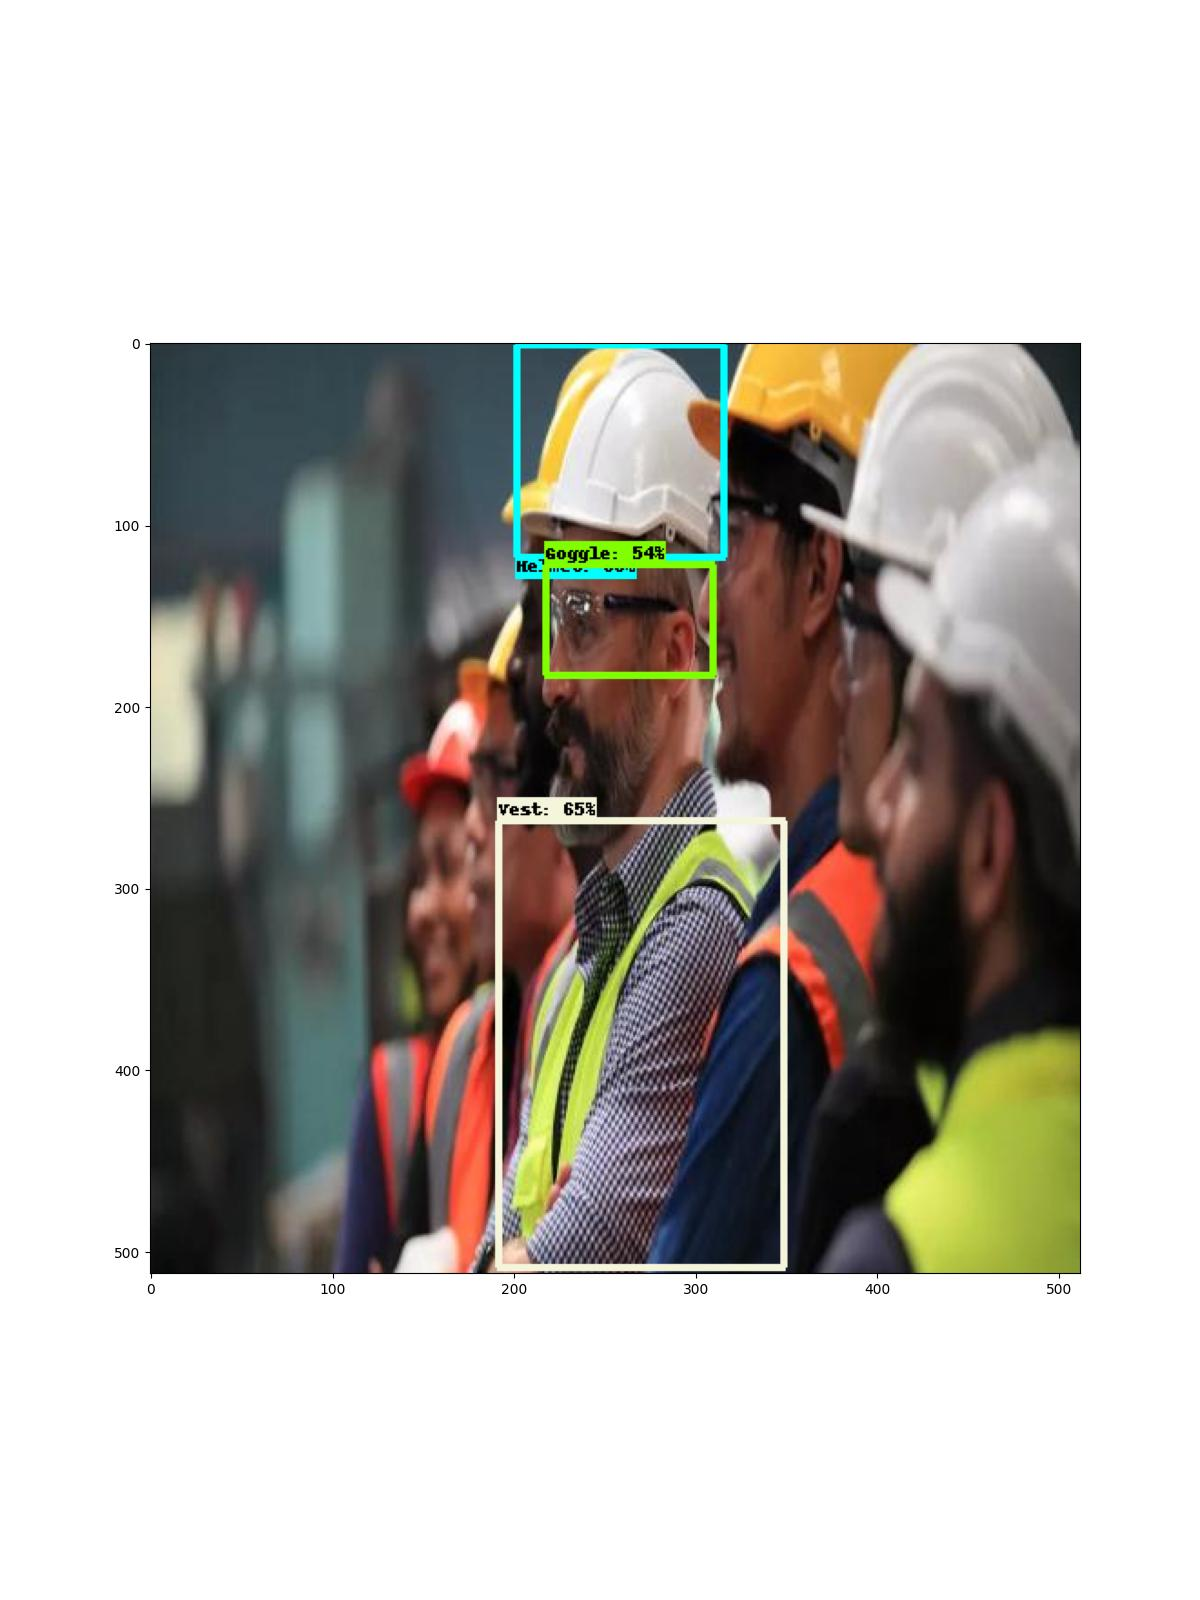

tp :  14
fp :  2
Precision: 0.875
Recall: 0.875
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Vest']
Confusion Matrix:
[[3 1 0 0 0]
 [0 4 1 0 0]
 [0 0 6 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/4_webp.rf.bbb3
image_path :  /content/test_/34_jpg.rf.d7b9c8d25c2c9e83d003263f62265c3f.jpg


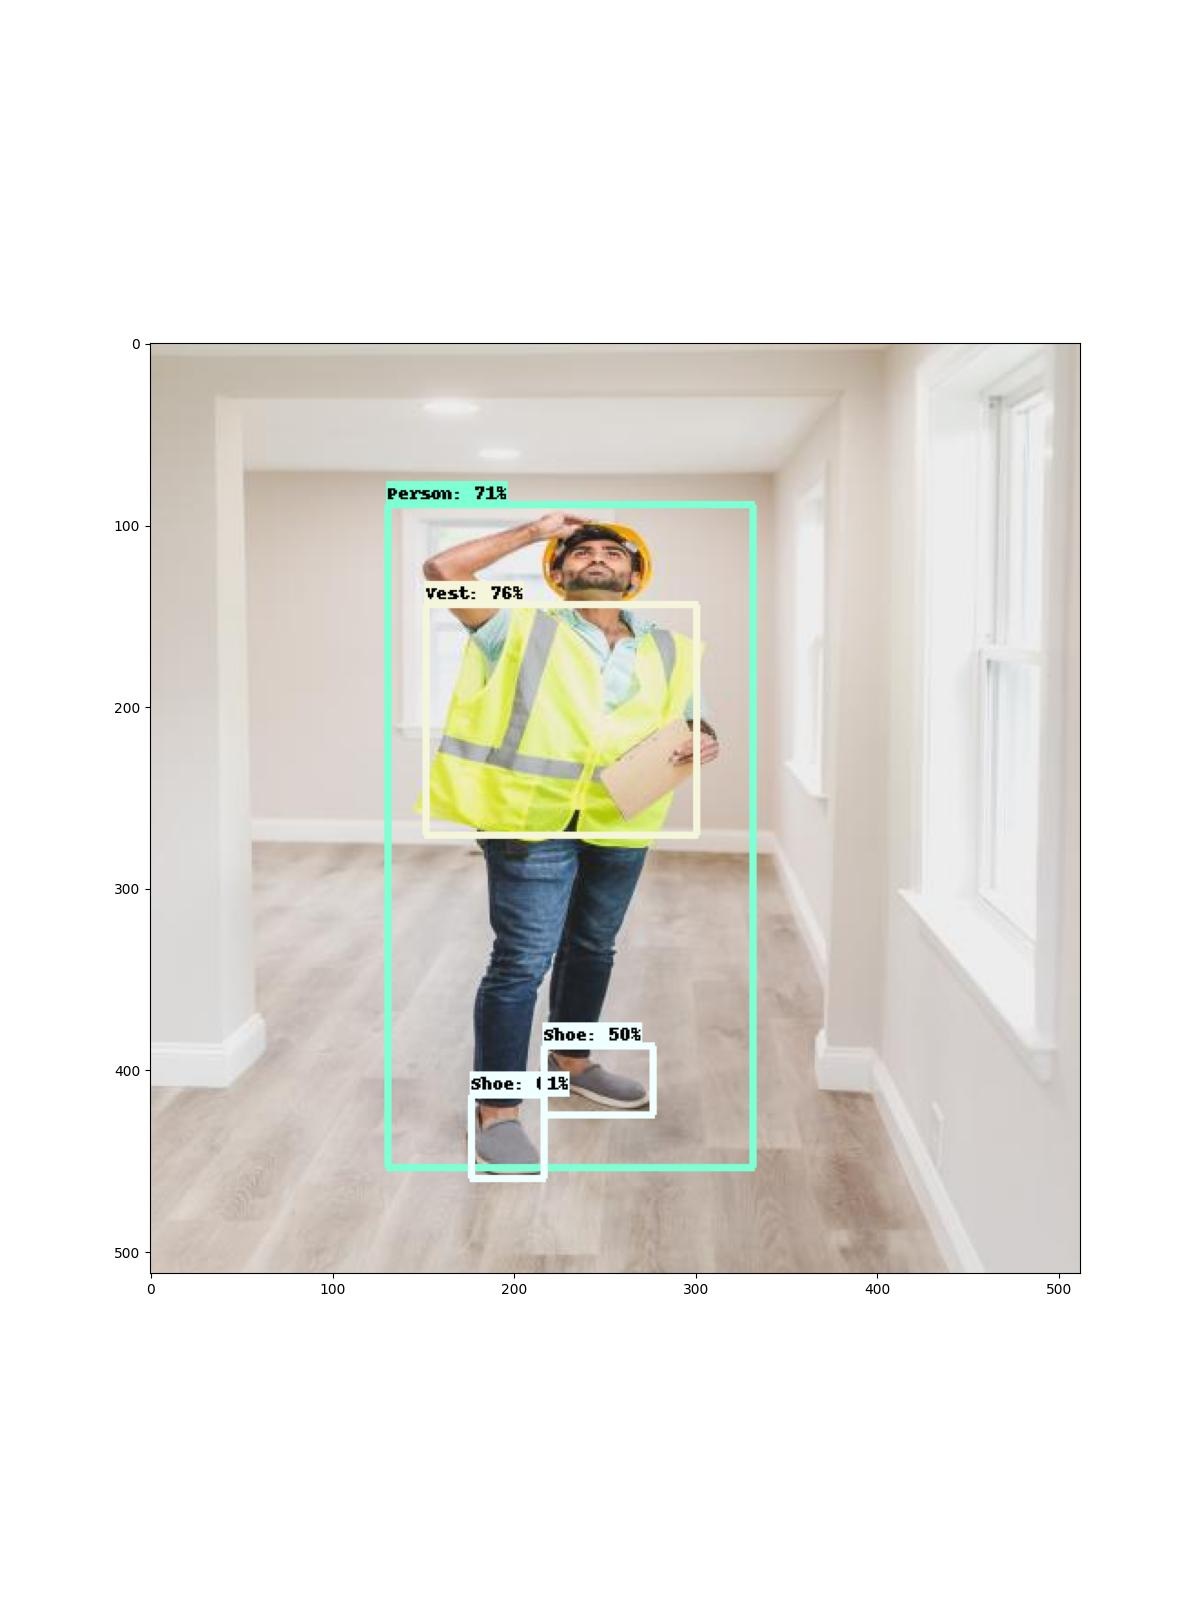

tp :  3
fp :  2
Precision: 0.6
Recall: 0.6
ground_truth_annotations_i :  ['Helmet', 'Person', 'Shoe', 'Shoe', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Person', 'Shoe', 'Shoe']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/34_jpg.rf.d7b9
image_path :  /content/test_/16_jpg.rf.3612742c5d30c5e891a49eb988d3299a.jpg


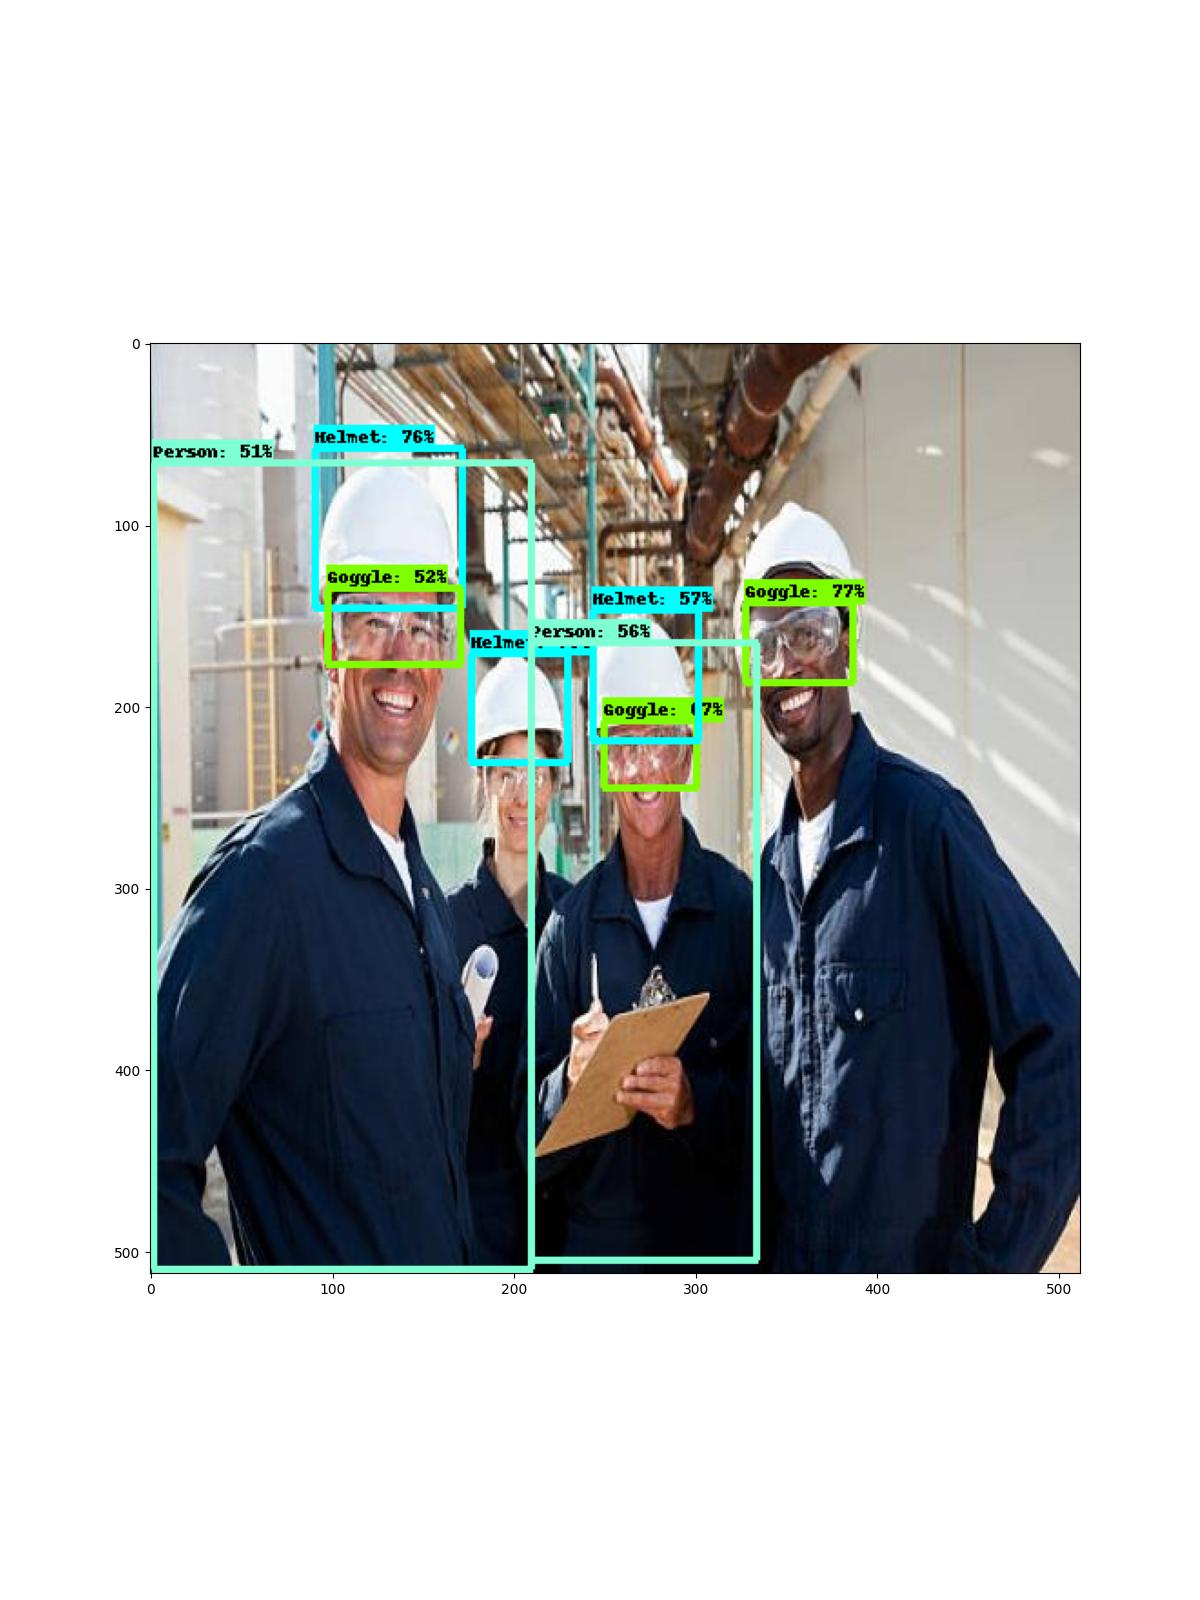

tp :  4
fp :  8
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Shoe', 'Shoe']
Confusion Matrix:
[[3 1 0 0 0]
 [0 1 3 0 0]
 [0 0 2 2 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/16_jpg.rf.3612
image_path :  /content/test_/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.jpg


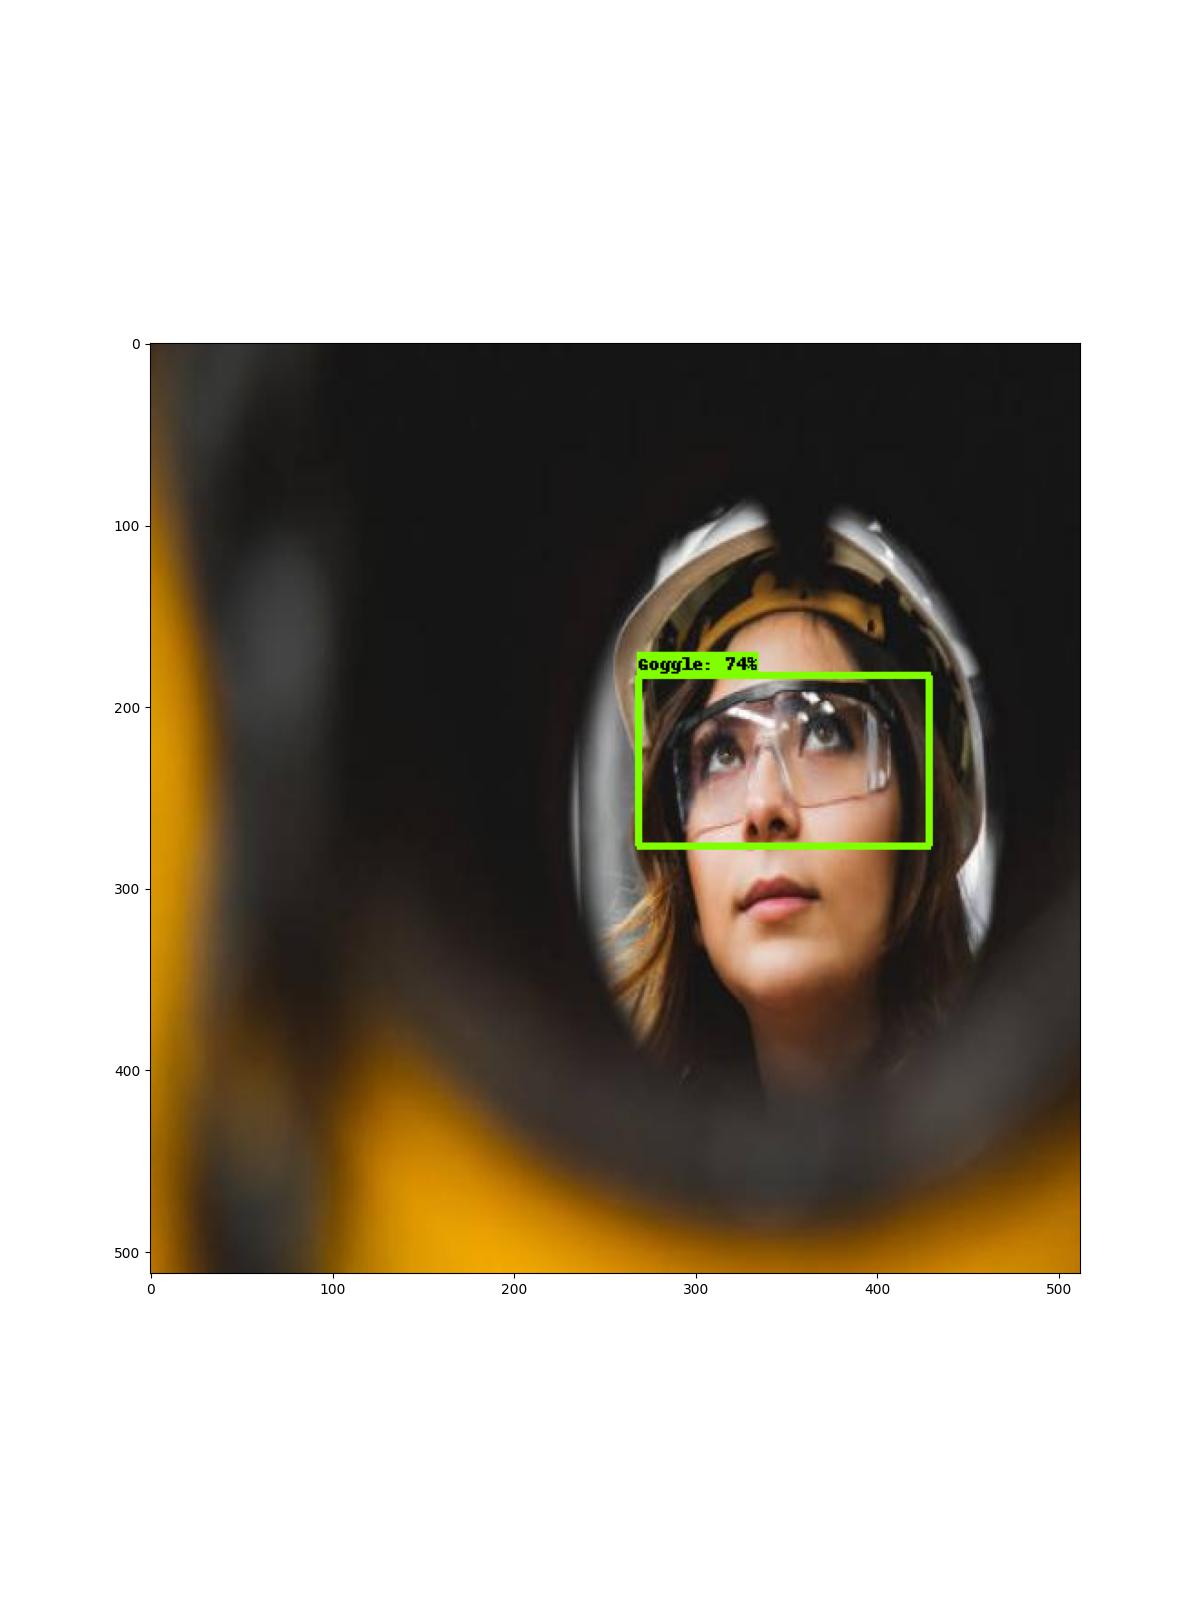

tp :  0
fp :  2
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Goggle', 'Person']
predicted_labels :  ['Goggle', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/21_jpg.rf.7110
image_path :  /content/test_/01FWJD7JTS1E8YVXVSWZAFNVAA_jpeg_jpg.rf.1253fe66374565fa55aa9ff39f97562a.jpg


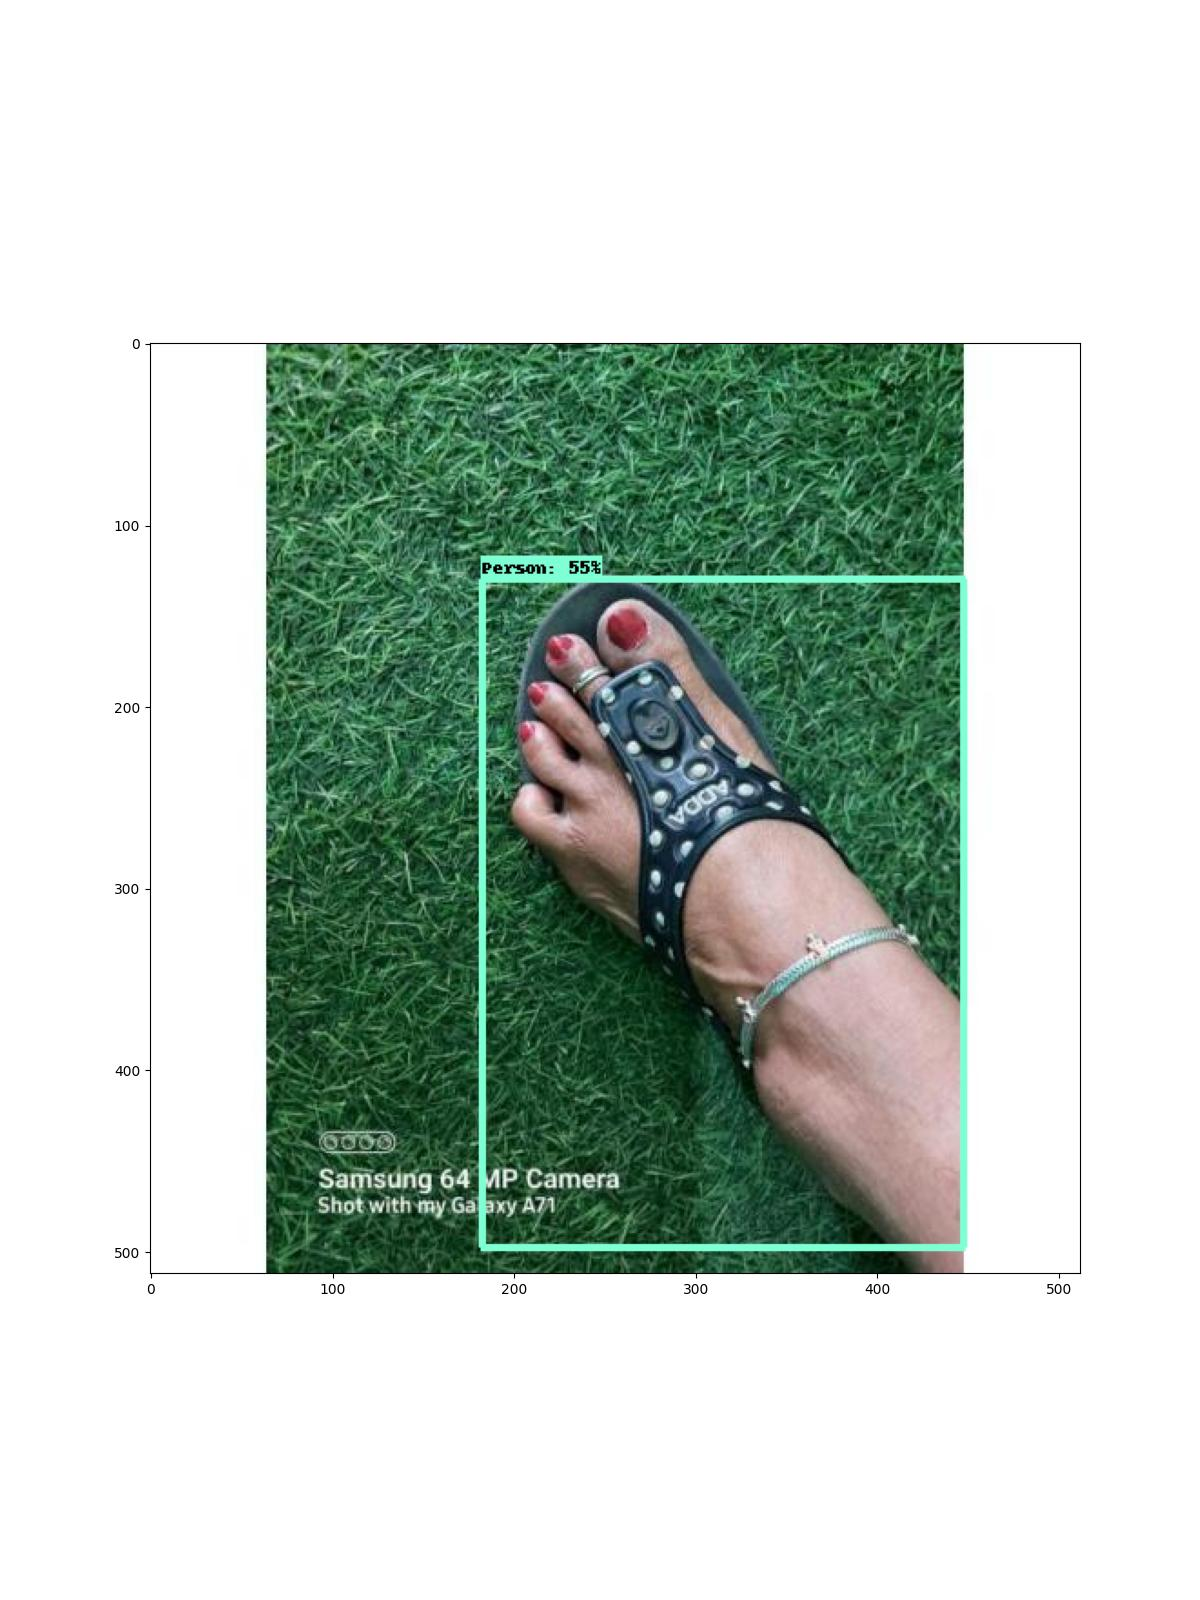

tp :  0
fp :  1
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Shoe']
predicted_labels :  ['Goggle']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/01FWJD7JTS1E8Y
image_path :  /content/test_/00107_jpg.rf.a698618bf501c40e53871f6a4feb5eb5.jpg


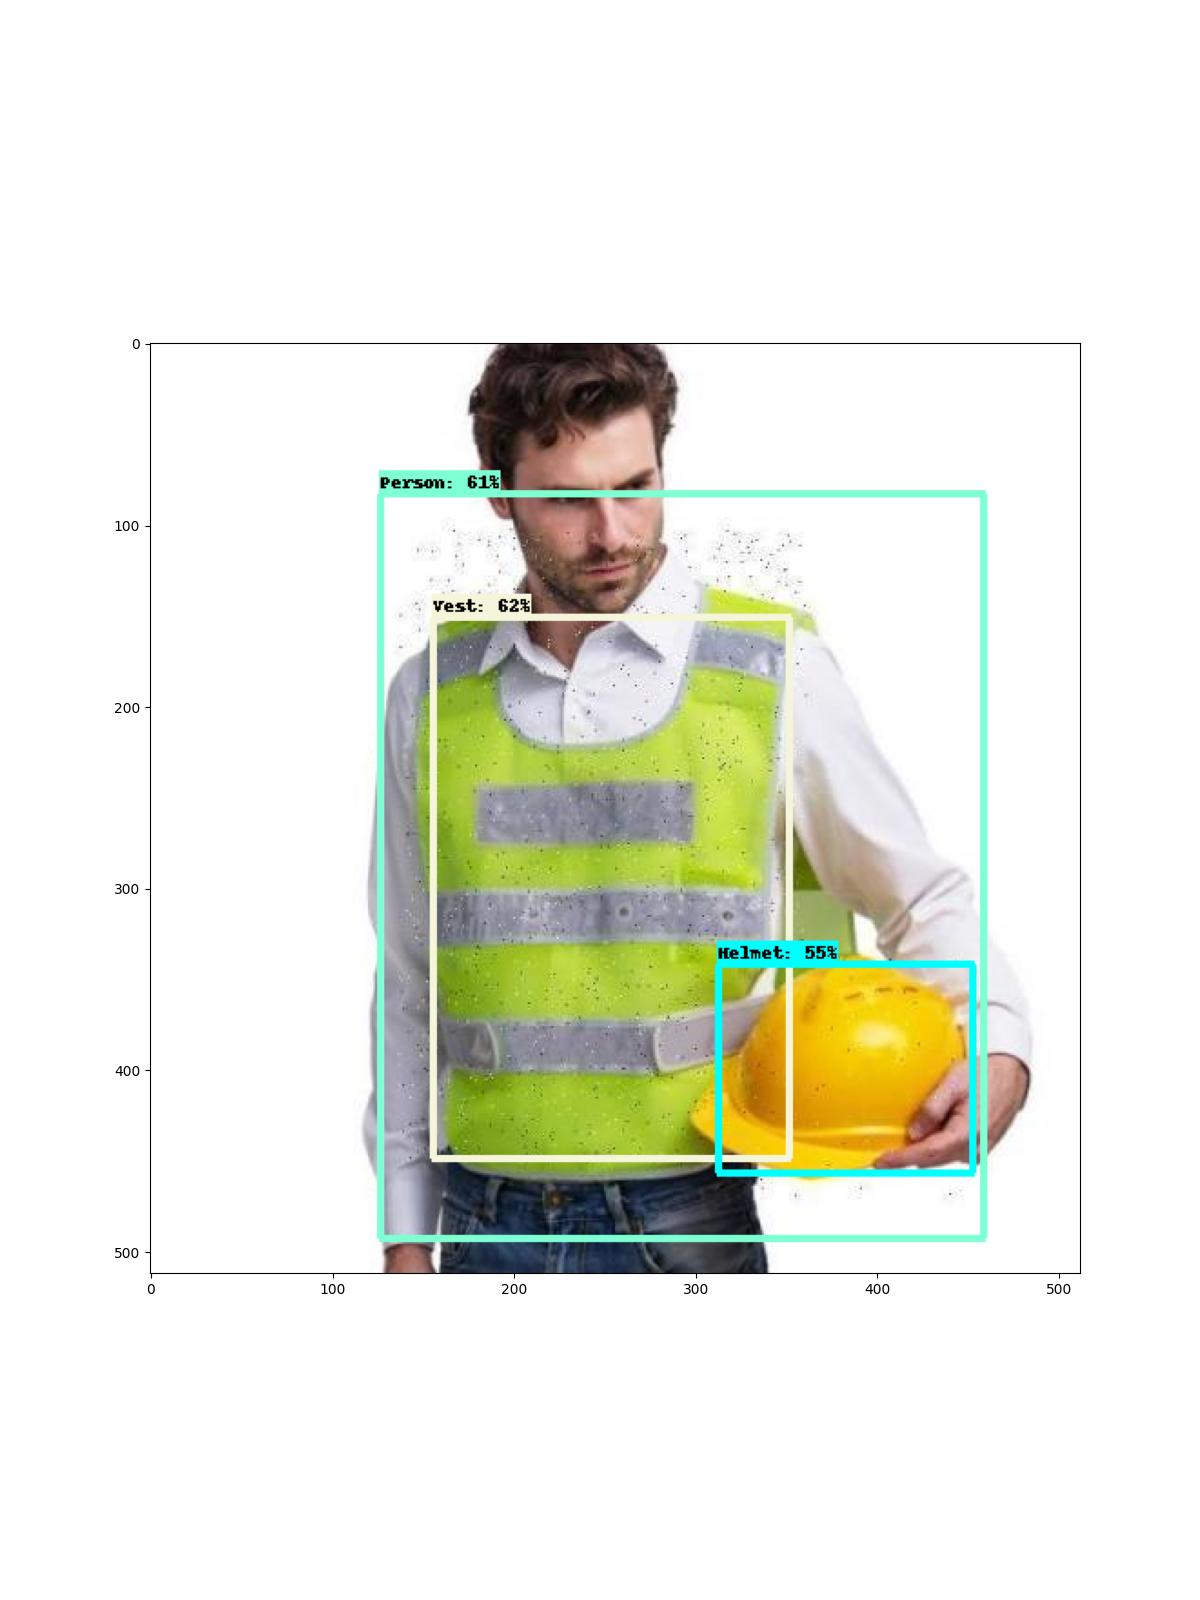

tp :  1
fp :  2
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/00107_jpg.rf.a
image_path :  /content/test_/27_jpg.rf.edee0b2b52736eb064ab71d75d264a89.jpg


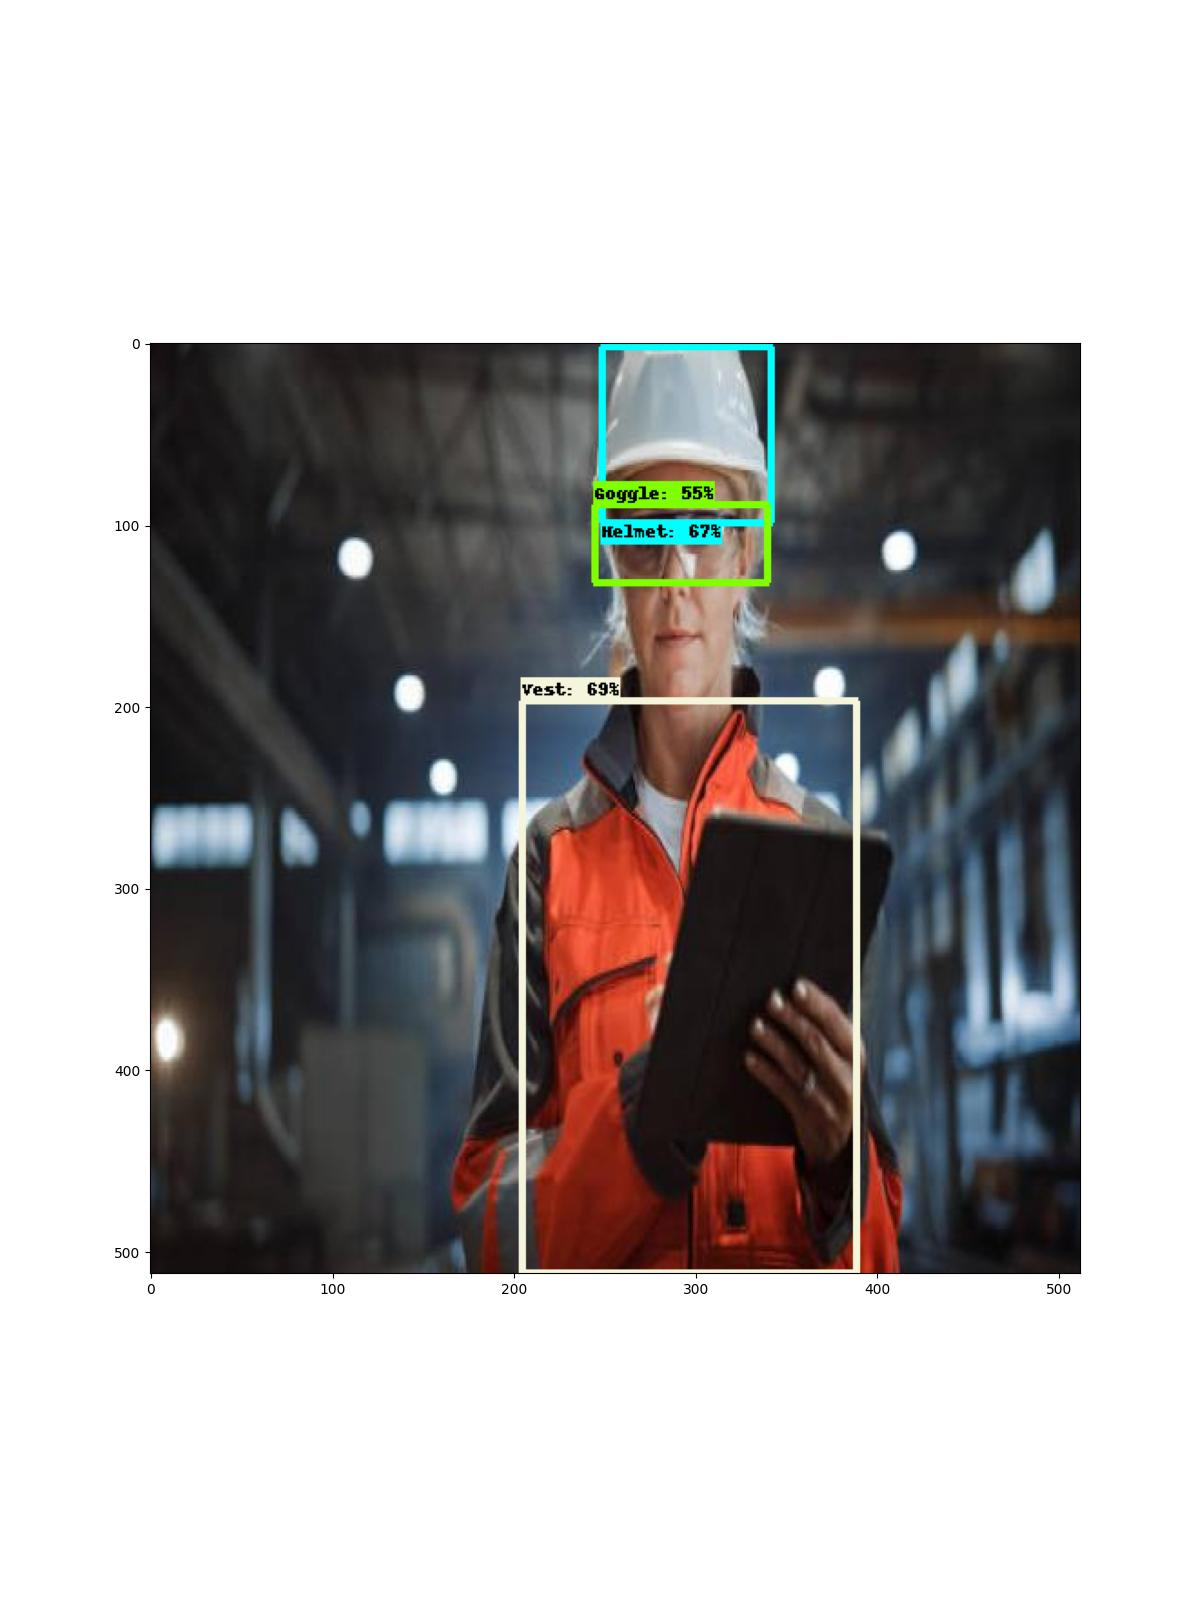

tp :  1
fp :  3
Precision: 0.25
Recall: 0.25
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Shoe', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/27_jpg.rf.edee
image_path :  /content/test_/01FWJD7JQDGP196BREGG8EKRX9_jpeg_jpg.rf.74bd31101a8aa9887f47bf644df259ec.jpg


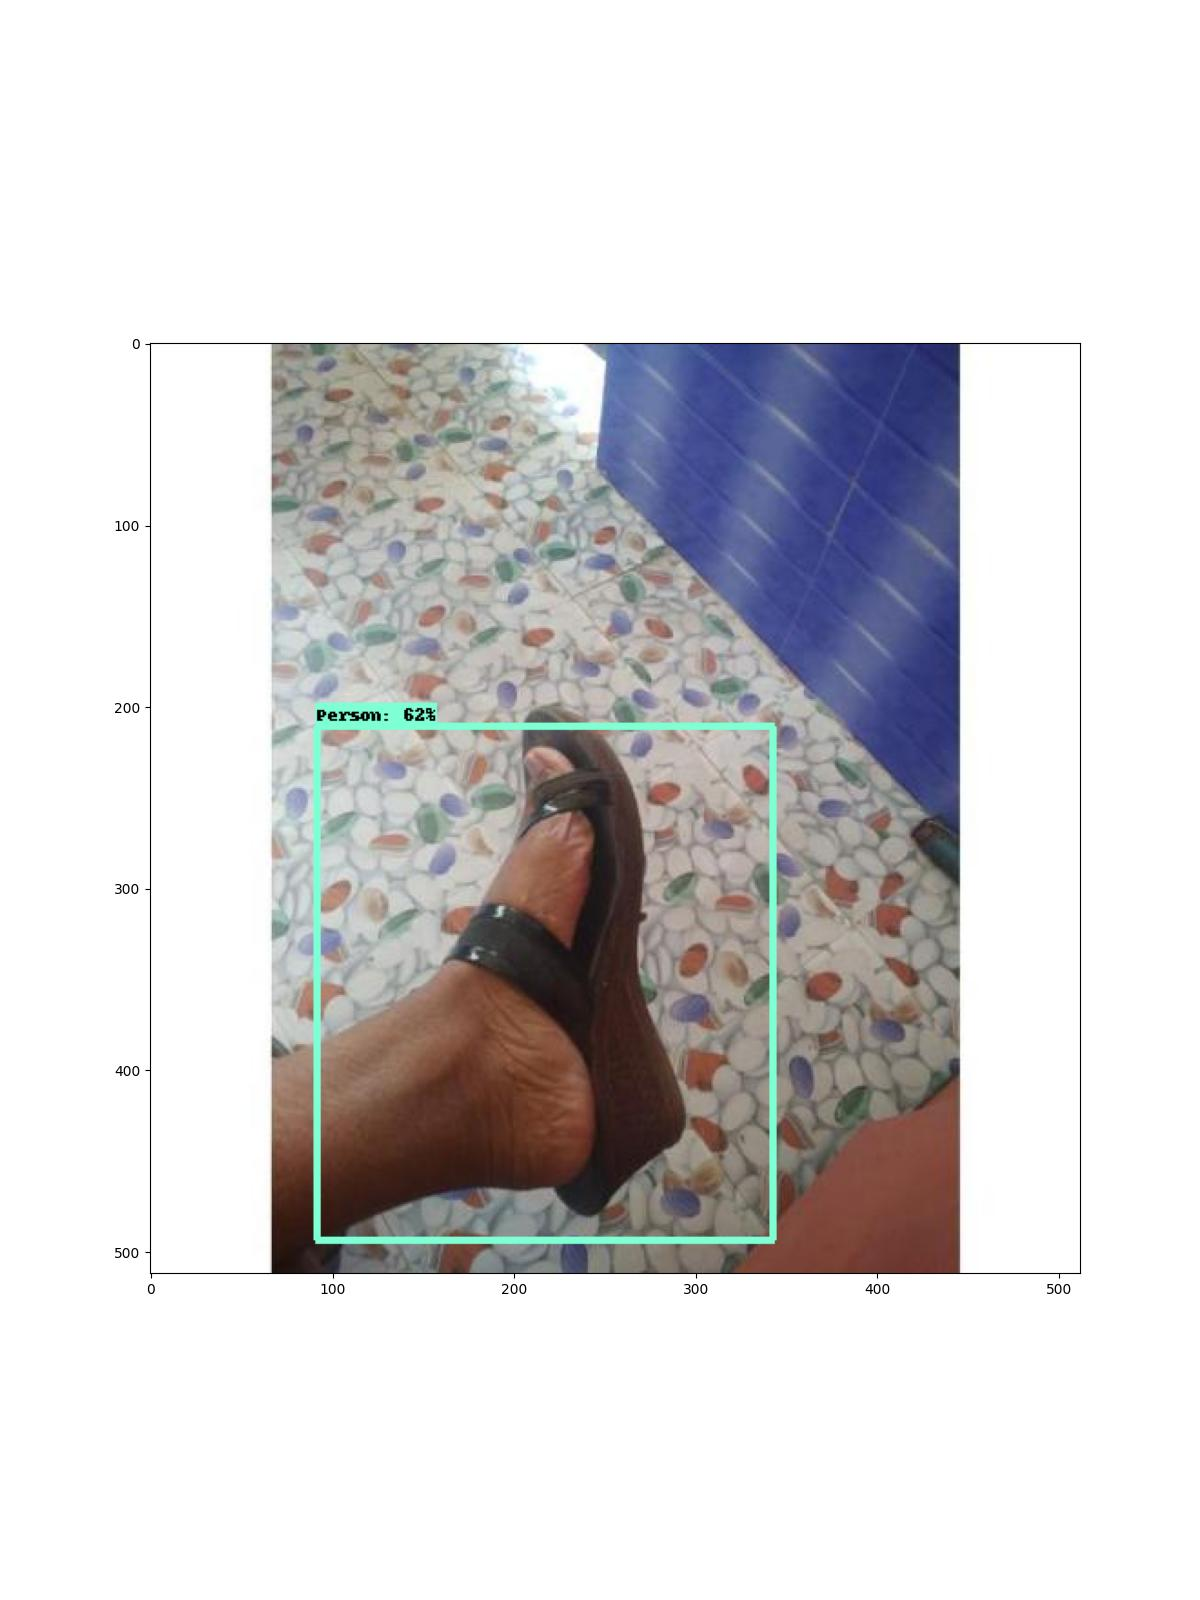

tp :  1
fp :  0
Precision: 1.0
Recall: 1.0
ground_truth_annotations_i :  ['Shoe']
predicted_labels :  ['Shoe']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/01FWJD7JQDGP19
image_path :  /content/test_/15_jpg.rf.b2458f4fa77072fda0c1f8eb231b4b91.jpg


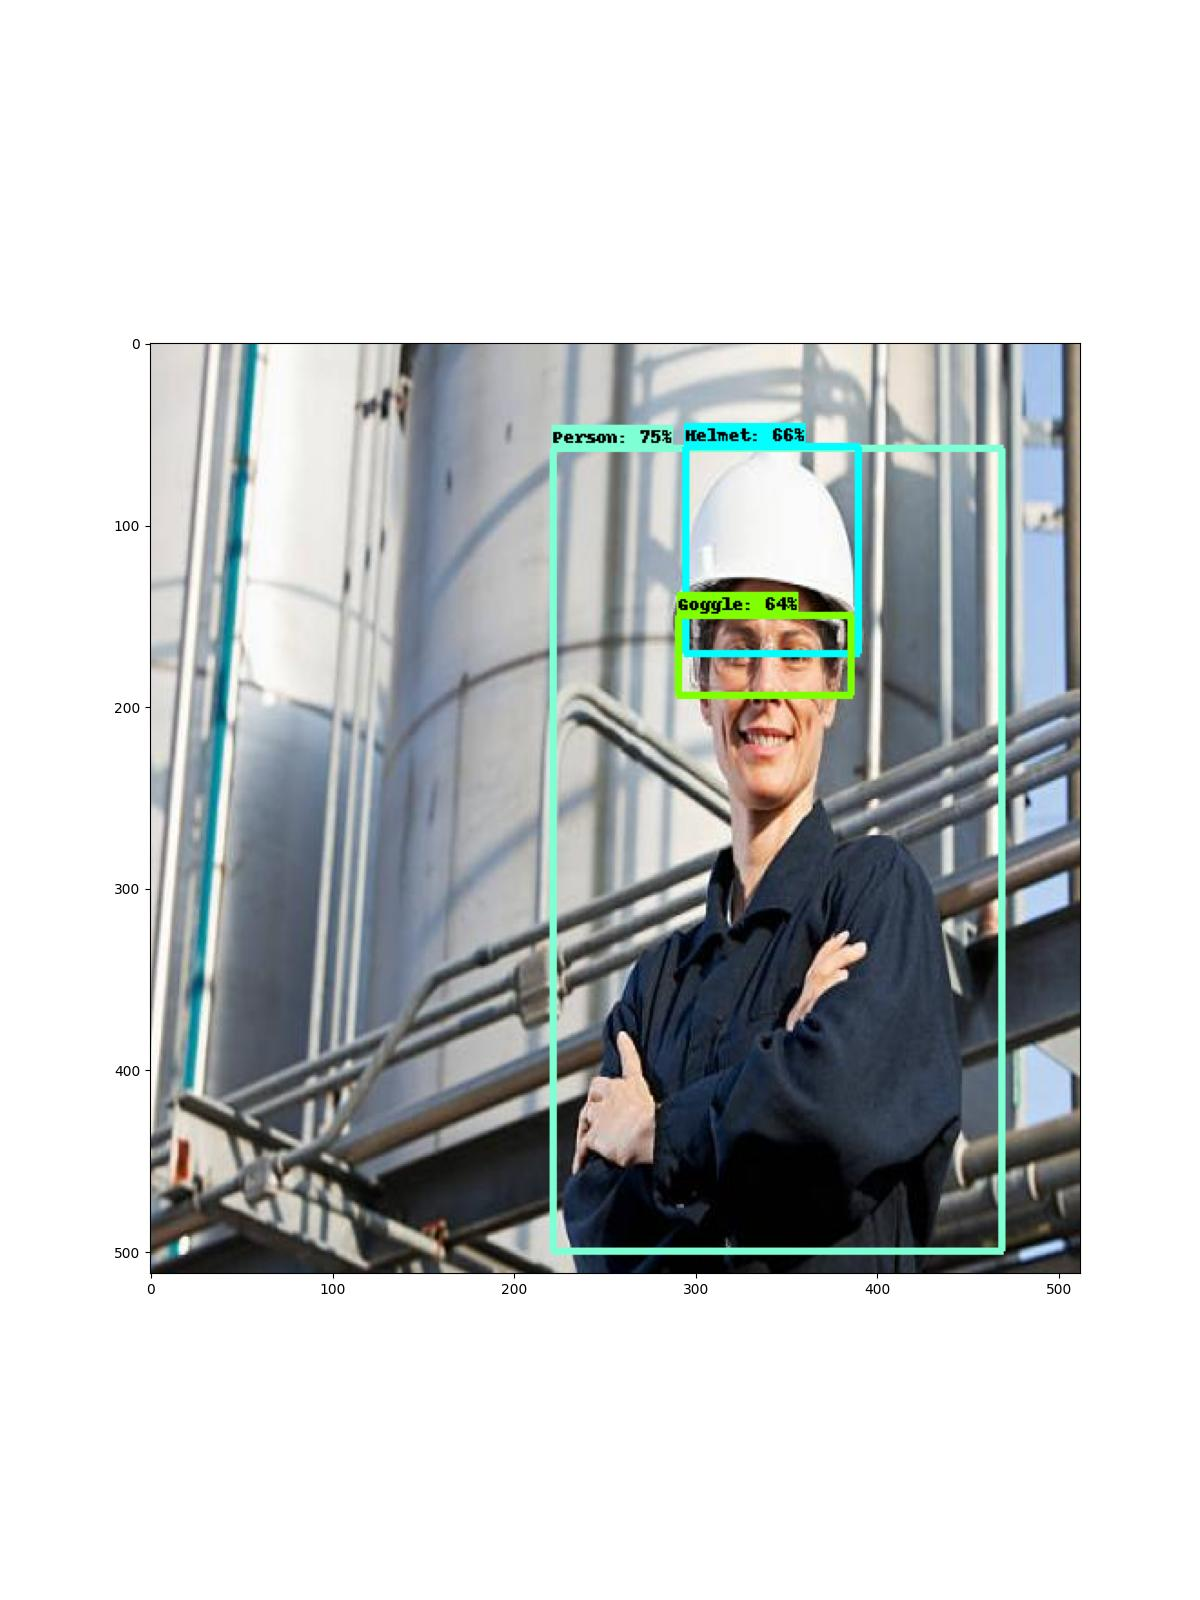

tp :  2
fp :  1
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Helmet', 'Person', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/15_jpg.rf.b245
image_path :  /content/test_/32_jpeg.rf.8da813b6326956838da603230c564eac.jpg


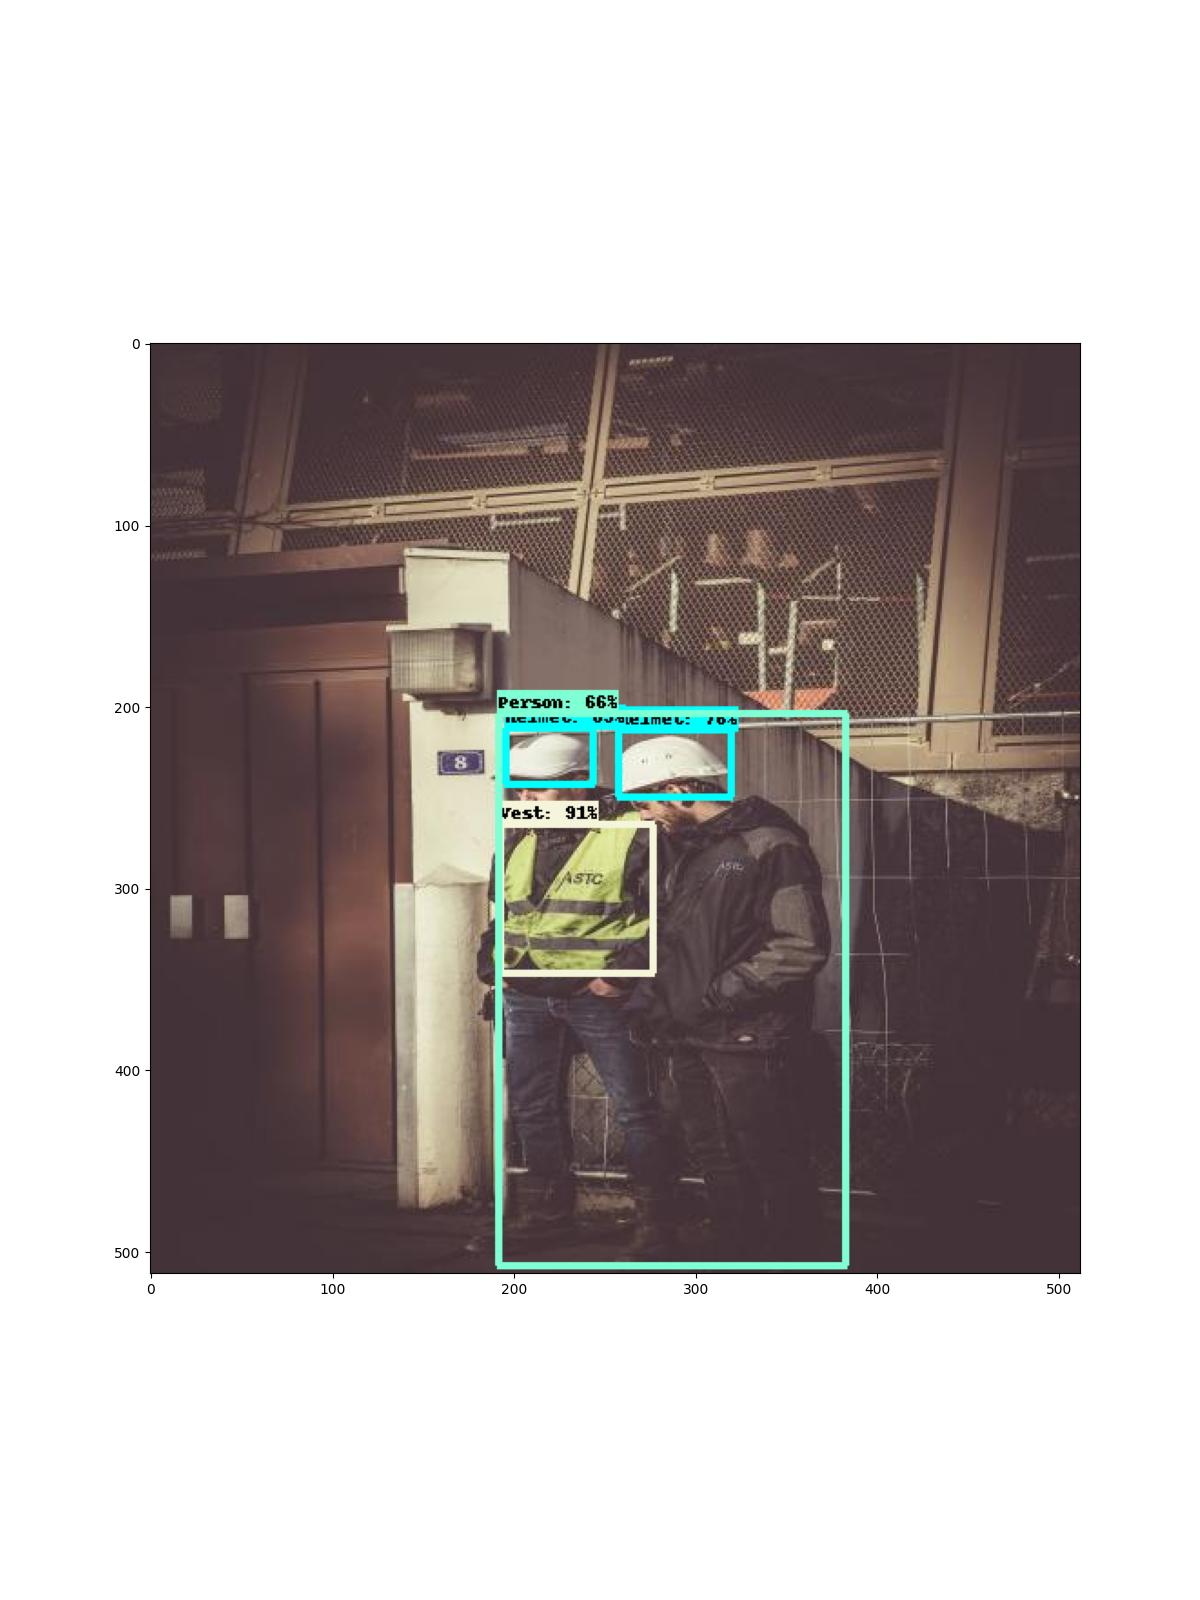

tp :  5
fp :  3
Precision: 0.625
Recall: 0.625
ground_truth_annotations_i :  ['Helmet', 'Helmet', 'Person', 'Person', 'Shoe', 'Shoe', 'Shoe', 'Vest']
predicted_labels :  ['Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Shoe', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 1 1 0 0]
 [0 0 2 0 0]
 [0 0 2 1 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/32_jpeg.rf.8da
image_path :  /content/test_/youtube-738_jpg.rf.b8ca425f0d3e0007674ac84ebd64506e.jpg


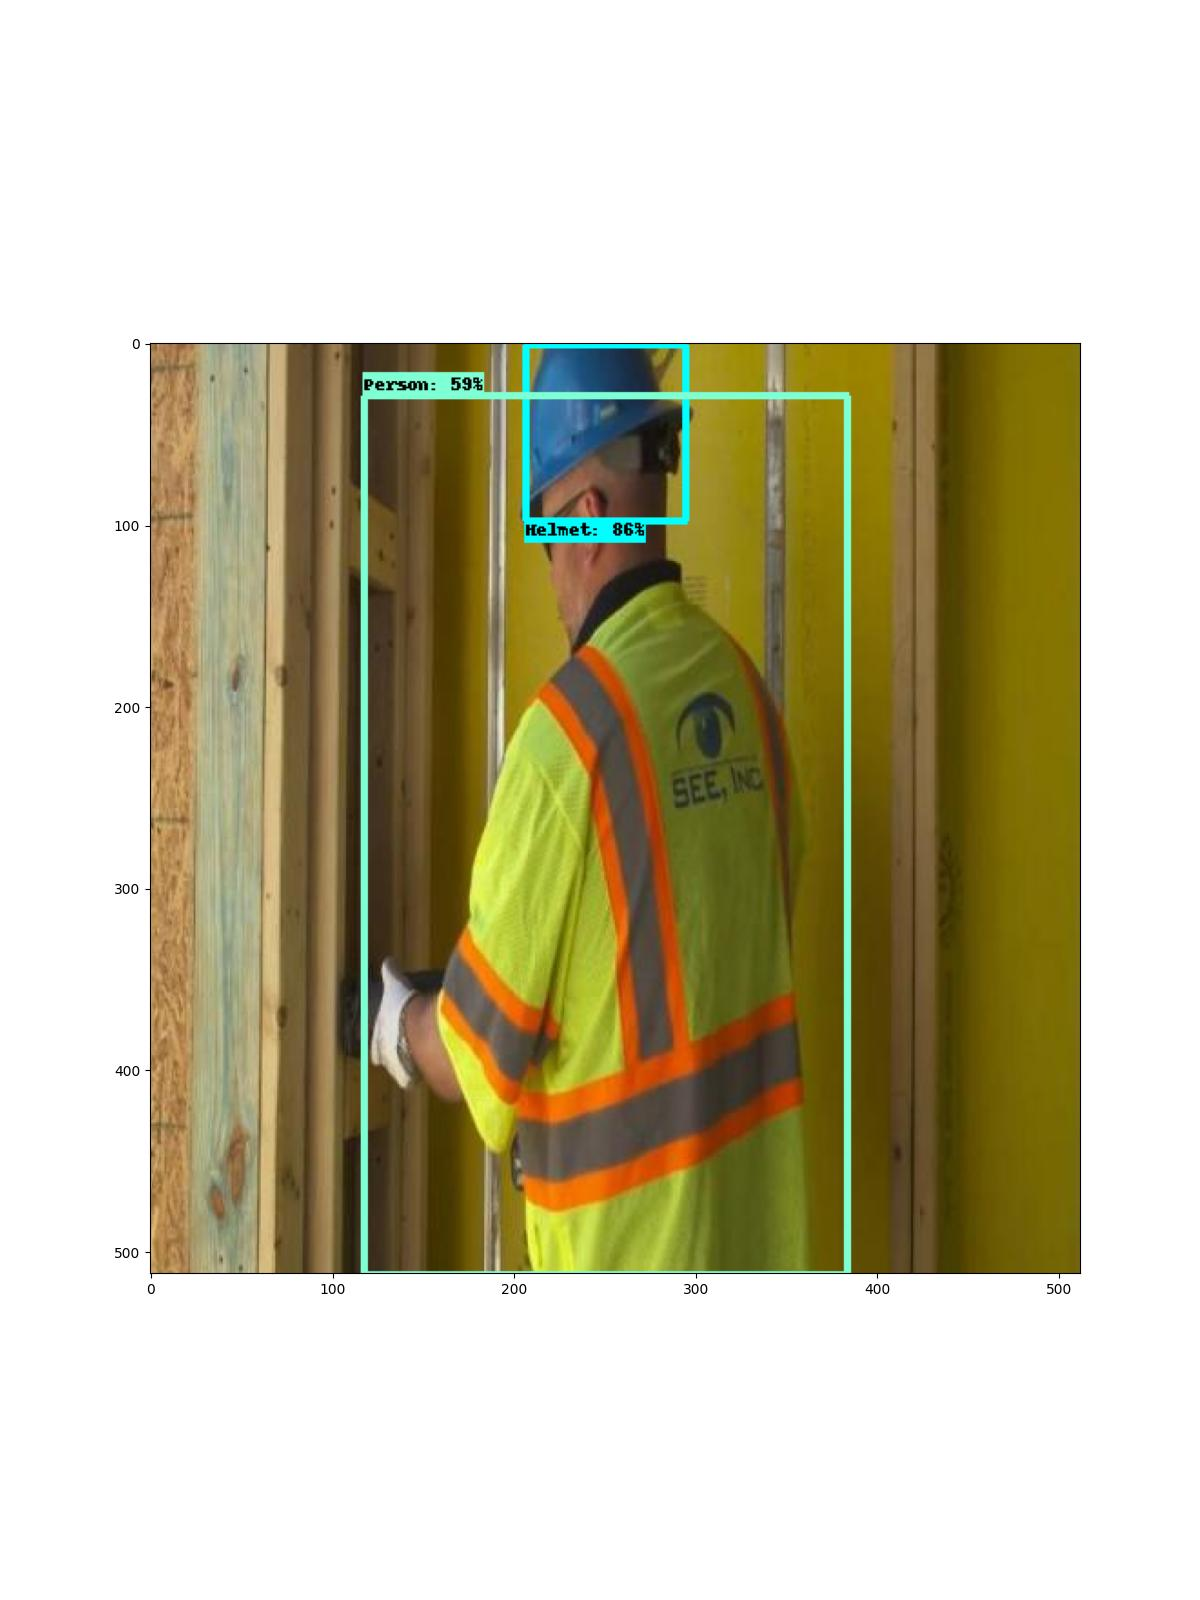

tp :  1
fp :  2
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/youtube-738_jp
image_path :  /content/test_/31_jpg.rf.b32814c0c68da30c964d991198a28abe.jpg


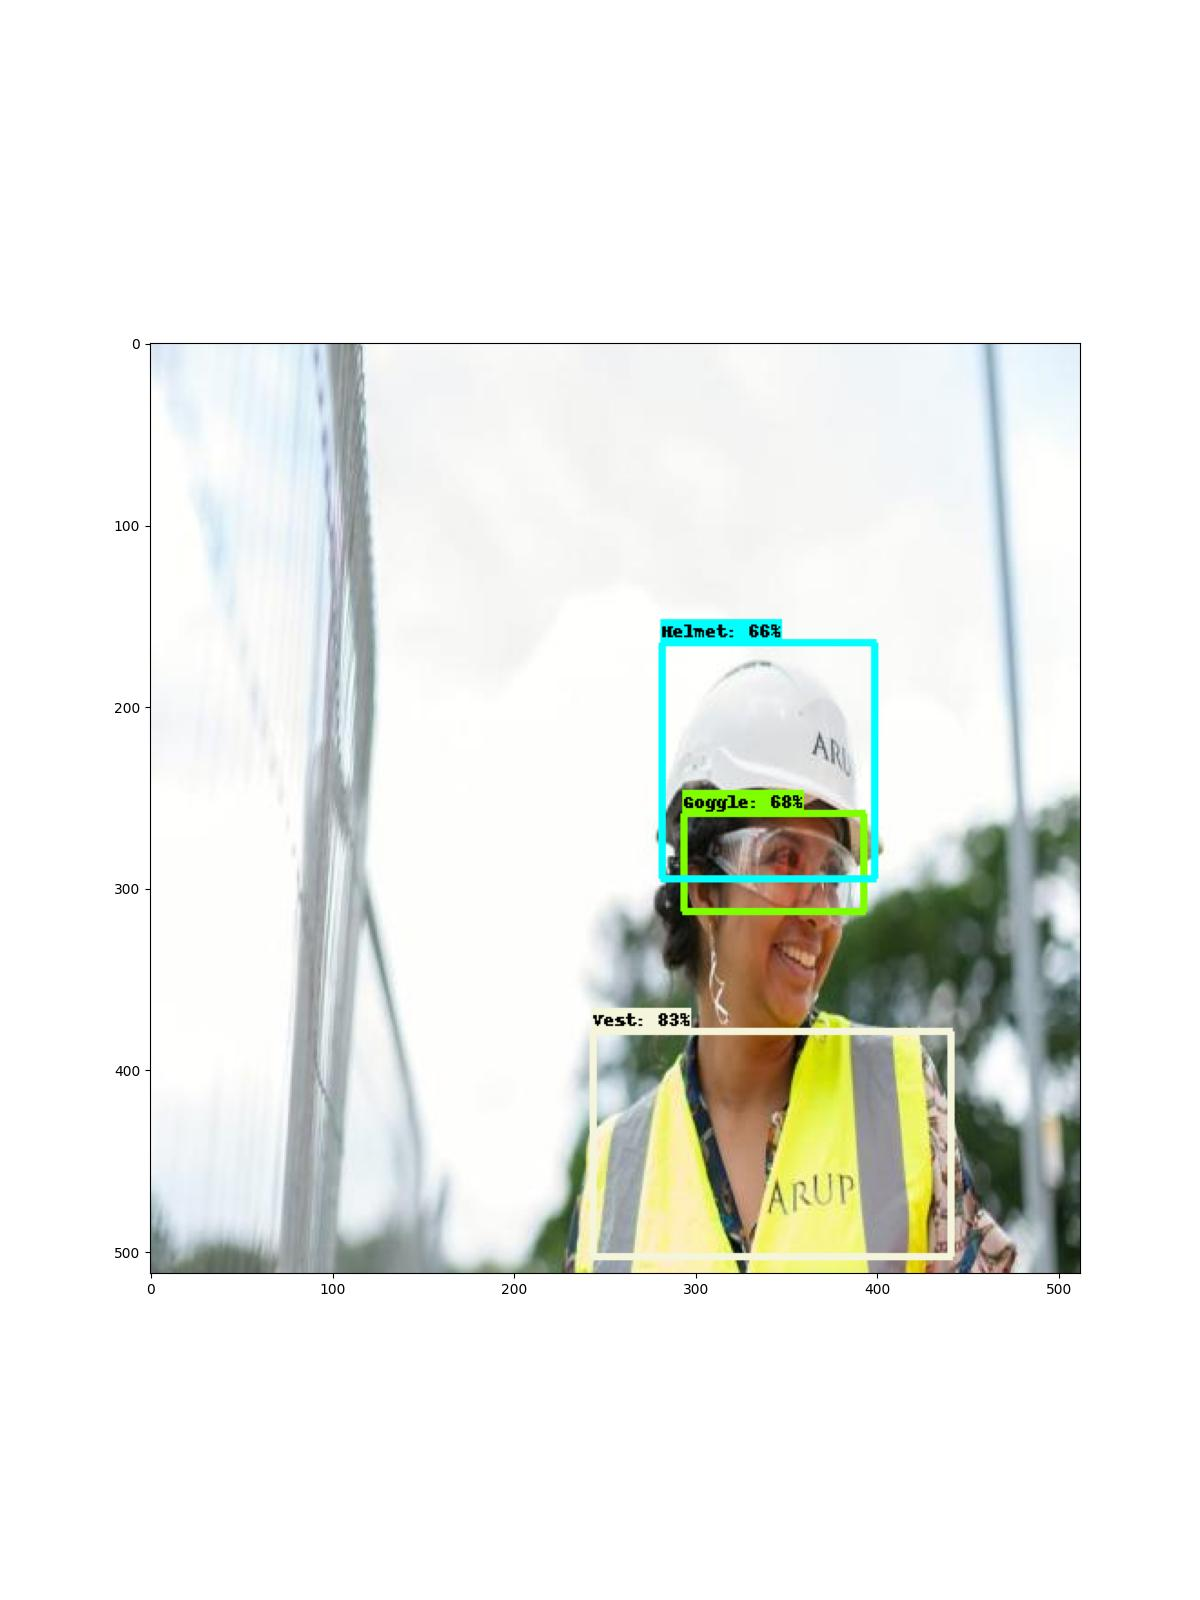

tp :  1
fp :  3
Precision: 0.25
Recall: 0.25
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Shoe', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/31_jpg.rf.b328
image_path :  /content/test_/20_jpg.rf.094024a9d9aaeec749348ddfbe67be3d.jpg


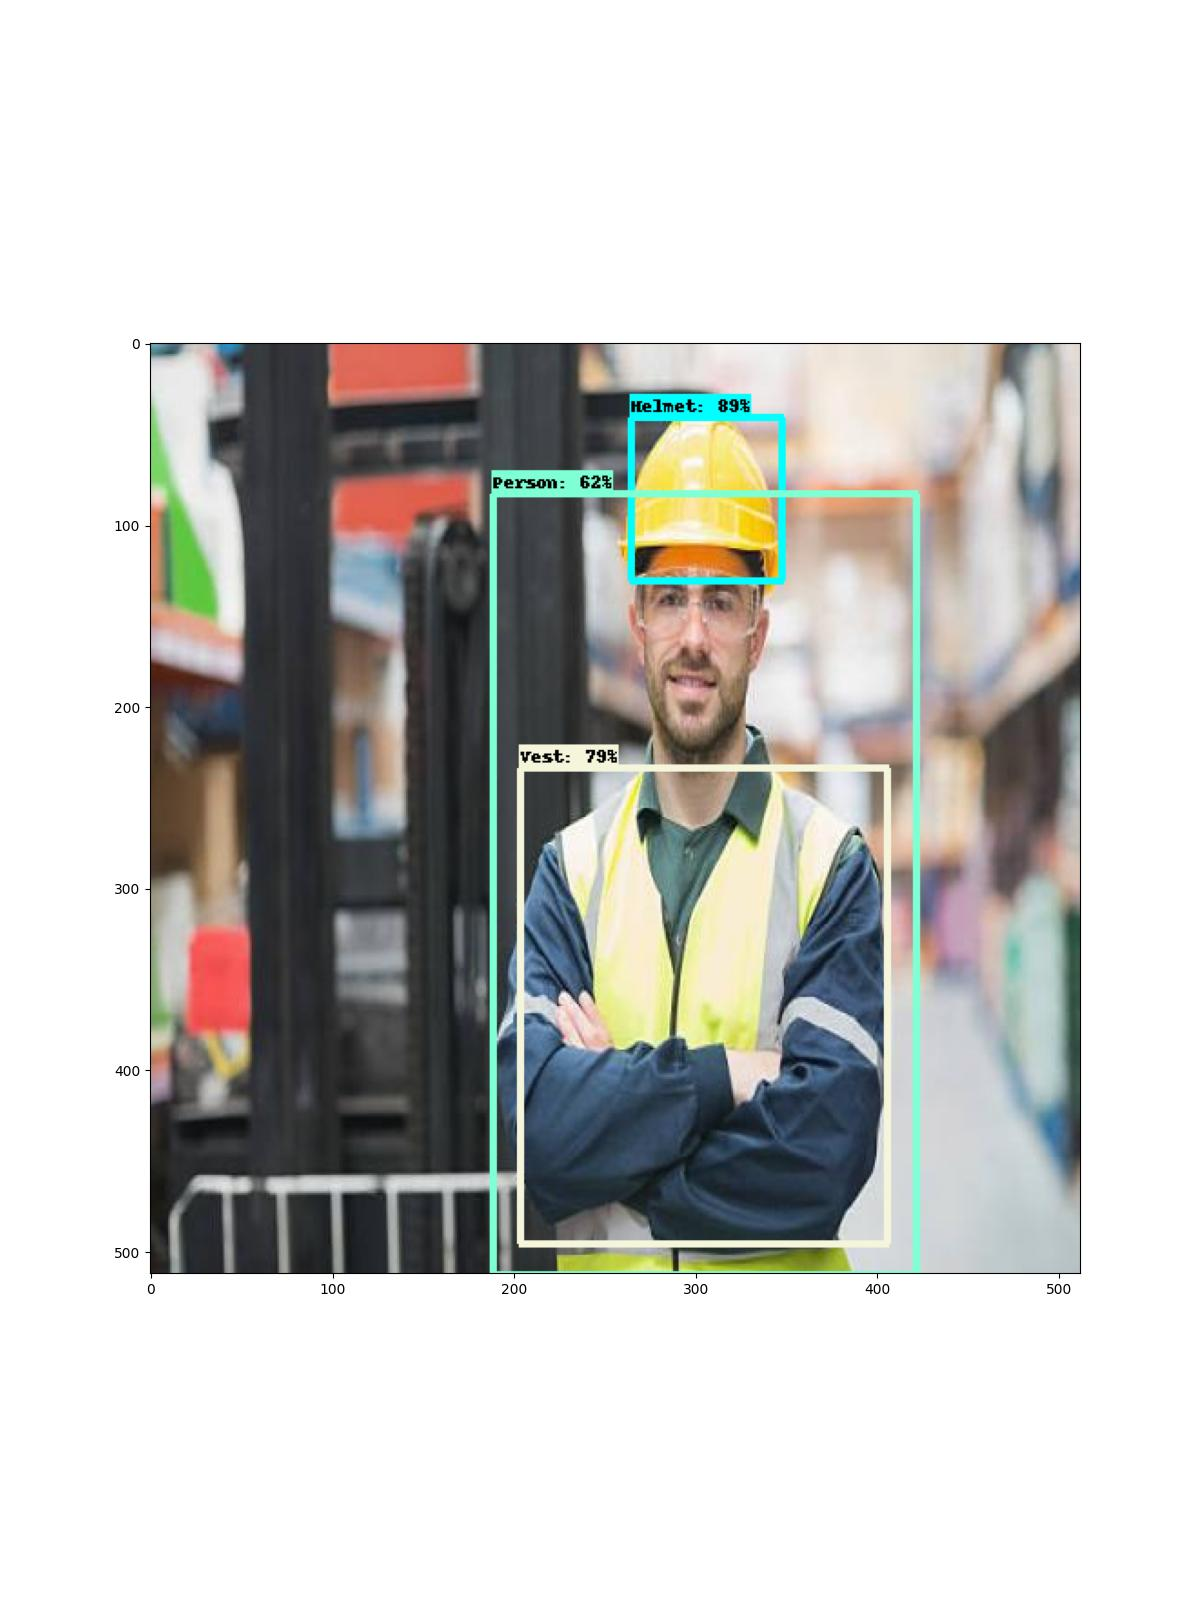

tp :  2
fp :  2
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Shoe', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/20_jpg.rf.0940
image_path :  /content/test_/9_webp.rf.24e81a2c93fe12b8718c2aa57adfc95a.jpg


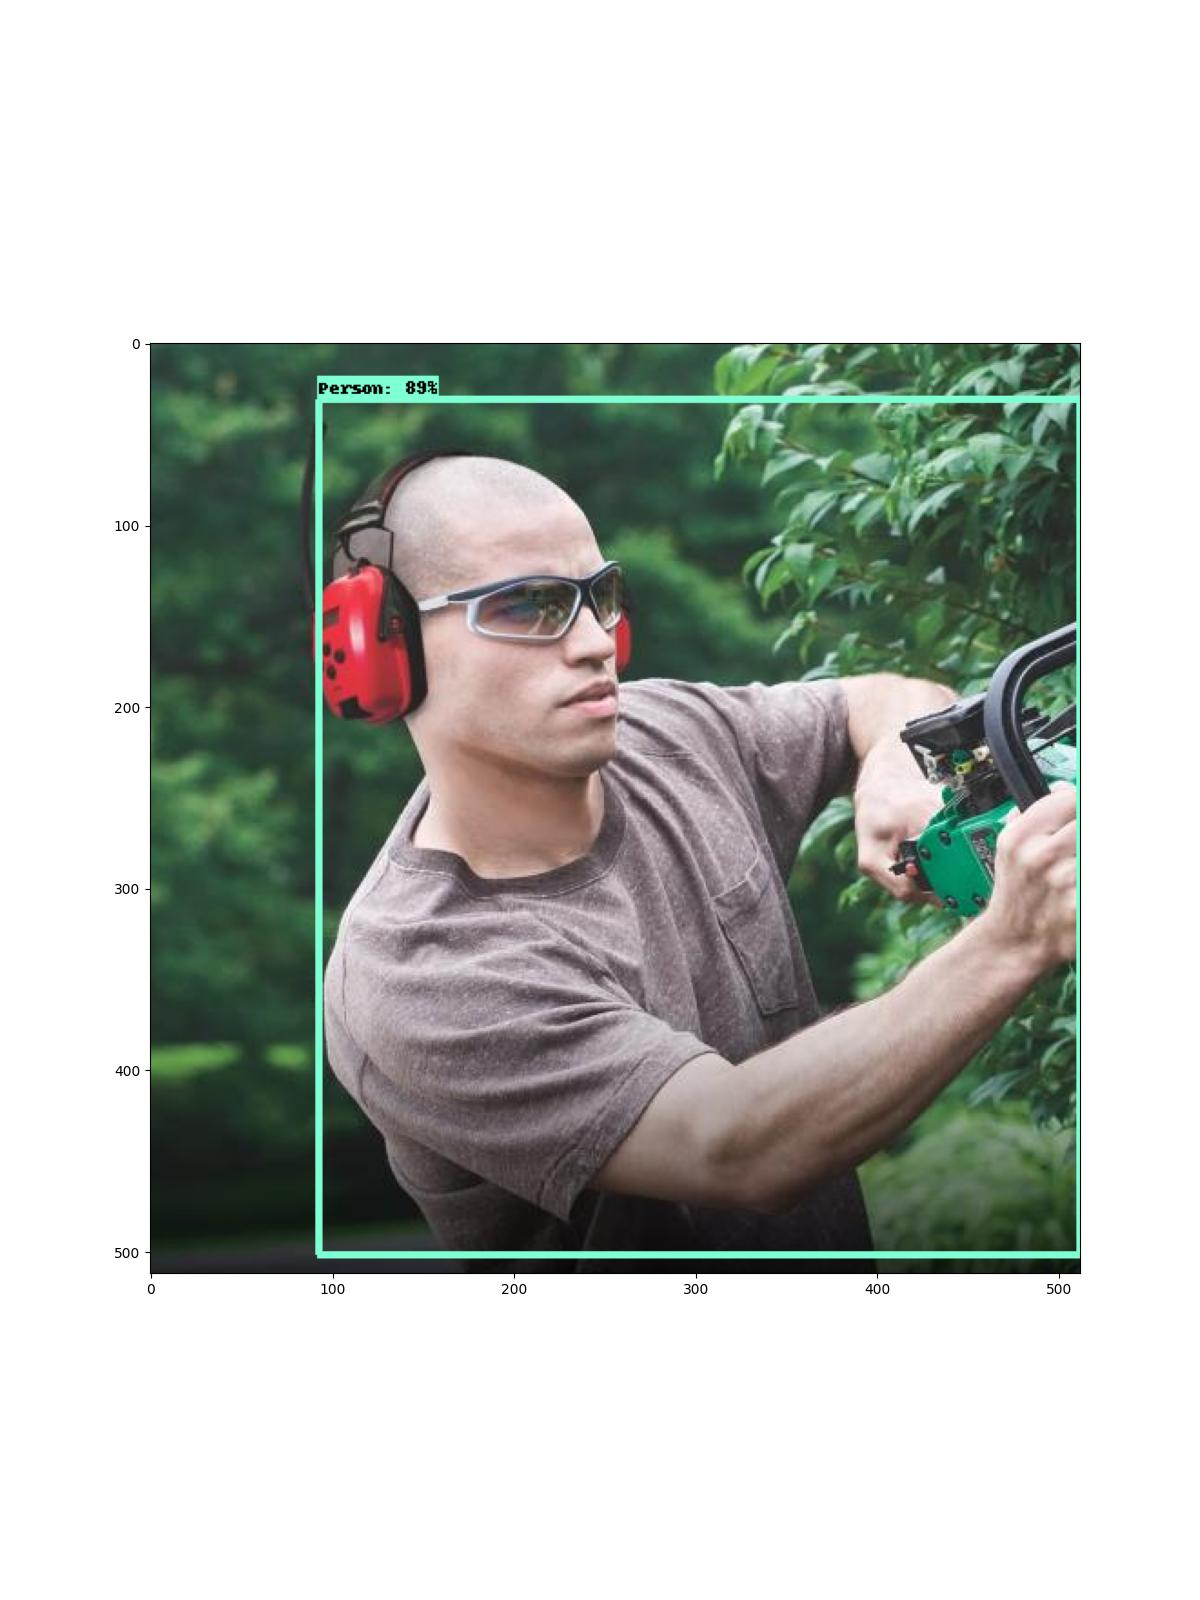

tp :  2
fp :  0
Precision: 1.0
Recall: 1.0
ground_truth_annotations_i :  ['Goggle', 'Person']
predicted_labels :  ['Goggle', 'Person']
Confusion Matrix:
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/9_webp.rf.24e8
image_path :  /content/test_/101_JPG_jpg.rf.ecb48472952f0d7fb890f9d6ef8222d6.jpg


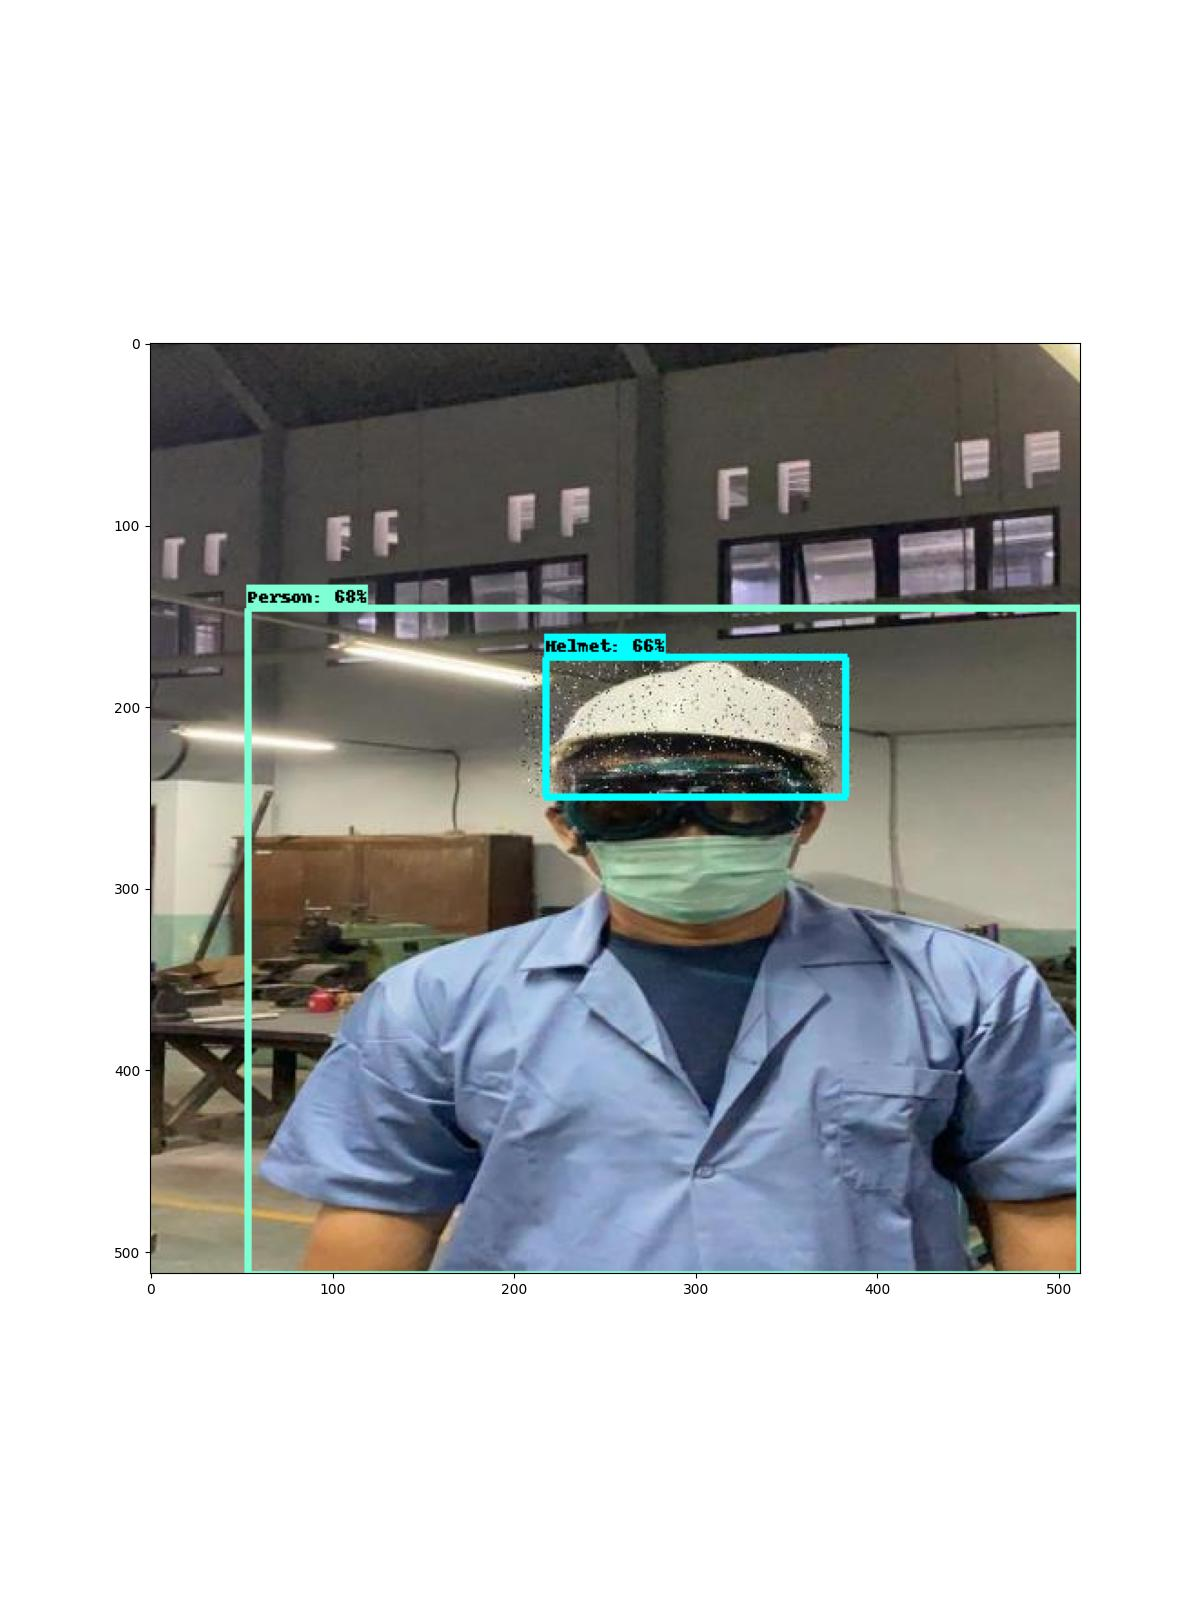

tp :  0
fp :  3
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Goggle', 'Person', 'Shoe']
Confusion Matrix:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/101_JPG_jpg.rf
image_path :  /content/test_/10_webp.rf.248088fb8fcde468b755c4e0bee8a389.jpg


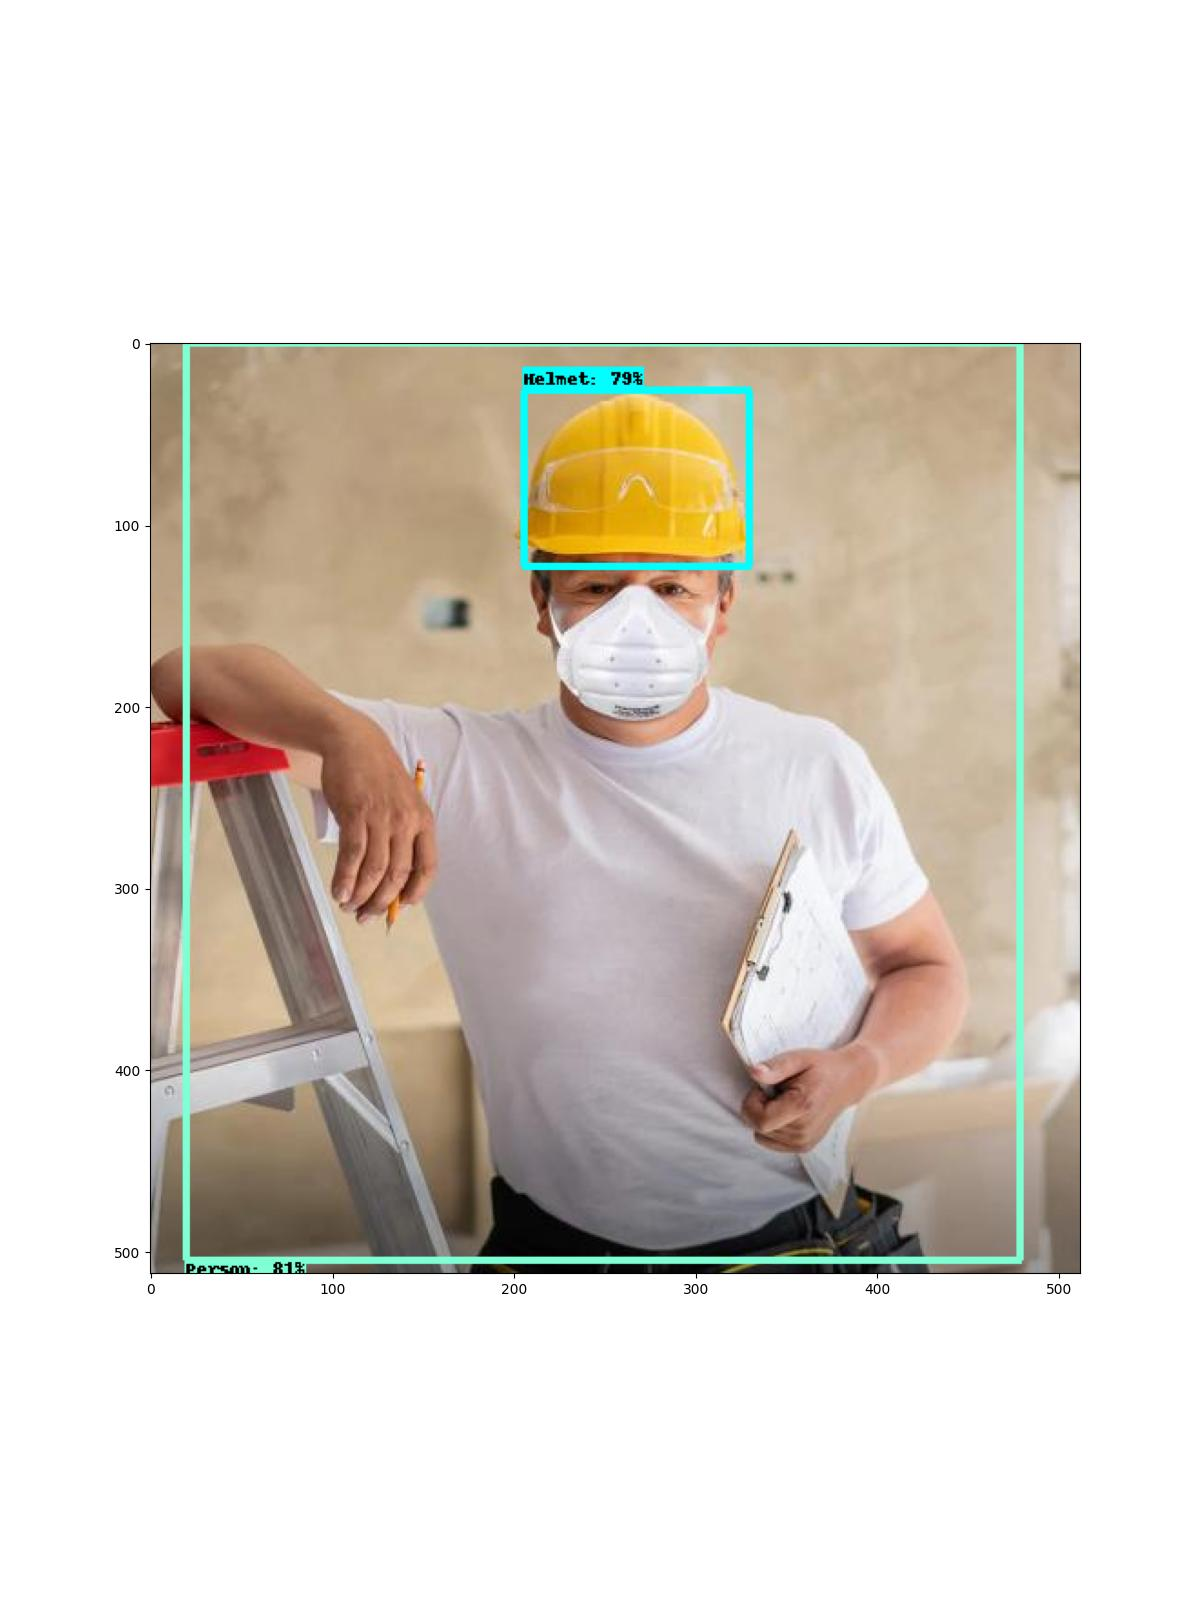

tp :  0
fp :  3
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Goggle', 'Helmet', 'Helmet']
Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/10_webp.rf.248
image_path :  /content/test_/19_jpg.rf.aa4a2f0f7ad1fb6db5c634d9bdbe1039.jpg


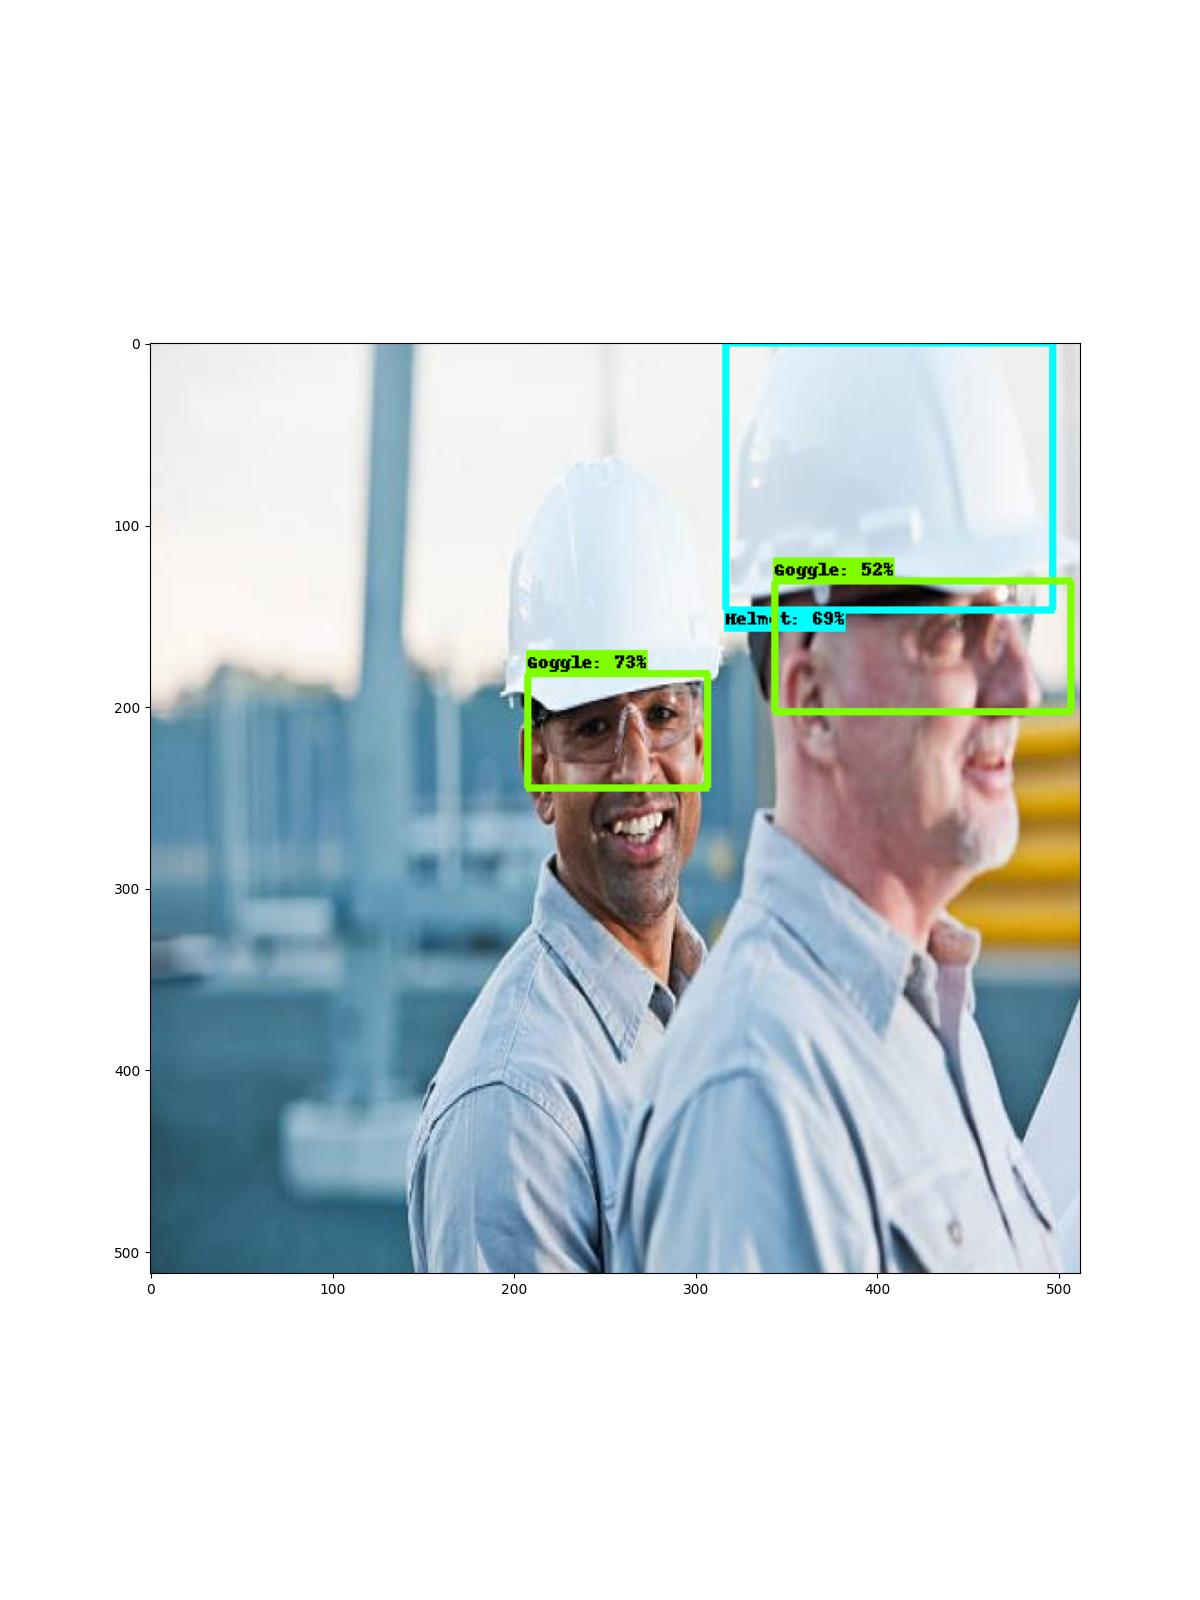

tp :  3
fp :  3
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person']
predicted_labels :  ['Goggle', 'Person', 'Person', 'Shoe', 'Vest', 'Vest']
Confusion Matrix:
[[1 0 1 0 0]
 [0 0 1 1 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/19_jpg.rf.aa4a
image_path :  /content/test_/14_jpg.rf.b399f54d532cbc2d430fb20147bceb8e.jpg


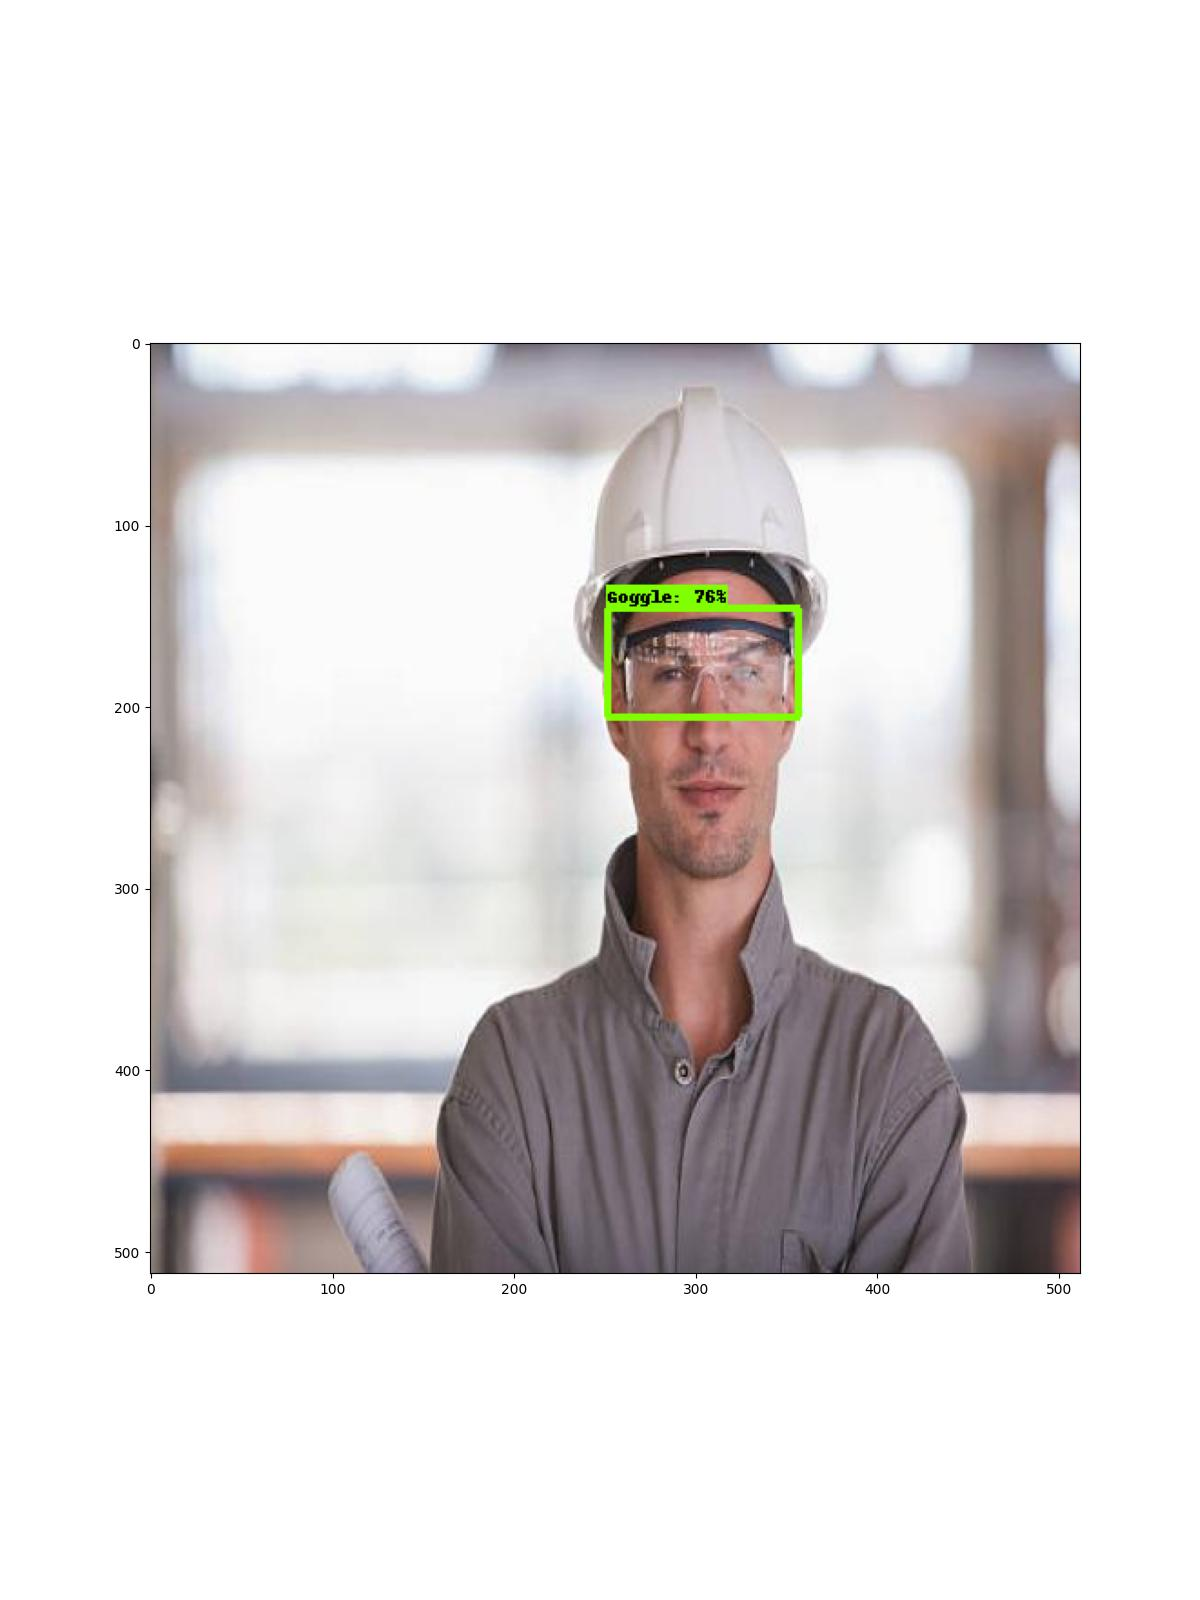

tp :  1
fp :  2
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Helmet', 'Shoe', 'Vest']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/14_jpg.rf.b399
image_path :  /content/test_/17_jpg.rf.b14dc0ae2e0a774a55916cad410ebb43.jpg


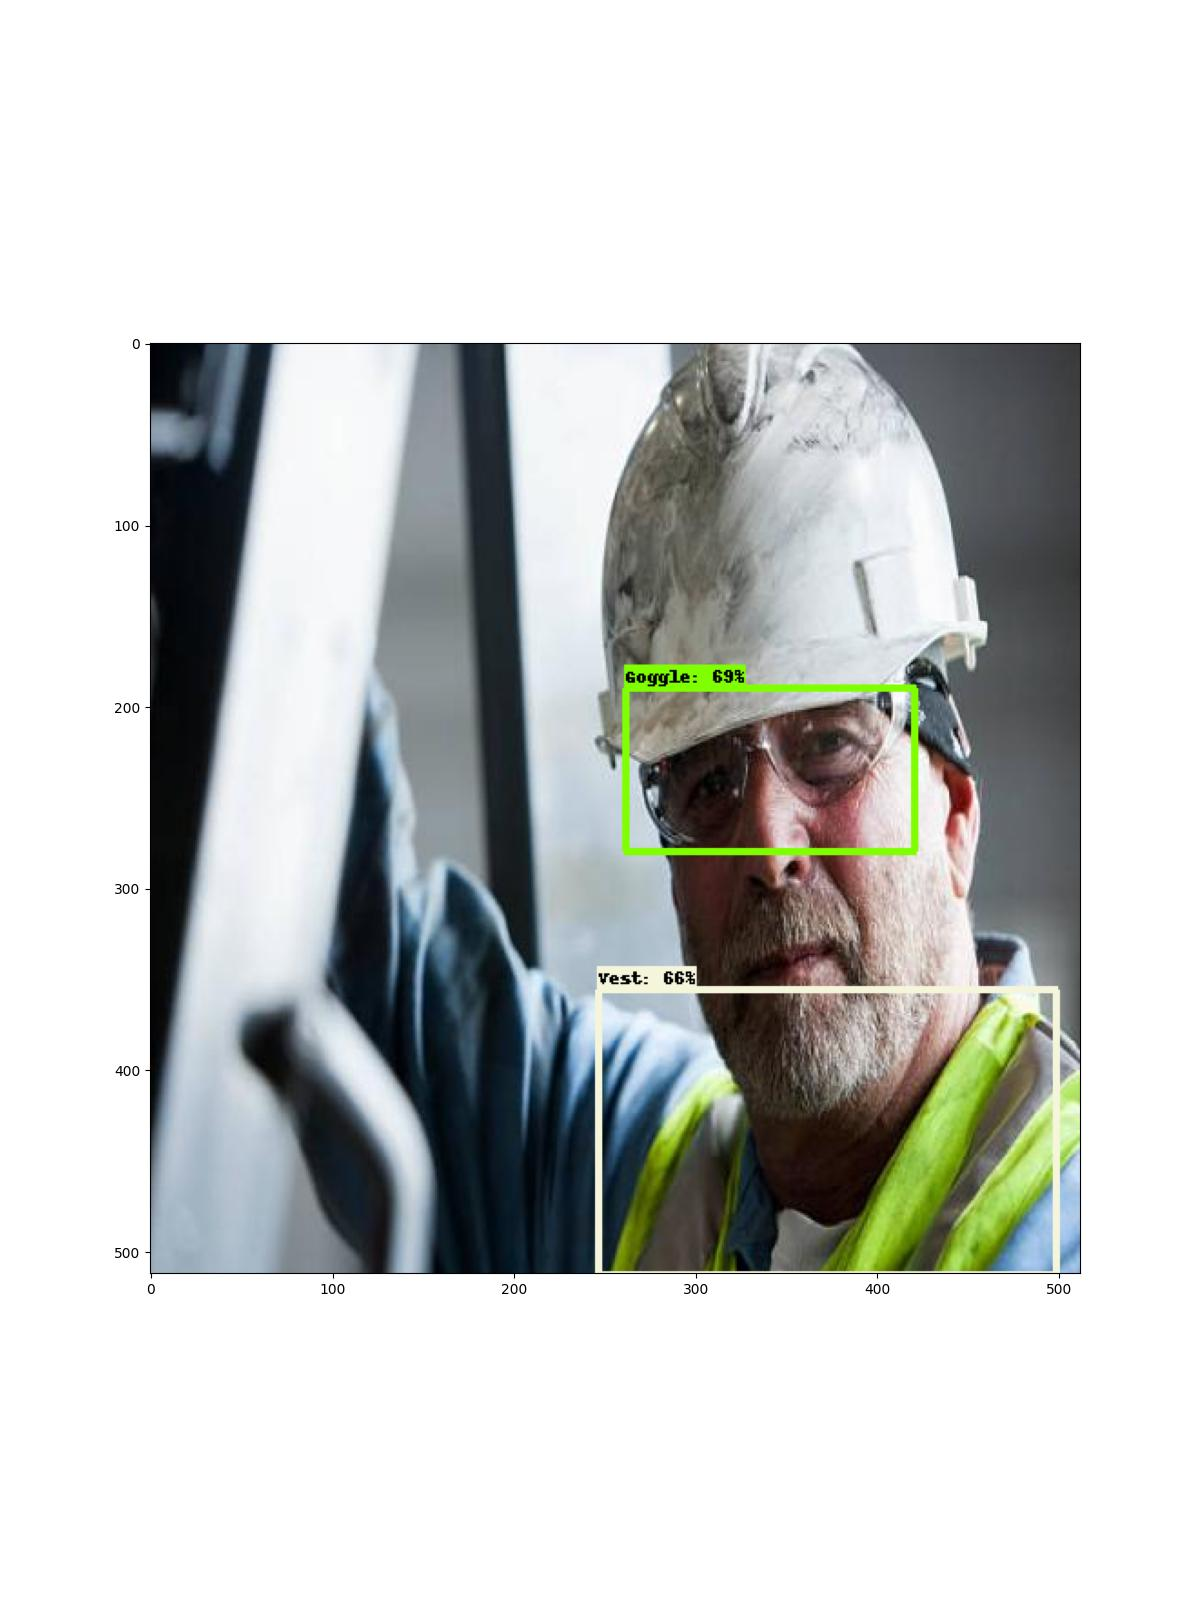

tp :  1
fp :  3
Precision: 0.25
Recall: 0.25
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Shoe']
Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/17_jpg.rf.b14d
image_path :  /content/test_/24_jpg.rf.e31ef94e8234eb2ab34a09198e105e71.jpg


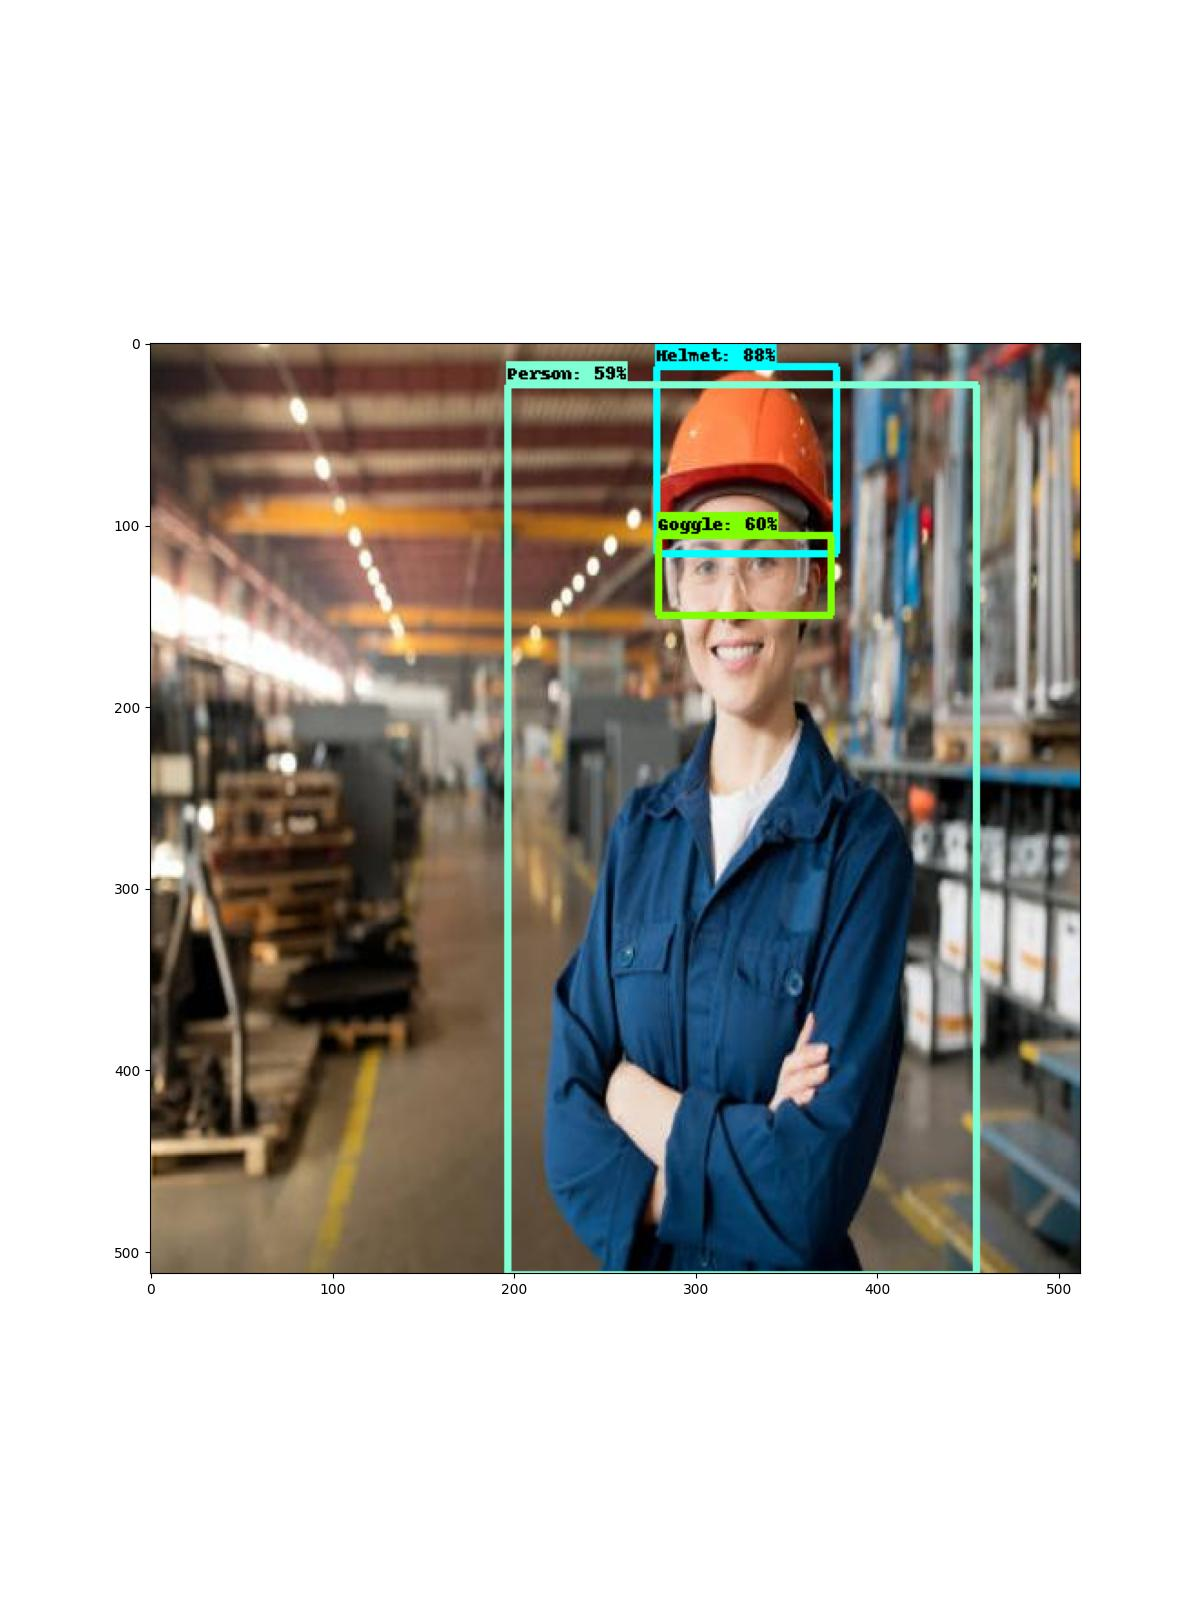

tp :  2
fp :  1
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Helmet', 'Person', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/24_jpg.rf.e31e
image_path :  /content/test_/28_jpg.rf.1890fe40c31b5fffec5170a2c969cd73.jpg


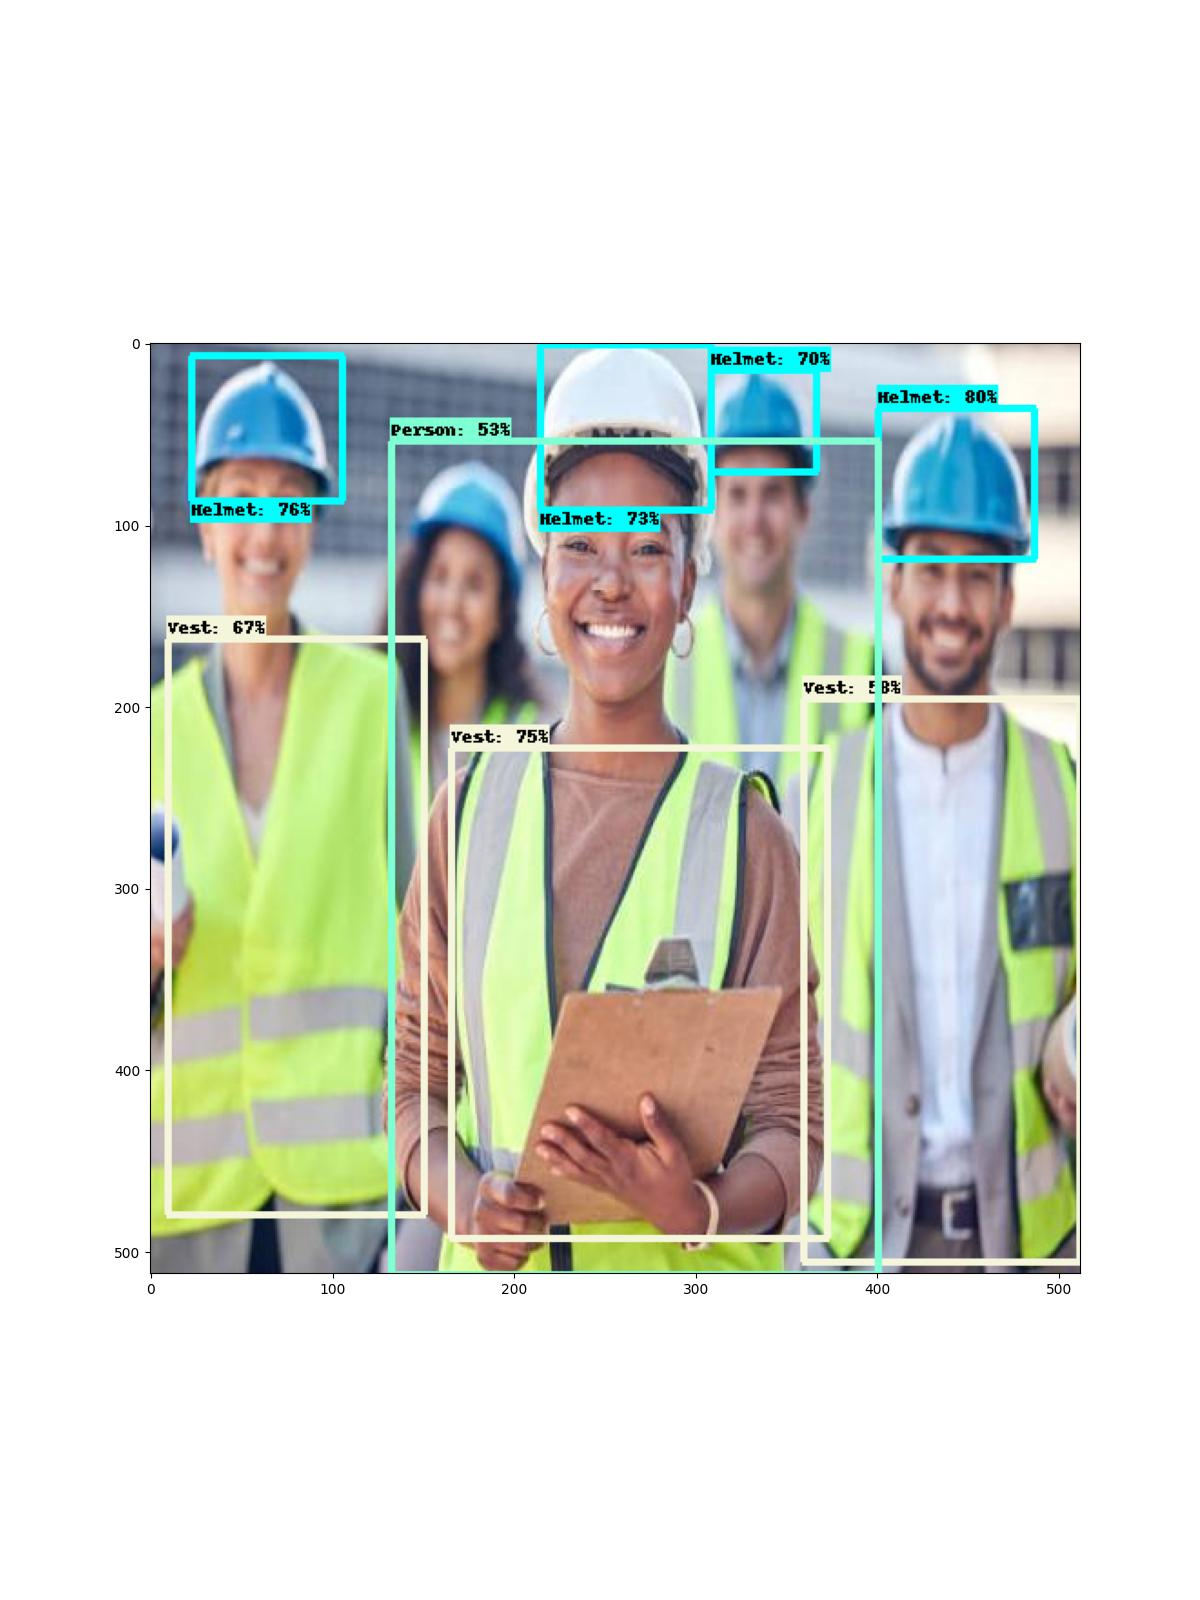

tp :  8
fp :  7
Precision: 0.5333333333333333
Recall: 0.5333333333333333
ground_truth_annotations_i :  ['Helmet', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [2 3 0 0 0]
 [0 0 5 0 0]
 [0 0 0 0 0]
 [0 0 1 0 4]]
/content/raw_test_image_output/28_jpg.rf.1890
image_path :  /content/test_/99f98ce9-images_25_jpeg_jpg.rf.5e1c4632ee019044d64a939cb369db98.jpg


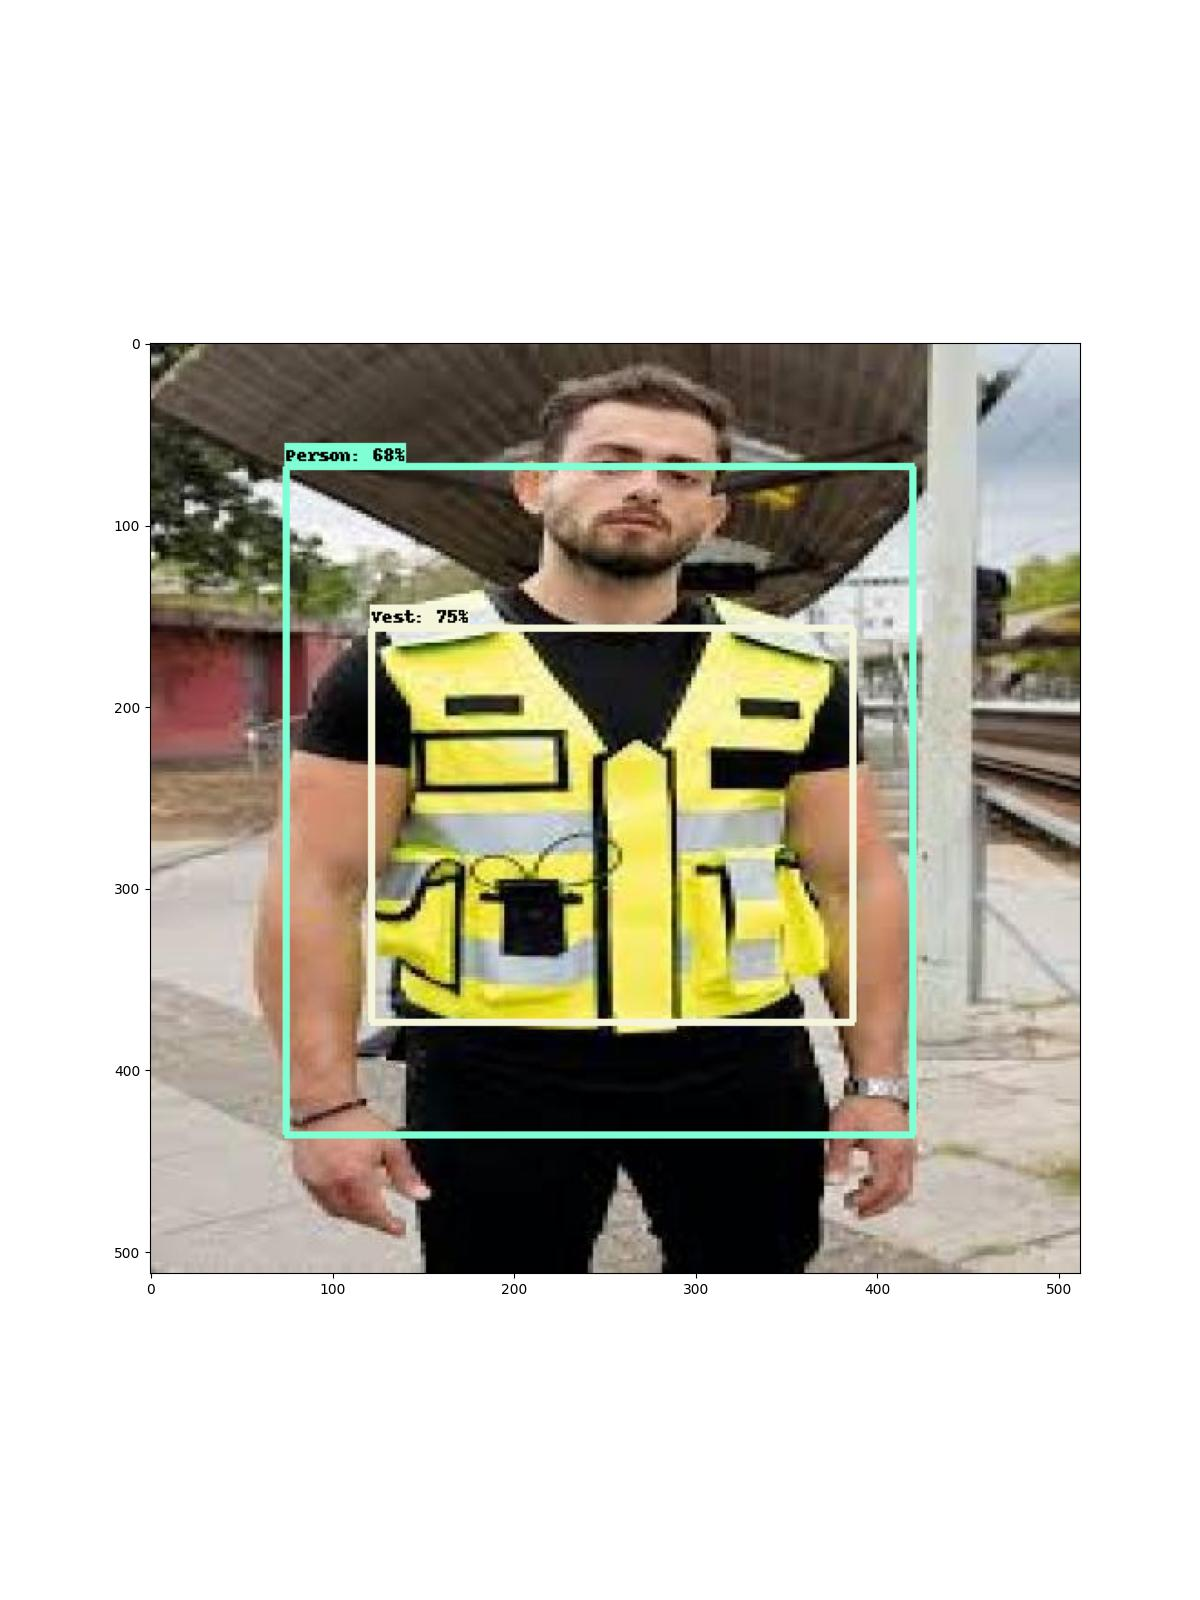

tp :  0
fp :  2
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Person', 'Vest']
predicted_labels :  ['Shoe', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/99f98ce9-image
image_path :  /content/test_/30_jpg.rf.a2e0a5b8d5e56ae0327191855828985d.jpg


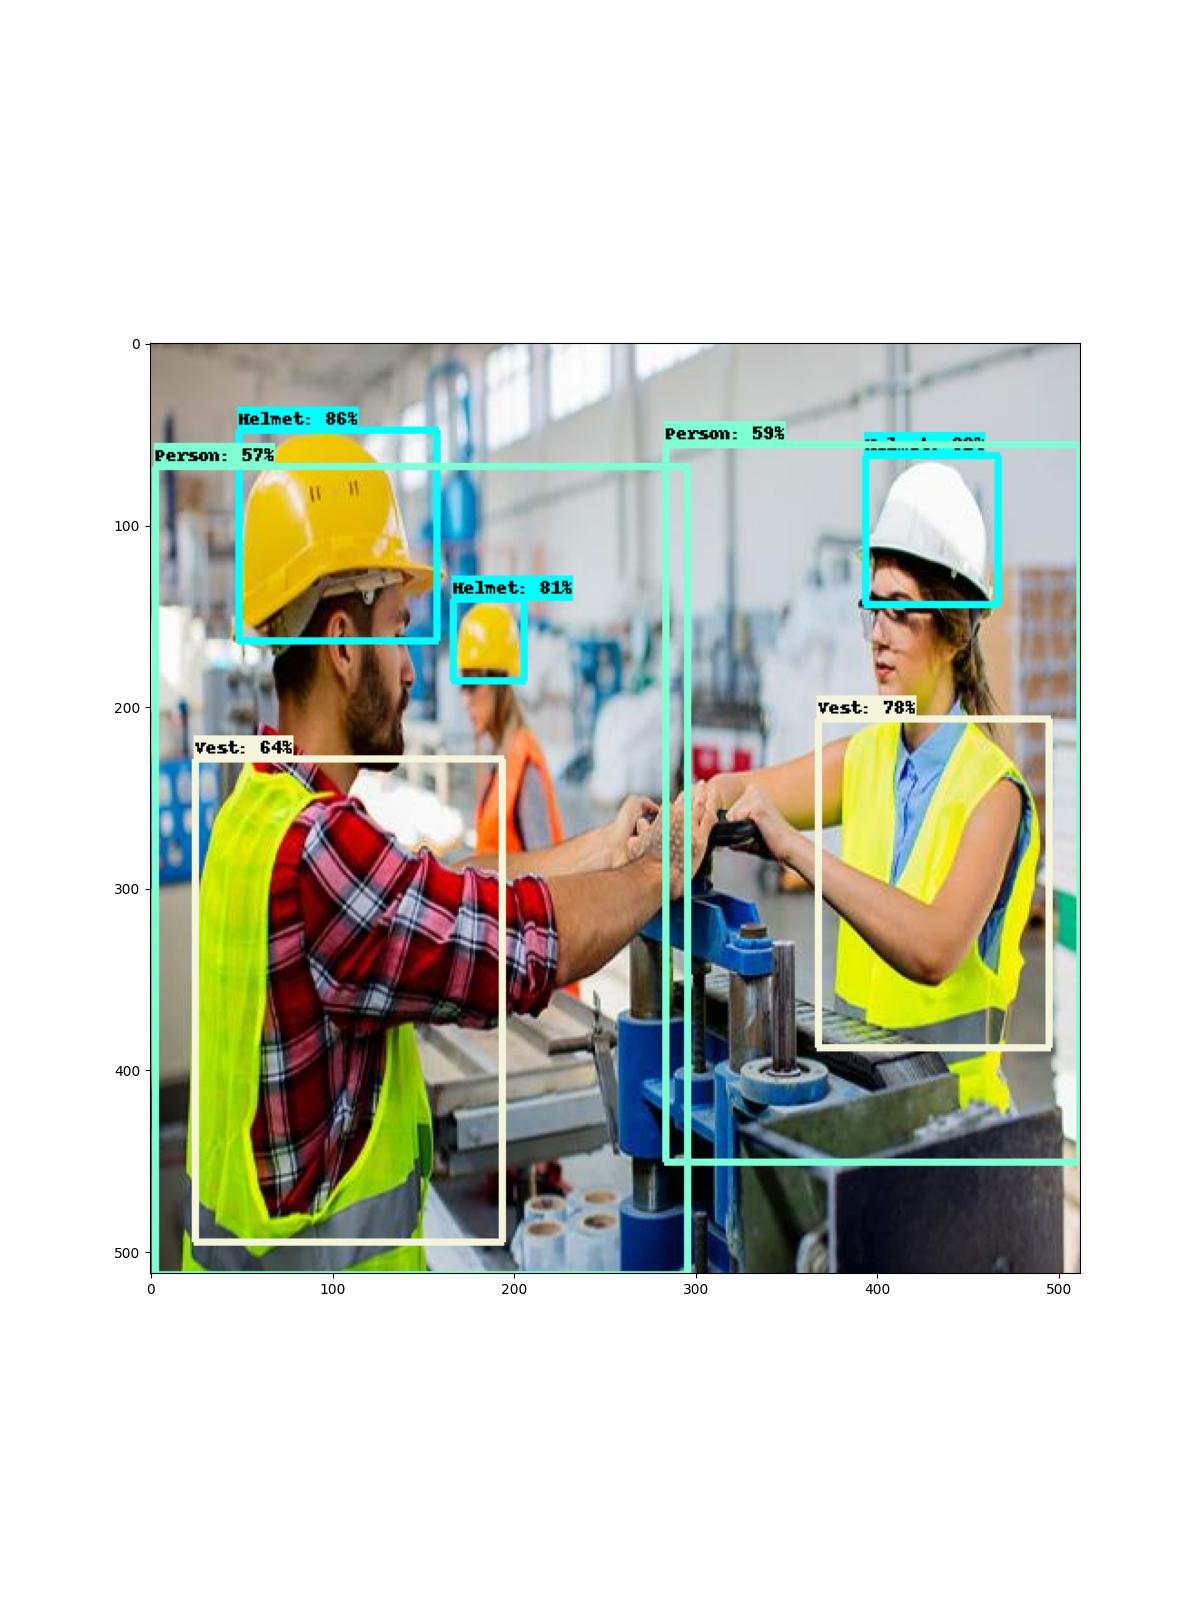

tp :  3
fp :  6
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 0 3 0 0]
 [0 0 0 0 3]
 [0 0 0 0 0]
 [0 0 0 0 2]]
/content/raw_test_image_output/30_jpg.rf.a2e0
image_path :  /content/test_/39_jpg.rf.5517a28cd252b83b93d87a5064def902.jpg


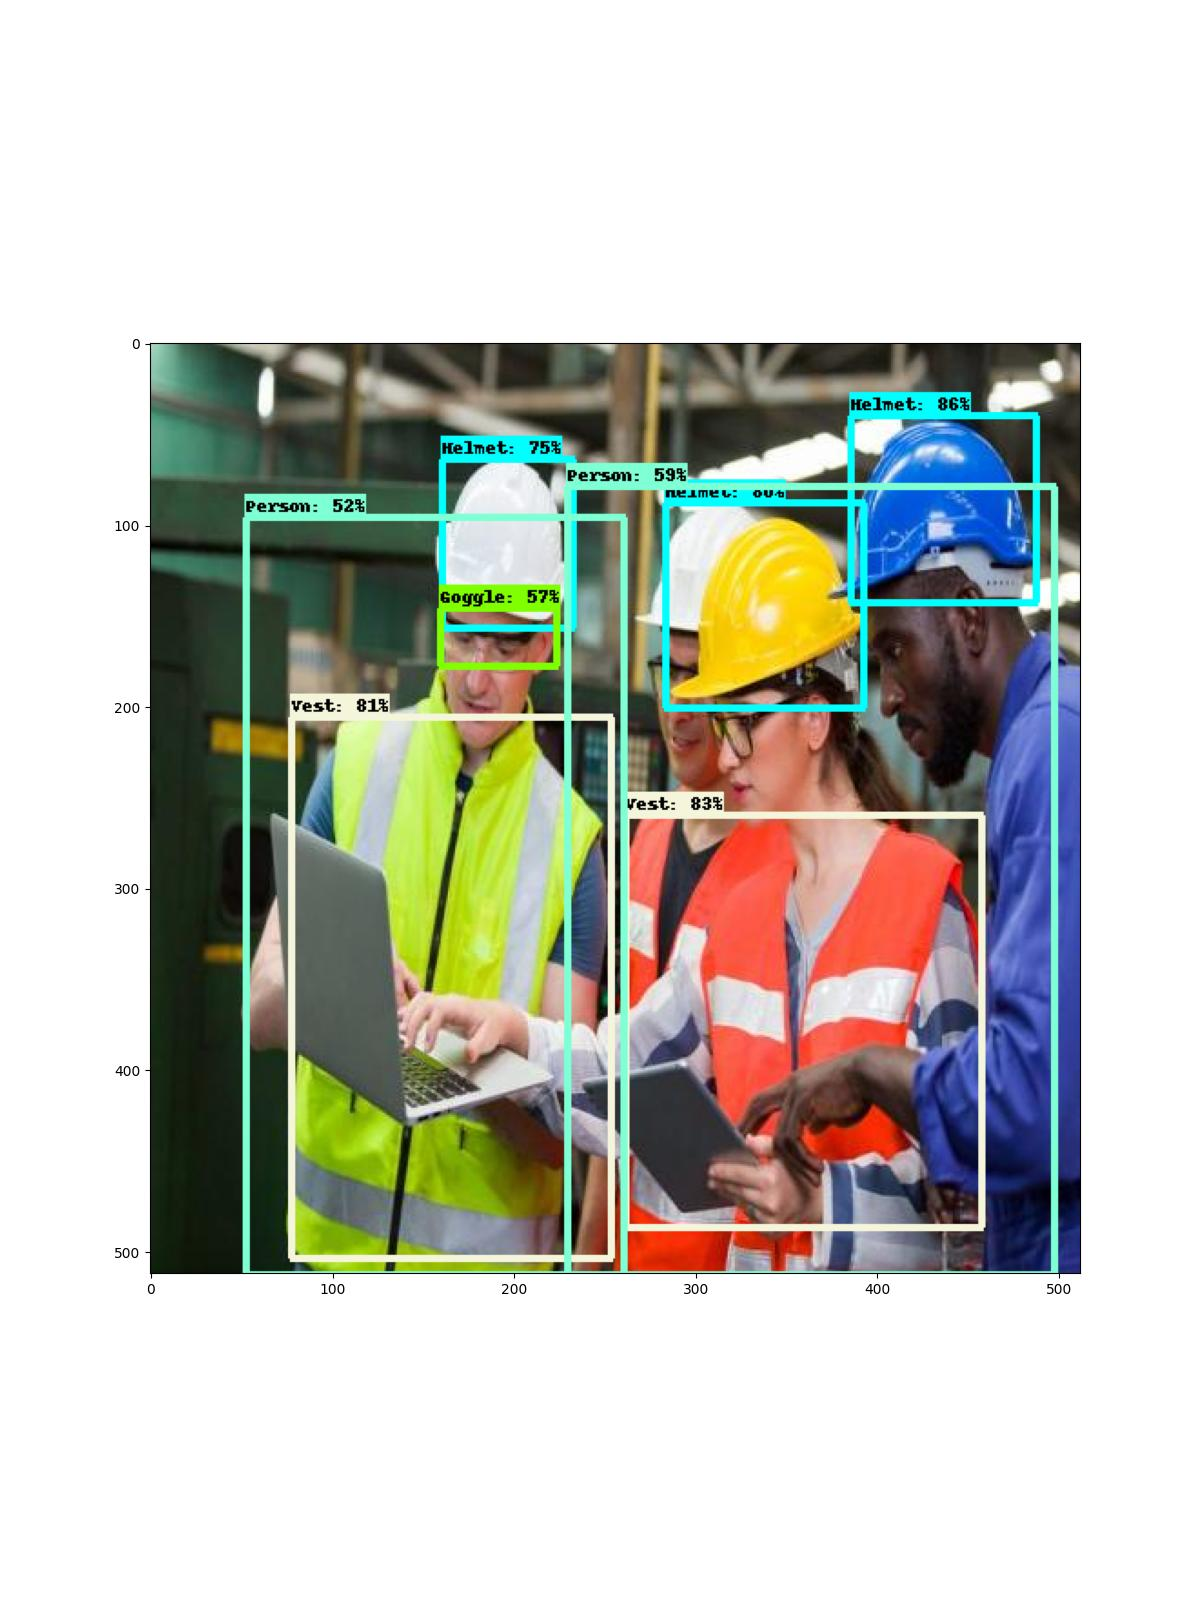

tp :  7
fp :  3
Precision: 0.7
Recall: 0.7
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Vest', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[3 0 0 0 0]
 [1 3 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 3]]
/content/raw_test_image_output/39_jpg.rf.5517
image_path :  /content/test_/2ff24763-images_2_1_jpeg_jpg.rf.988f351bb60fdb53da5eb3d0d2ad84fd.jpg


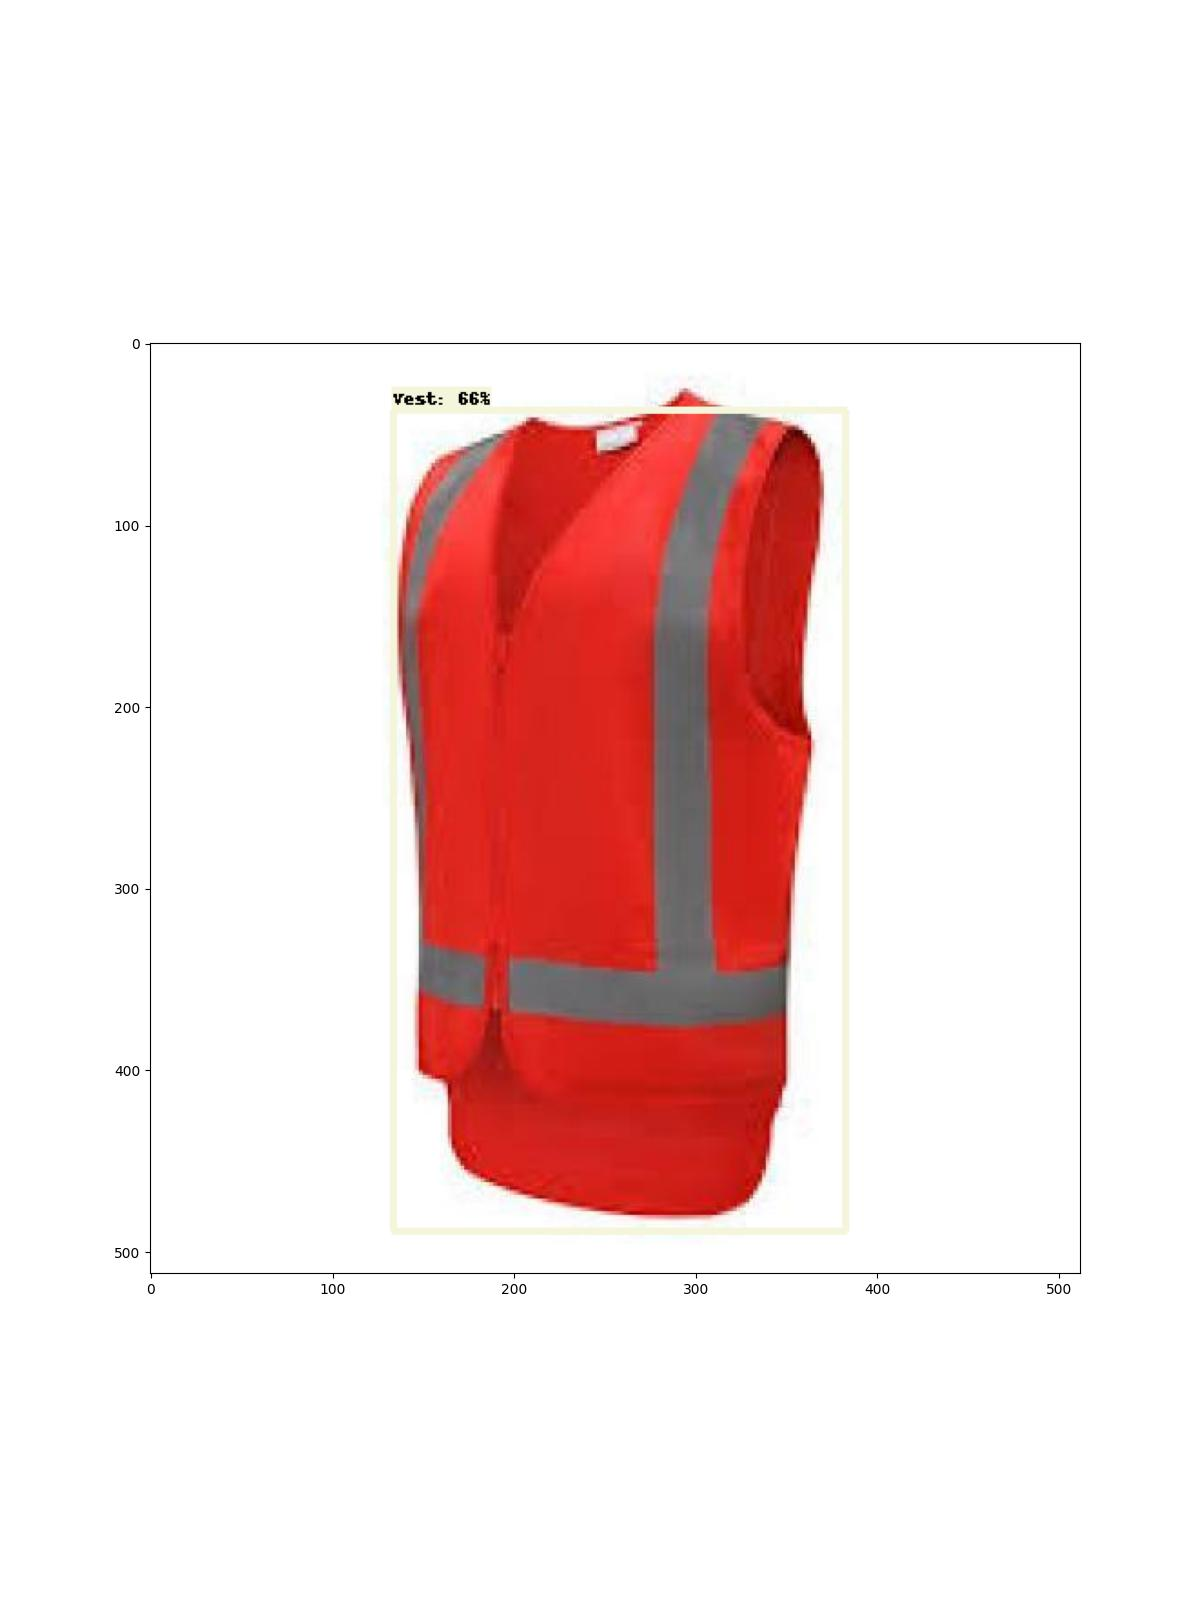

tp :  0
fp :  1
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Vest']
predicted_labels :  ['Helmet']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
/content/raw_test_image_output/2ff24763-image
image_path :  /content/test_/ppe_0307_jpg.rf.a1effd568beac41ea93ba021ff17938a.jpg


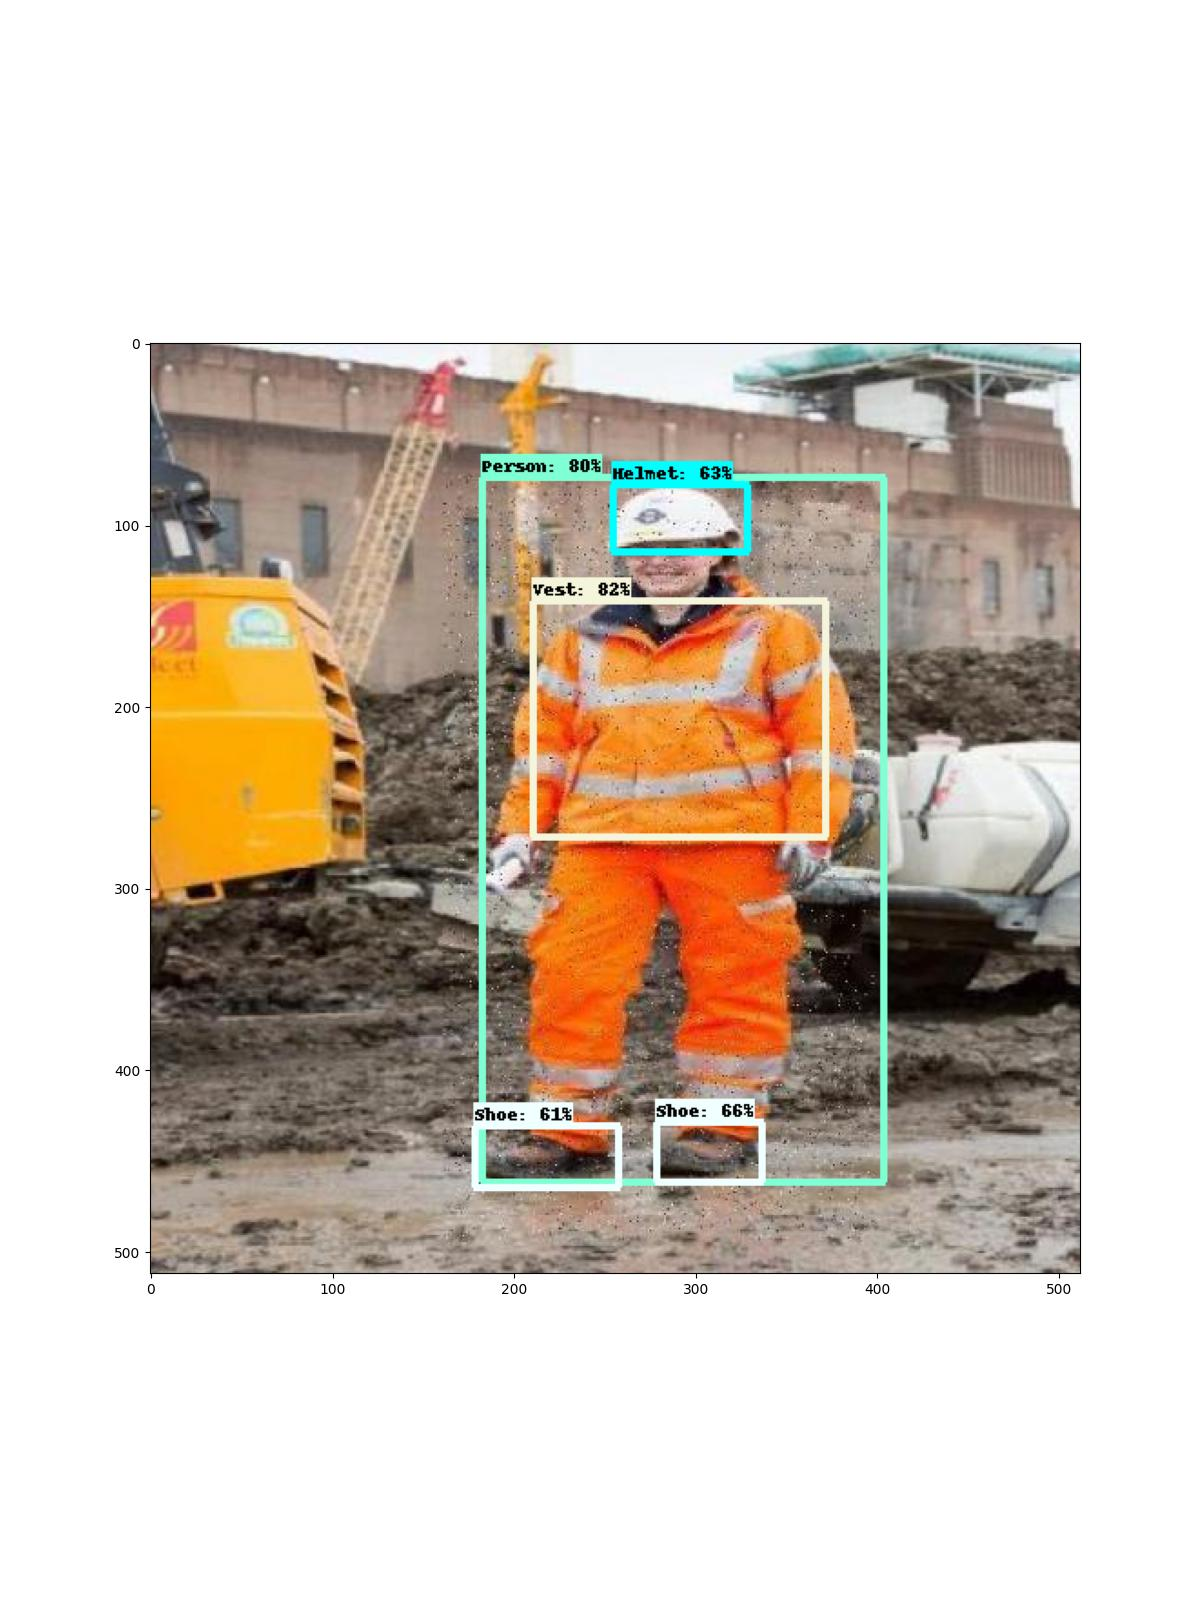

tp :  3
fp :  2
Precision: 0.6
Recall: 0.6
ground_truth_annotations_i :  ['Helmet', 'Person', 'Shoe', 'Shoe', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Person', 'Person', 'Shoe']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 2 0 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/ppe_0307_jpg.r
image_path :  /content/test_/29_jpg.rf.fe1383b312c32f66a4784bcca6373b87.jpg


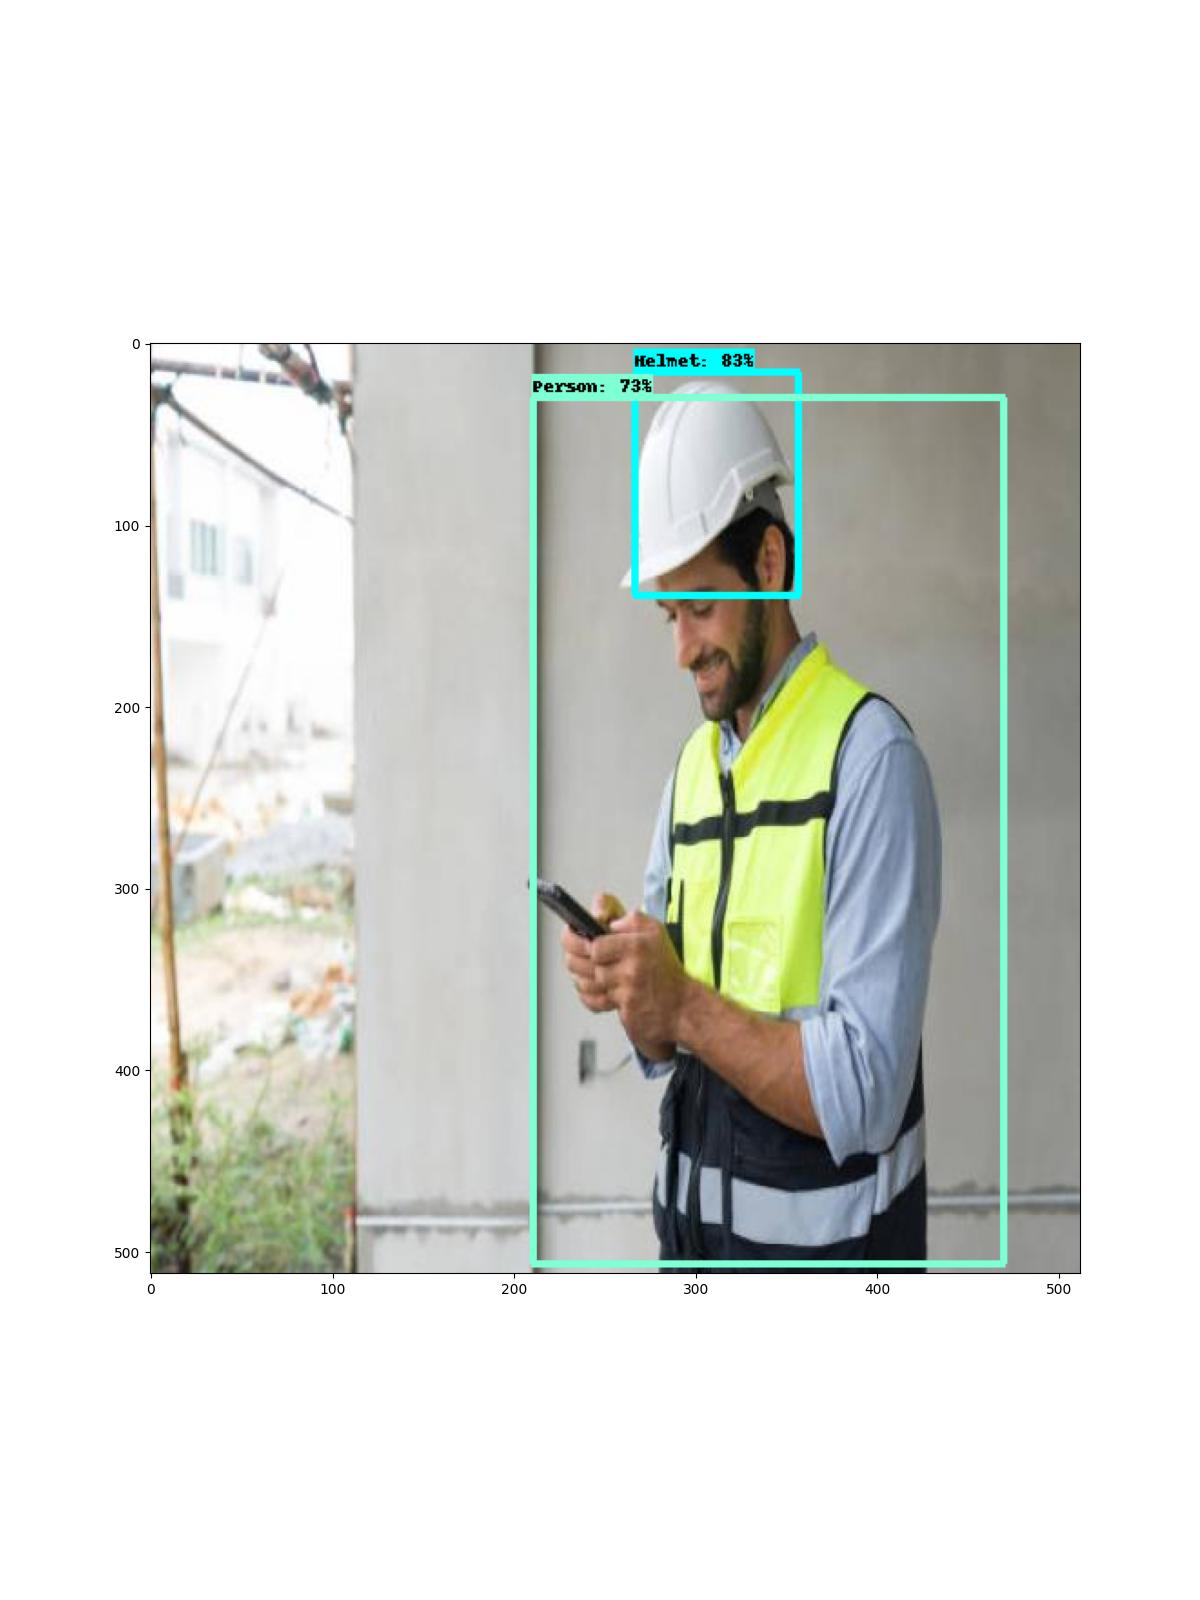

tp :  0
fp :  3
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Person', 'Shoe', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/29_jpg.rf.fe13
image_path :  /content/test_/13_jpg.rf.3e61b26a672c4e7468913628901b3add.jpg


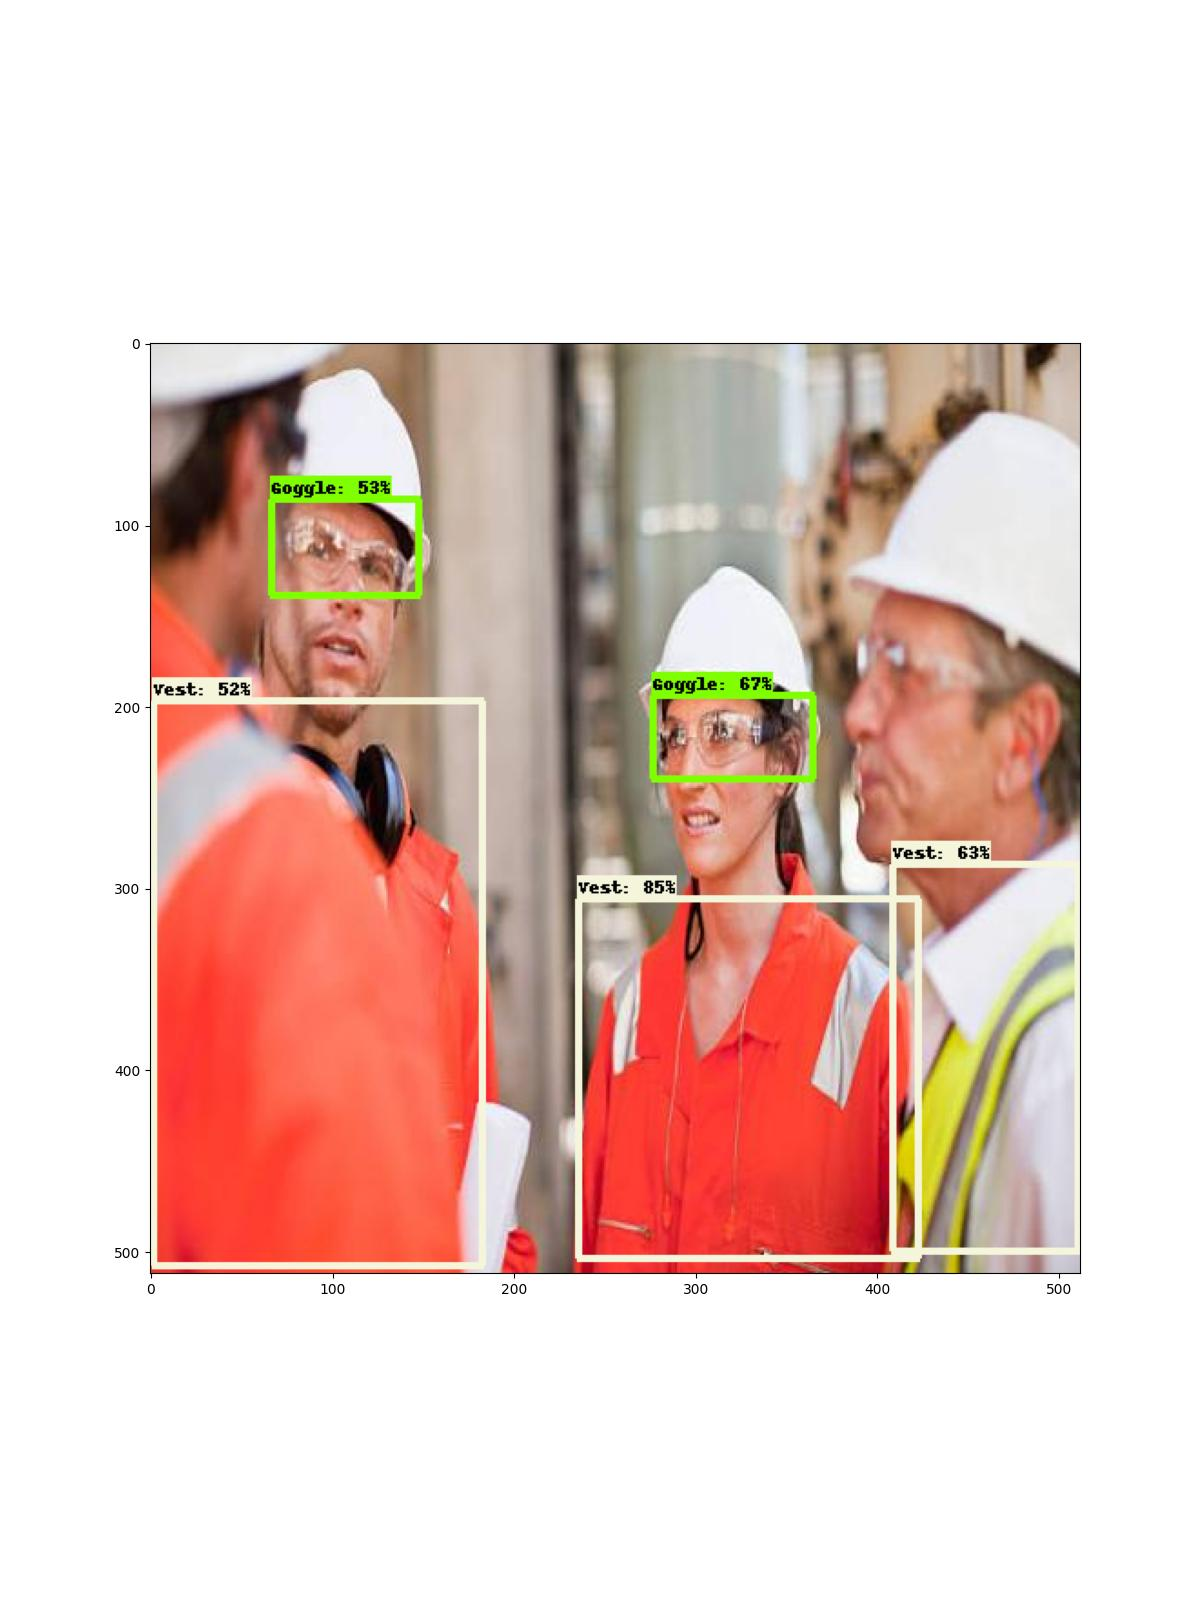

tp :  11
fp :  4
Precision: 0.7333333333333333
Recall: 0.7333333333333333
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[3 0 0 0 0]
 [0 4 0 0 0]
 [0 0 3 0 1]
 [0 0 0 0 0]
 [0 0 0 0 4]]
/content/raw_test_image_output/13_jpg.rf.3e61
image_path :  /content/test_/36_jpg.rf.5c3439e42280ead4262c5faf91638bfd.jpg


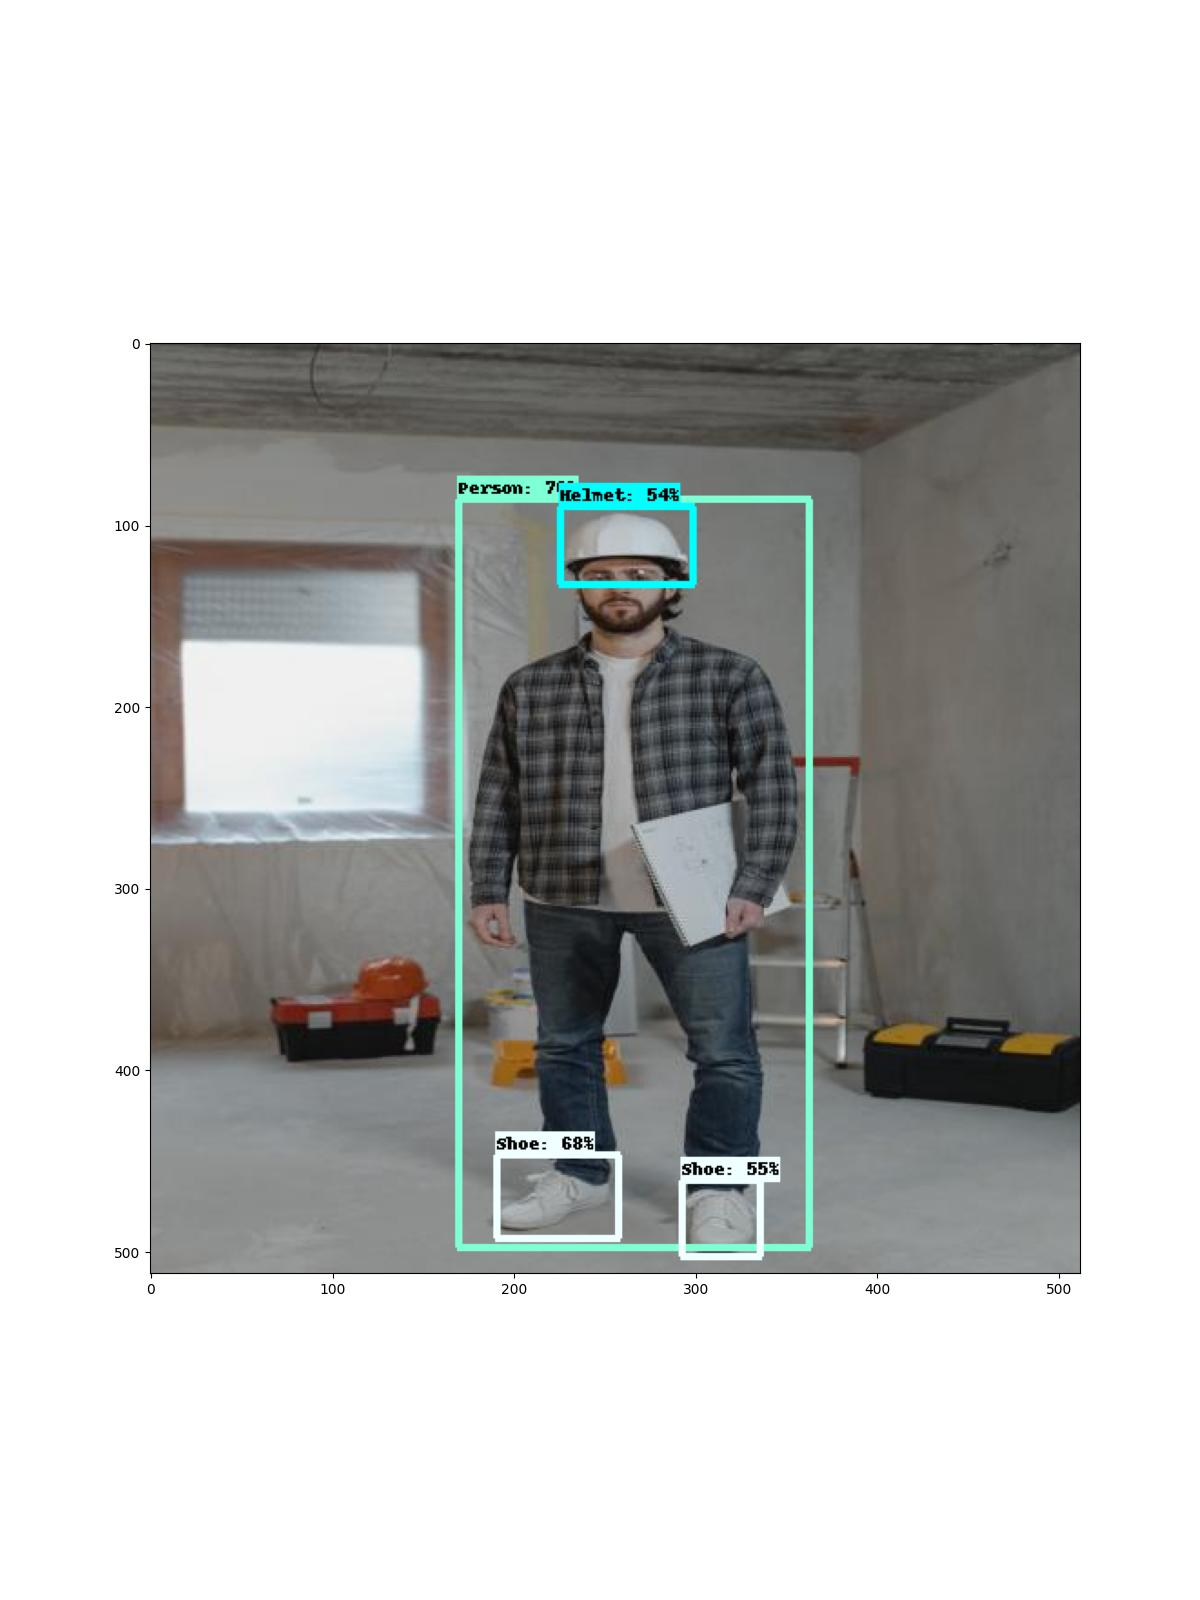

tp :  3
fp :  2
Precision: 0.6
Recall: 0.6
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Shoe', 'Shoe']
predicted_labels :  ['Helmet', 'Person', 'Shoe', 'Shoe', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 2 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/36_jpg.rf.5c34
image_path :  /content/test_/5_webp.rf.191732e32fe16bc6f2d6ffa9ca10c288.jpg


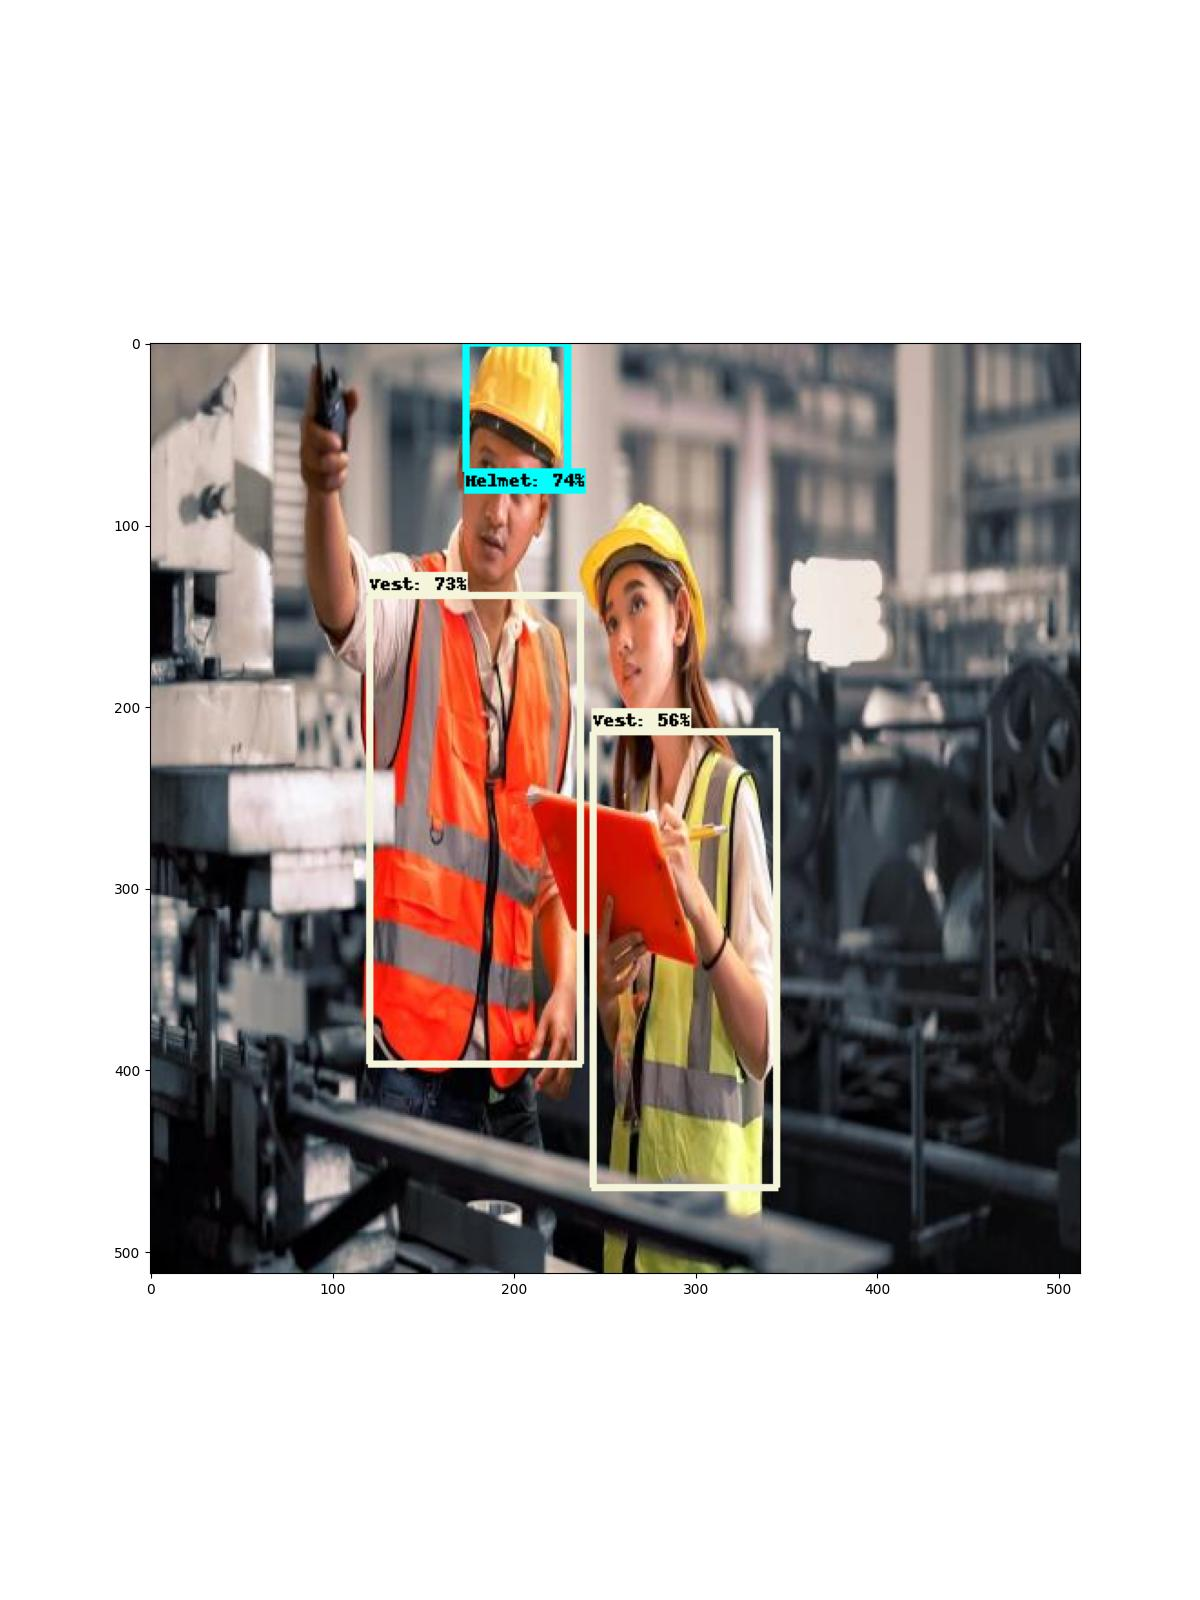

tp :  2
fp :  4
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Helmet', 'Helmet', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Vest', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 1 0 0]
 [0 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 2]]
/content/raw_test_image_output/5_webp.rf.1917
image_path :  /content/test_/35_jpg.rf.e32534be2e26d36d0f23c01b0aaee780.jpg


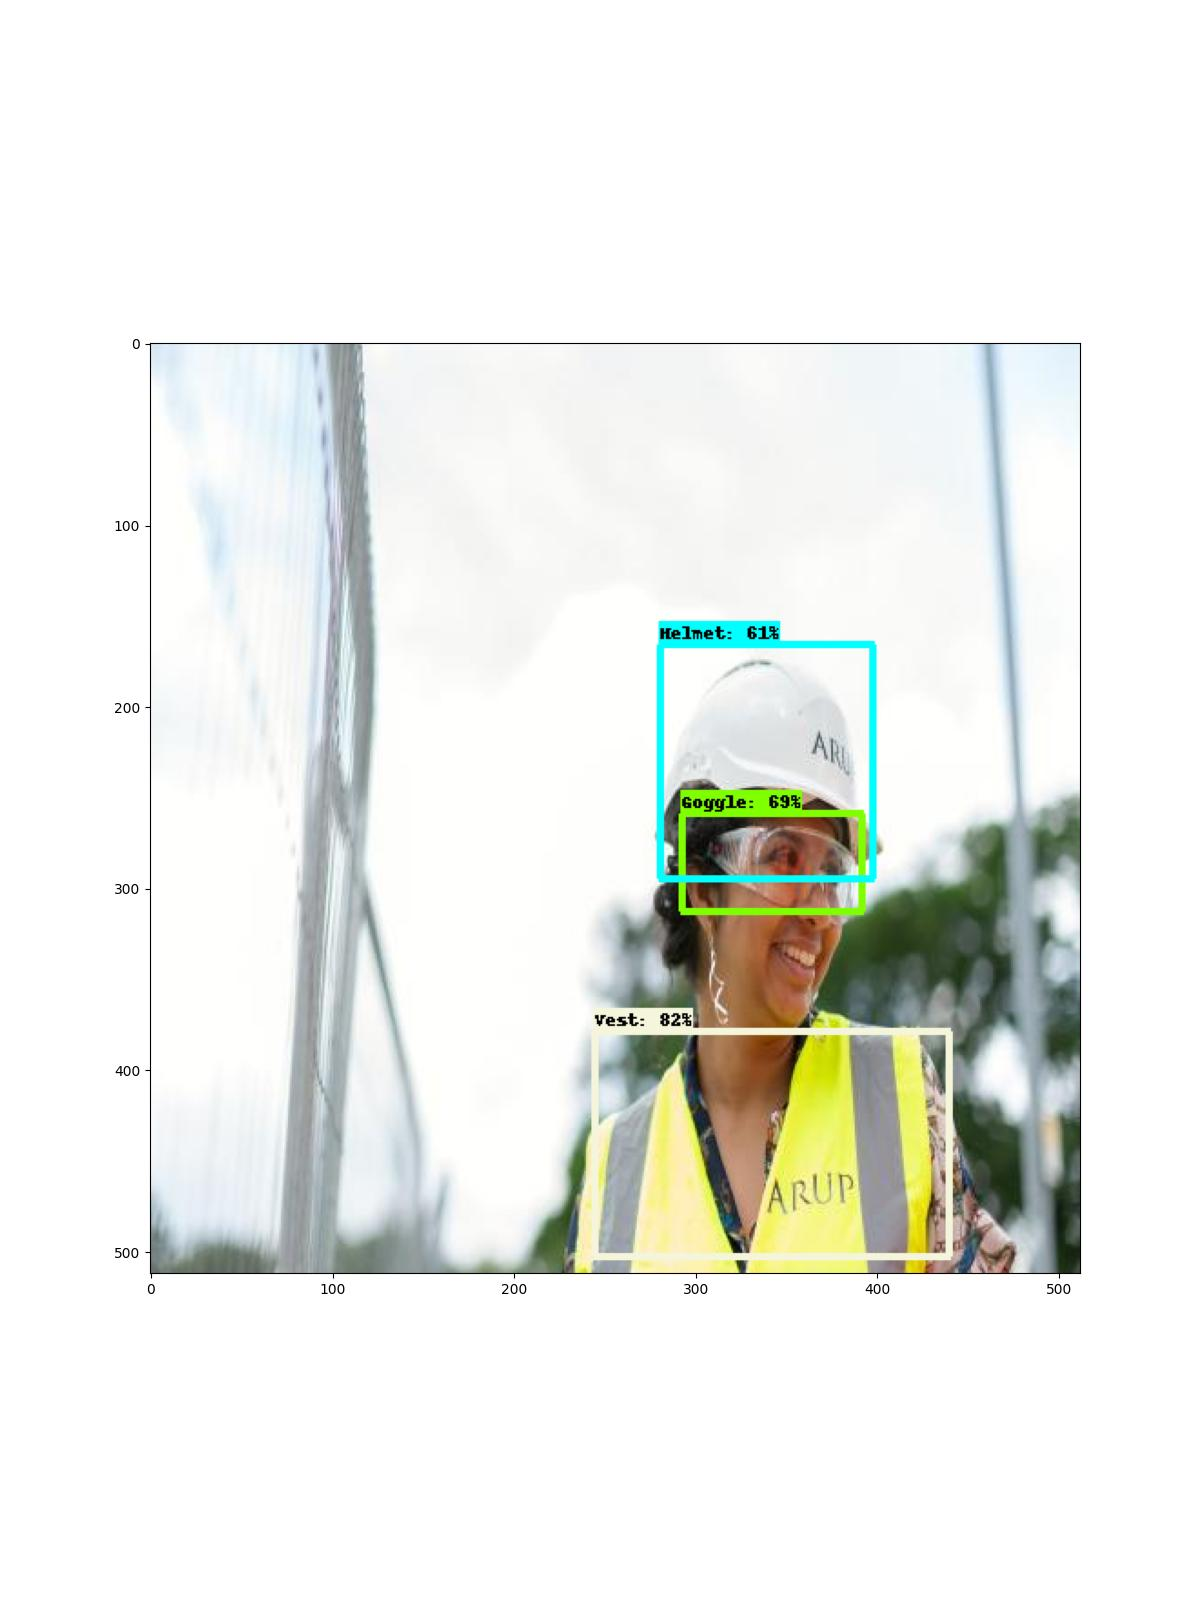

tp :  2
fp :  2
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Helmet', 'Person', 'Person']
Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
/content/raw_test_image_output/35_jpg.rf.e325
image_path :  /content/test_/26_jpg.rf.229c8192d47c29f6c077bc293ed99962.jpg


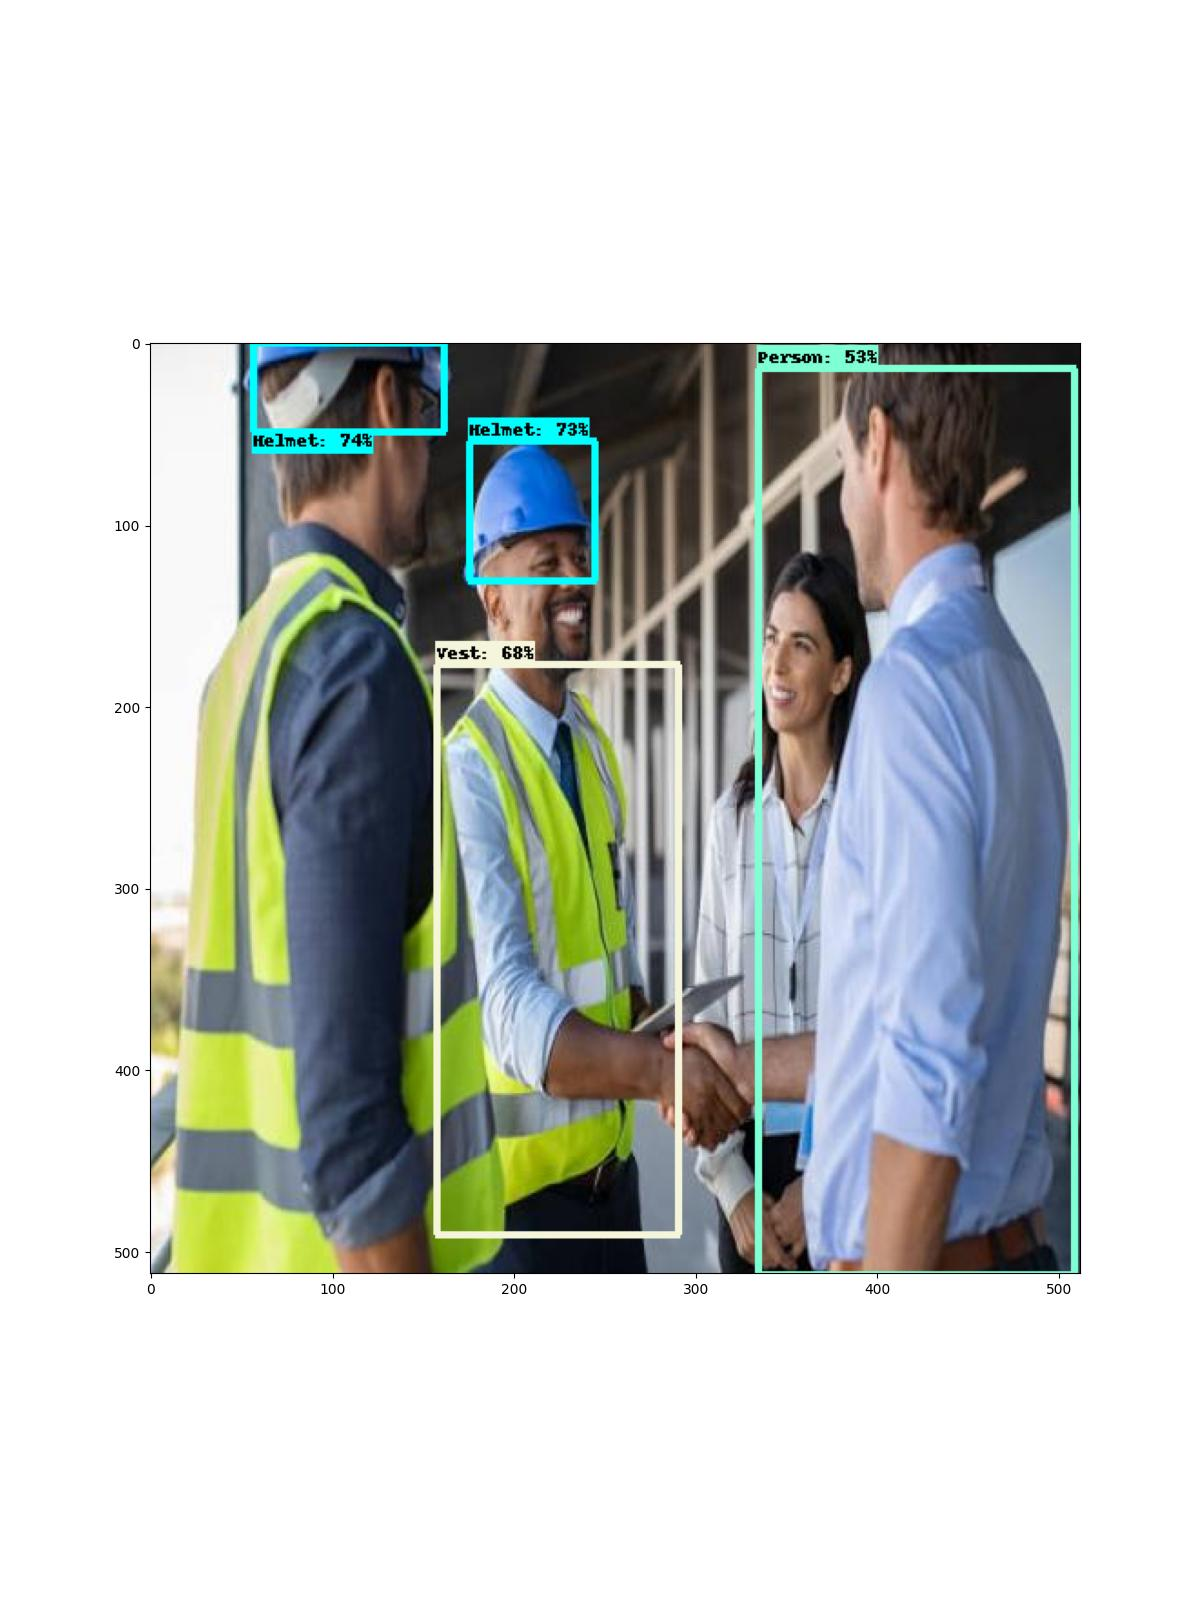

tp :  5
fp :  3
Precision: 0.625
Recall: 0.625
ground_truth_annotations_i :  ['Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 1]
 [0 0 0 0 0]
 [0 0 0 0 2]]
/content/raw_test_image_output/26_jpg.rf.229c
image_path :  /content/test_/22_jpg.rf.0ca078cb9aea50b014e058693b413634.jpg


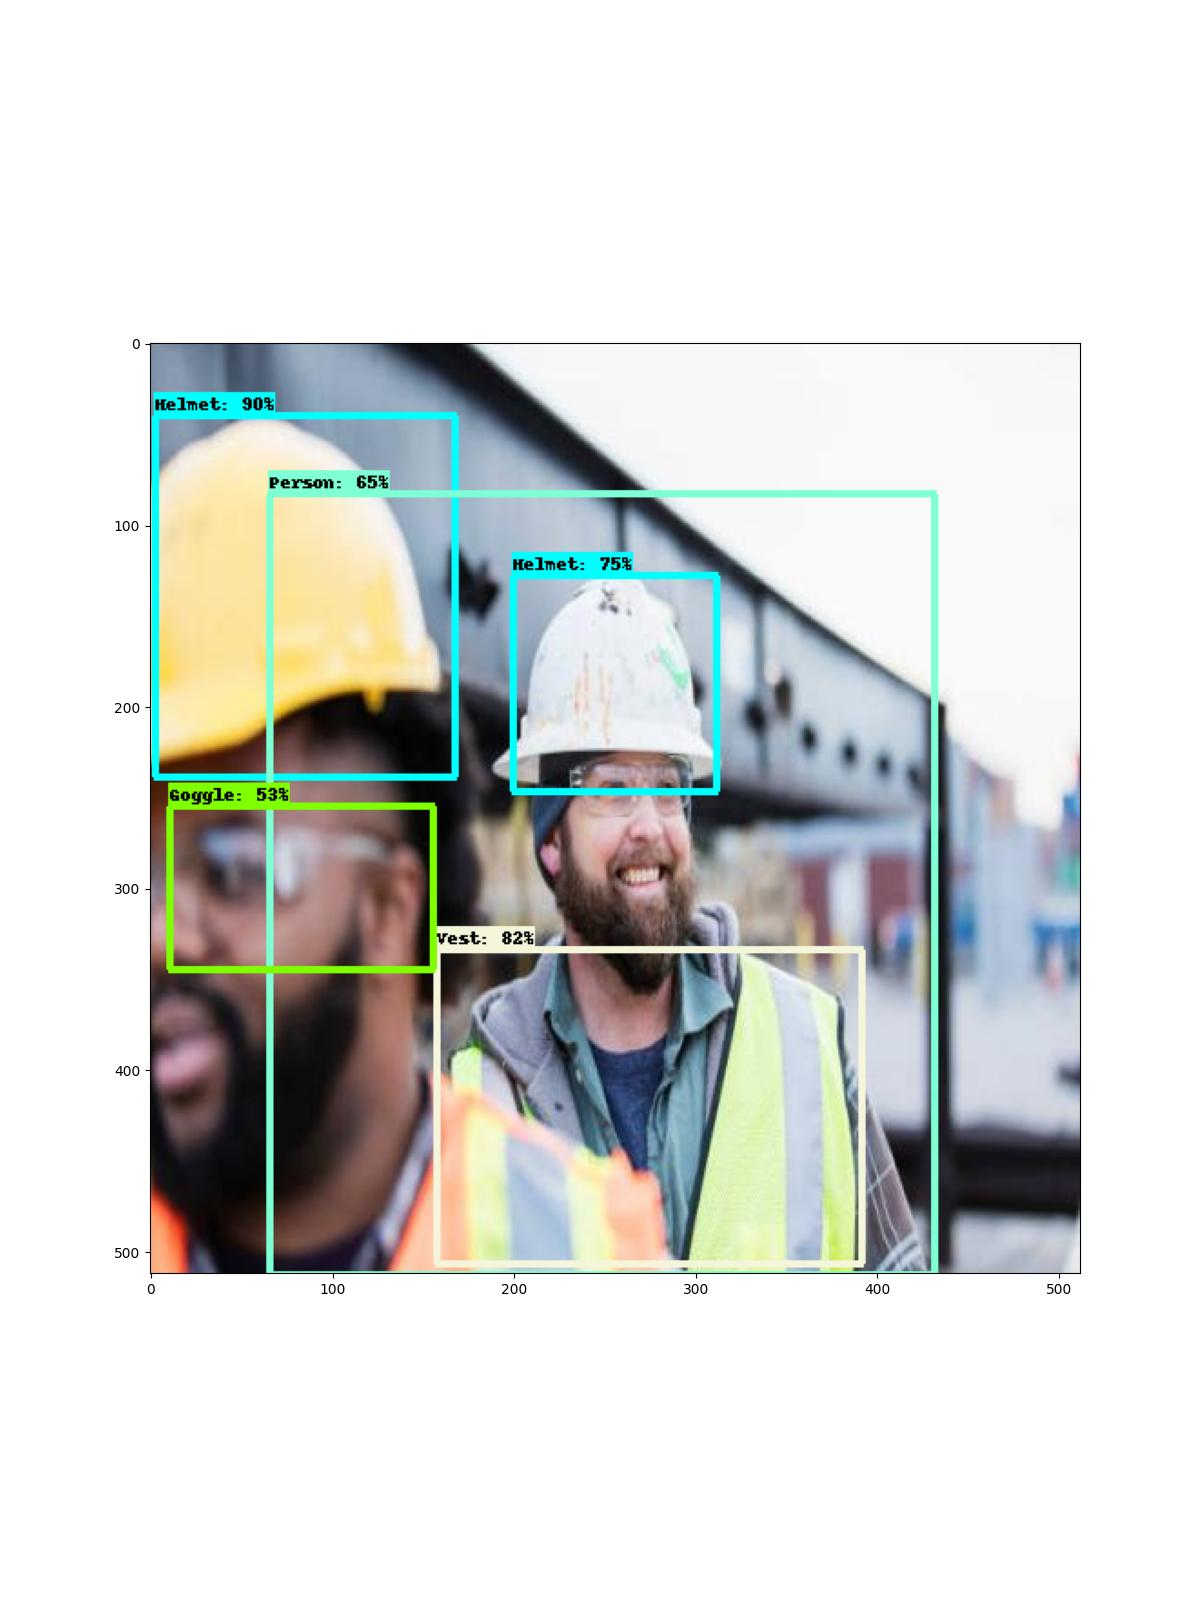

tp :  5
fp :  3
Precision: 0.625
Recall: 0.625
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 2]]
/content/raw_test_image_output/22_jpg.rf.0ca0
image_path :  /content/test_/38_png.rf.09a44607aebc2043d29140d22c79b819.jpg


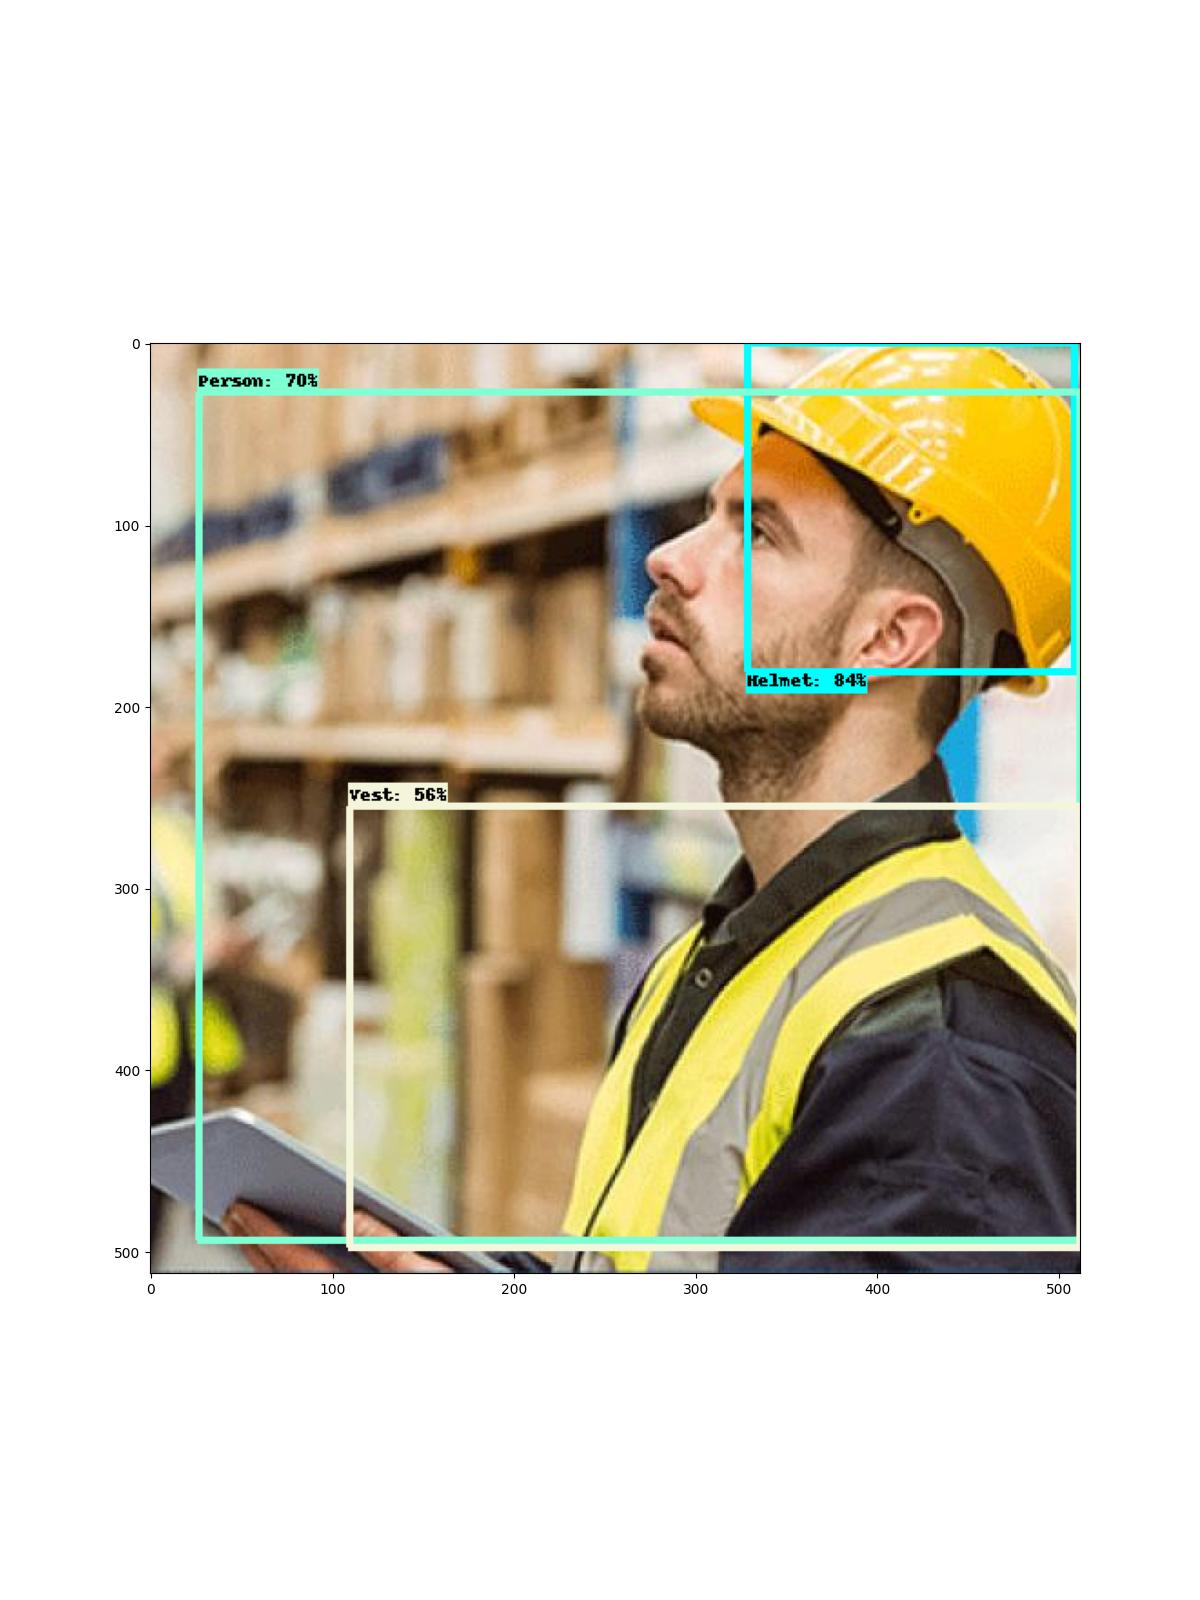

tp :  2
fp :  1
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Person', 'Shoe', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/38_png.rf.09a4
image_path :  /content/test_/imagem18_jpg.rf.8831c23df0ea714d2a57bb6ba9544479.jpg


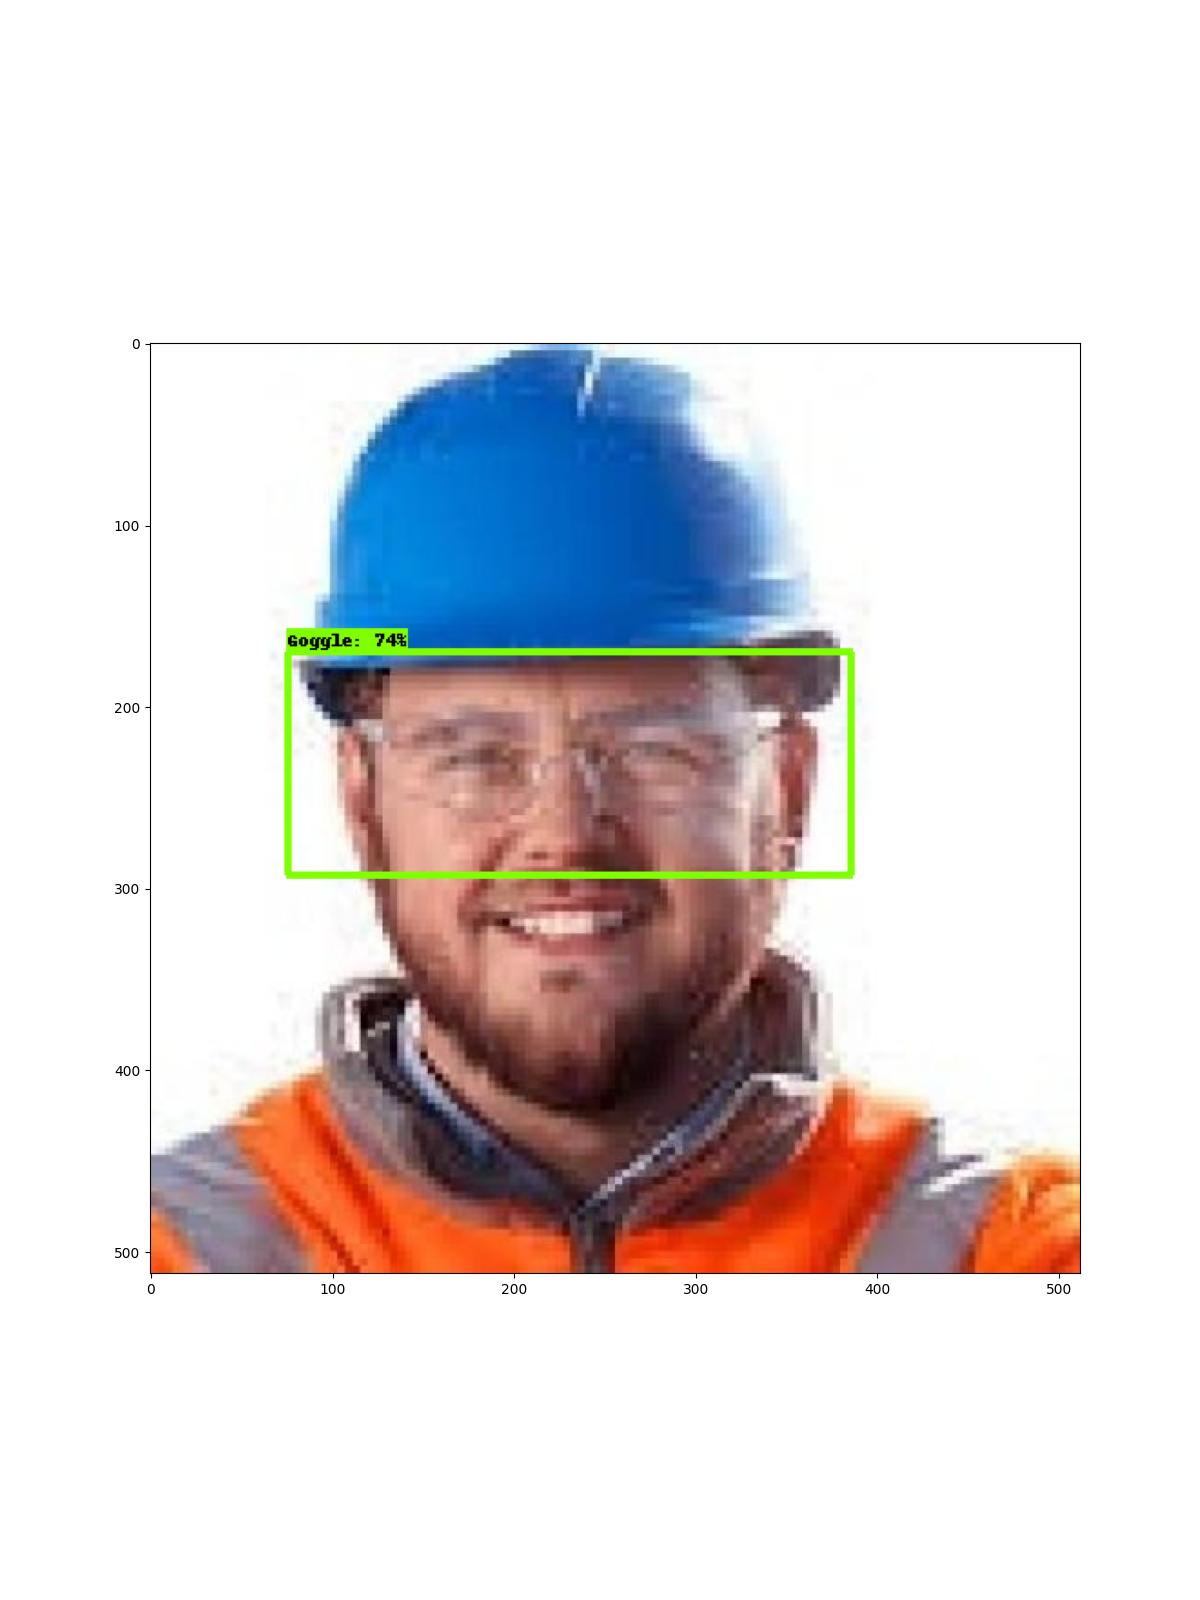

tp :  0
fp :  3
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Goggle', 'Person', 'Vest']
predicted_labels :  ['Helmet', 'Person', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/imagem18_jpg.r
image_path :  /content/test_/7_webp.rf.896fb2e85939cfc4c44fe2ec72e1b072.jpg


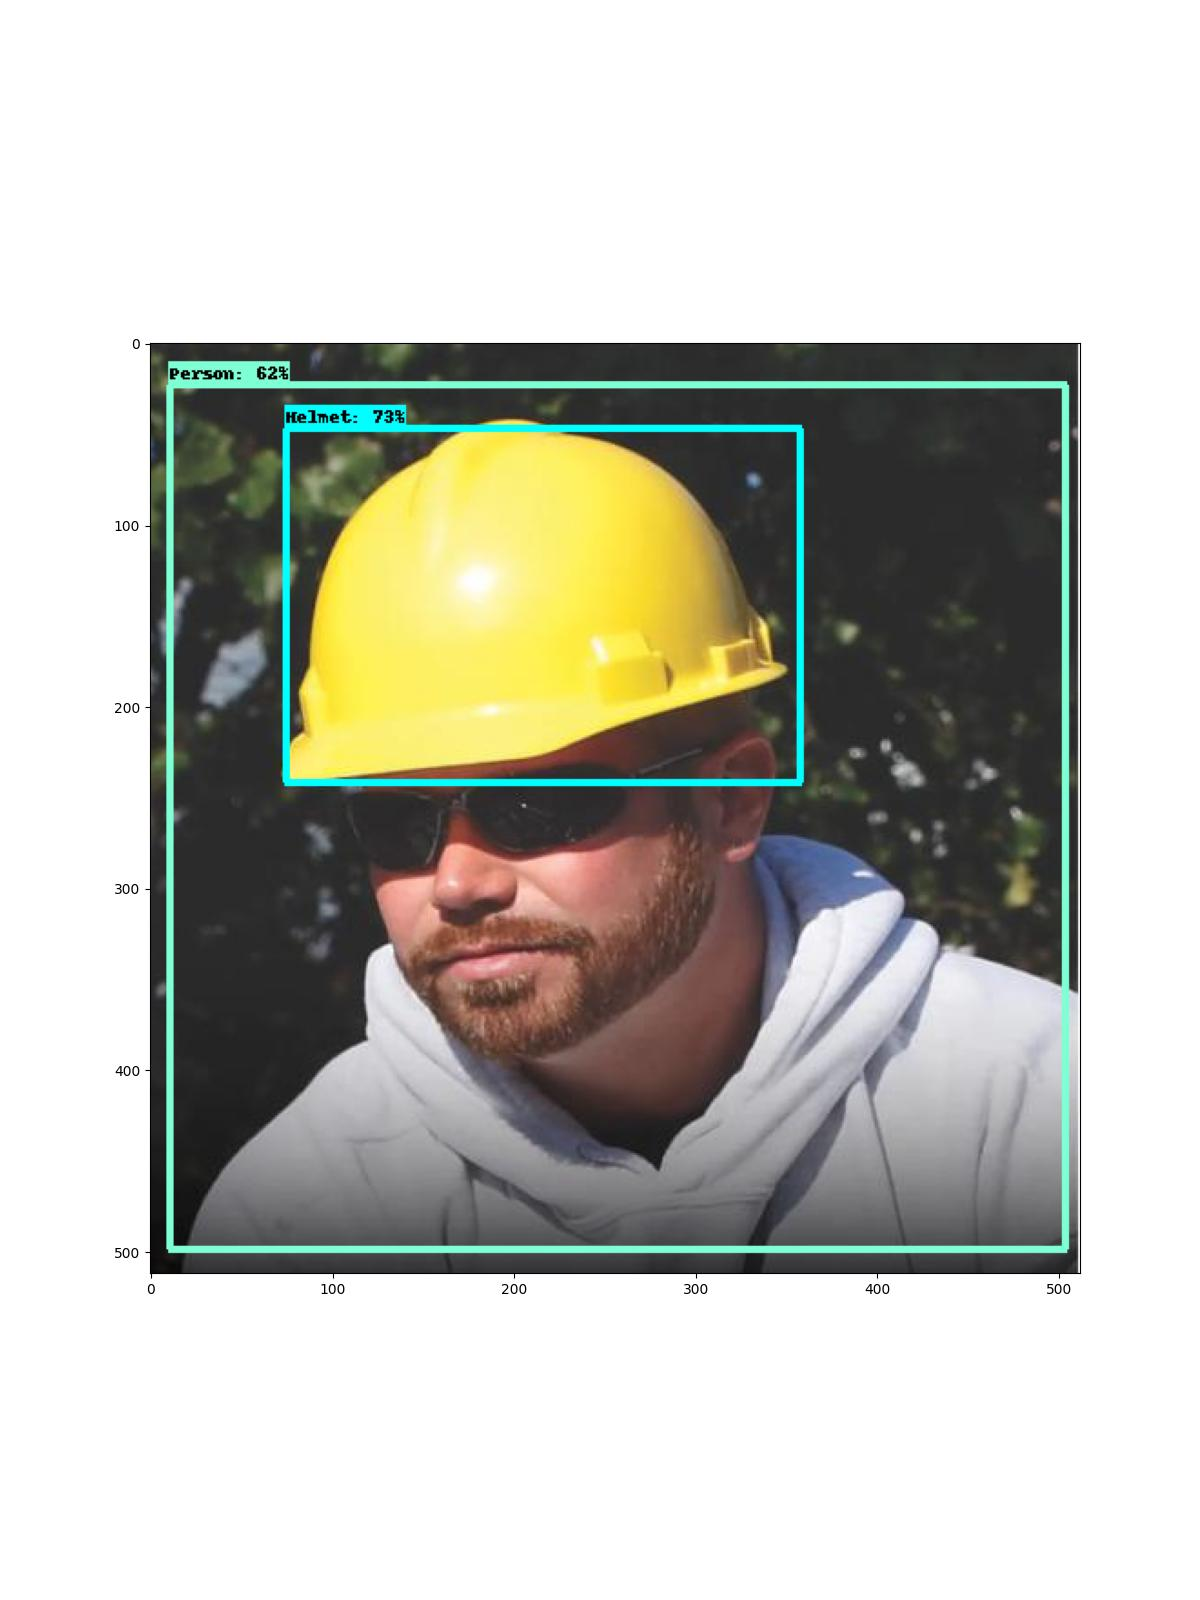

tp :  1
fp :  0
Precision: 1.0
Recall: 1.0
ground_truth_annotations_i :  ['Helmet']
predicted_labels :  ['Helmet']
Confusion Matrix:
[[0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/7_webp.rf.896f
image_path :  /content/test_/18_jpg.rf.a9409c66f47820bdddf0ad49a804dde6.jpg


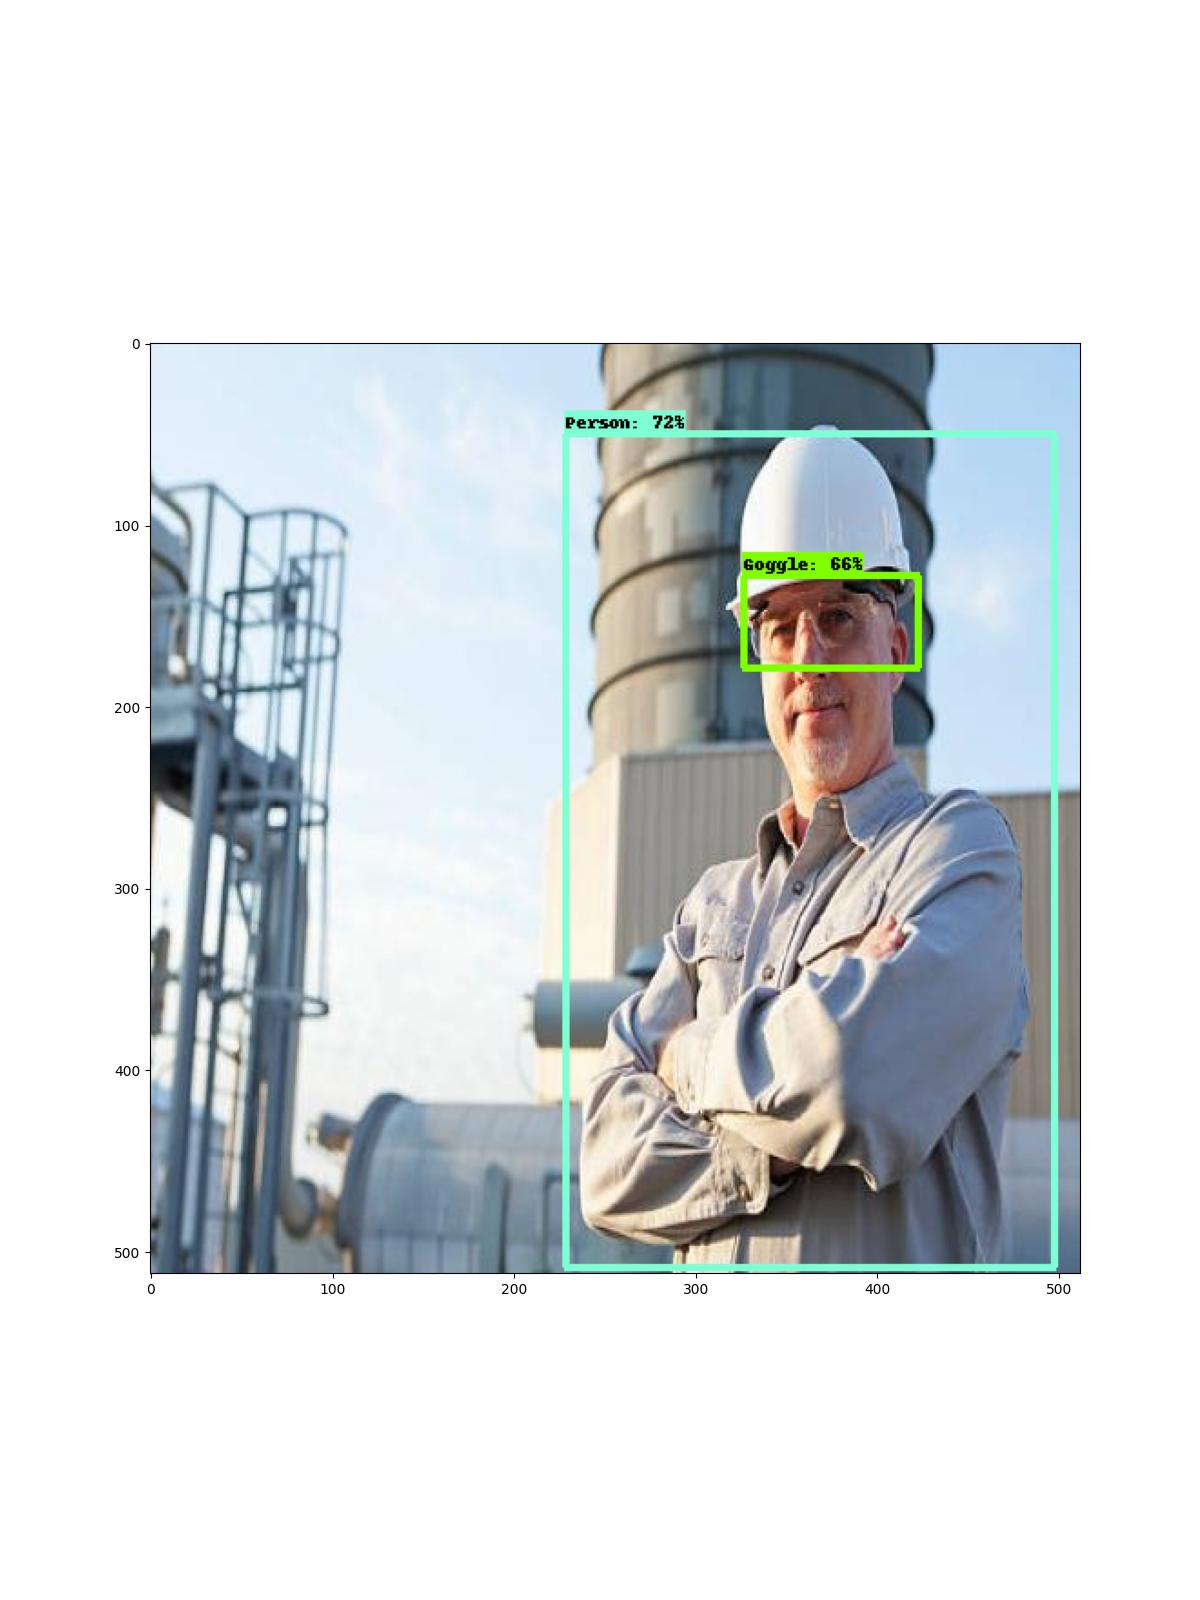

tp :  1
fp :  1
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Helmet']
predicted_labels :  ['Helmet', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/18_jpg.rf.a940
image_path :  /content/test_/23_jpg.rf.47879280e30dd6f3d854e5e9a994fb7c.jpg


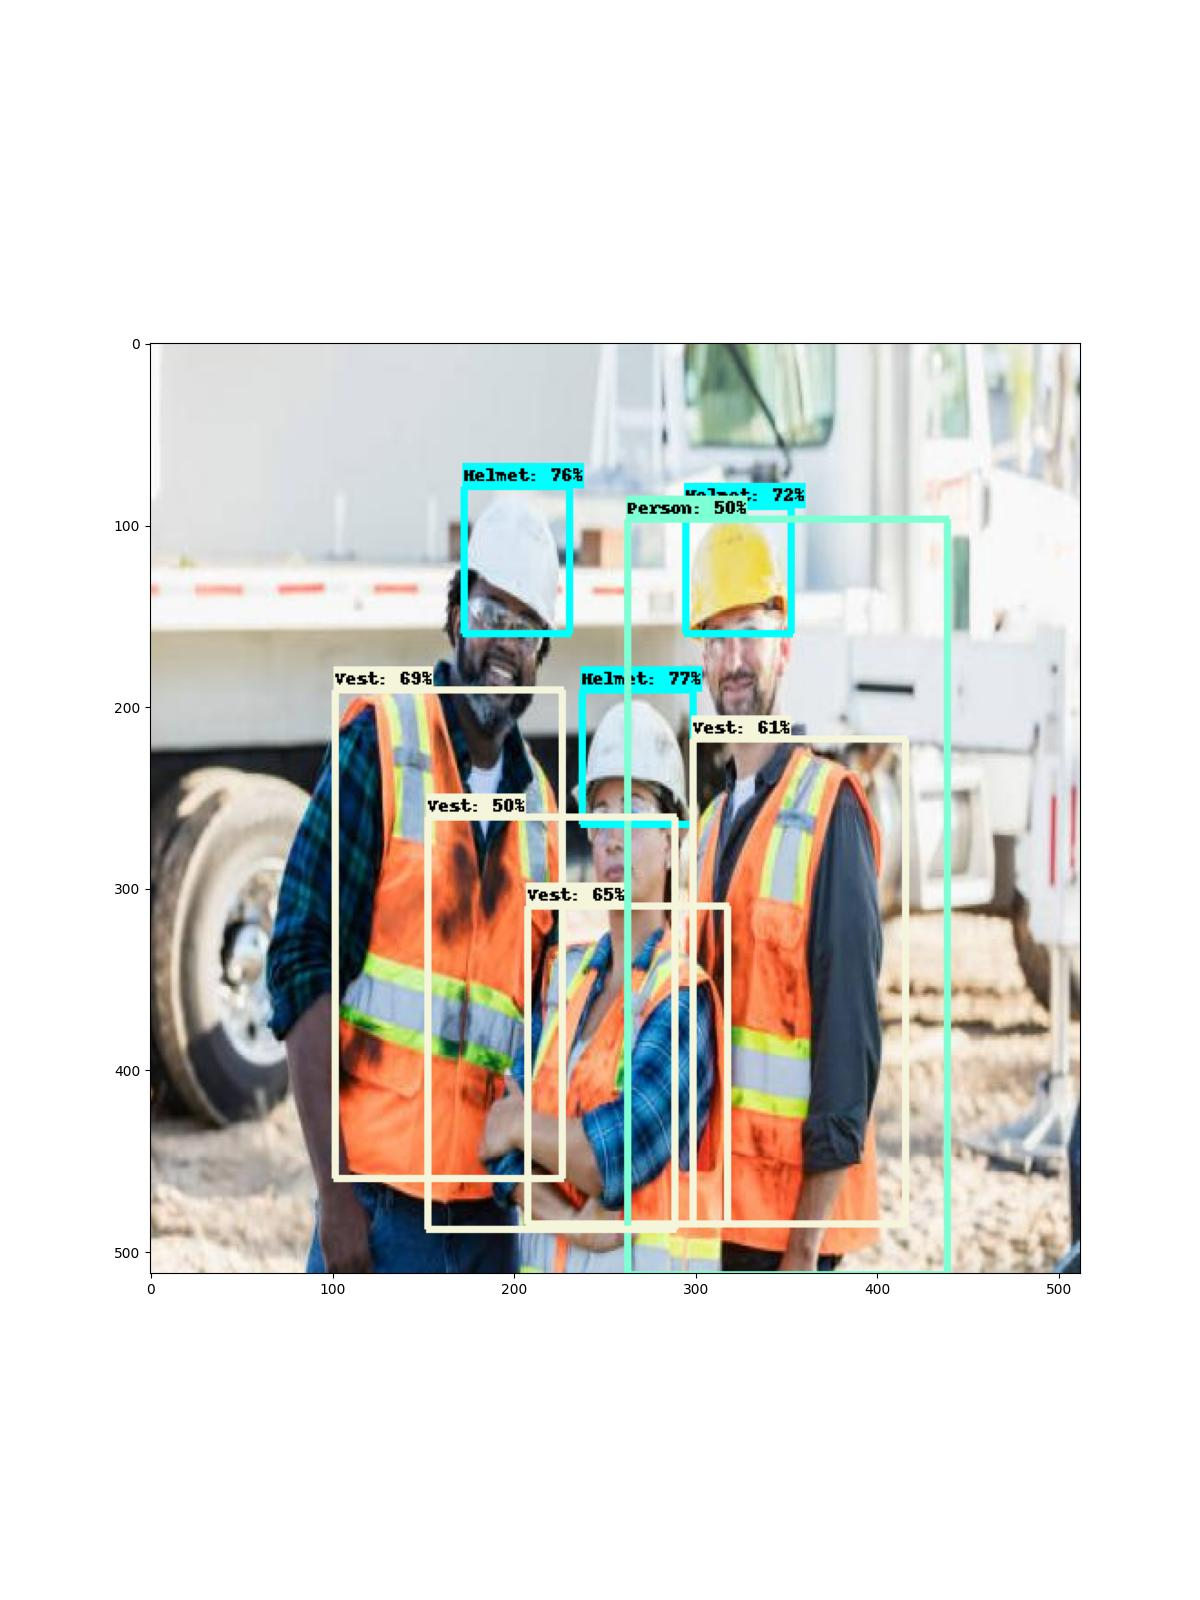

tp :  7
fp :  5
Precision: 0.5833333333333334
Recall: 0.5833333333333334
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Vest', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[3 0 0 0 0]
 [1 2 0 0 0]
 [0 1 2 0 0]
 [0 0 0 0 0]
 [0 0 0 0 3]]
/content/raw_test_image_output/23_jpg.rf.4787
image_path :  /content/test_/6_png.rf.7935153b94f44b8df7e04fb5040c7b68.jpg


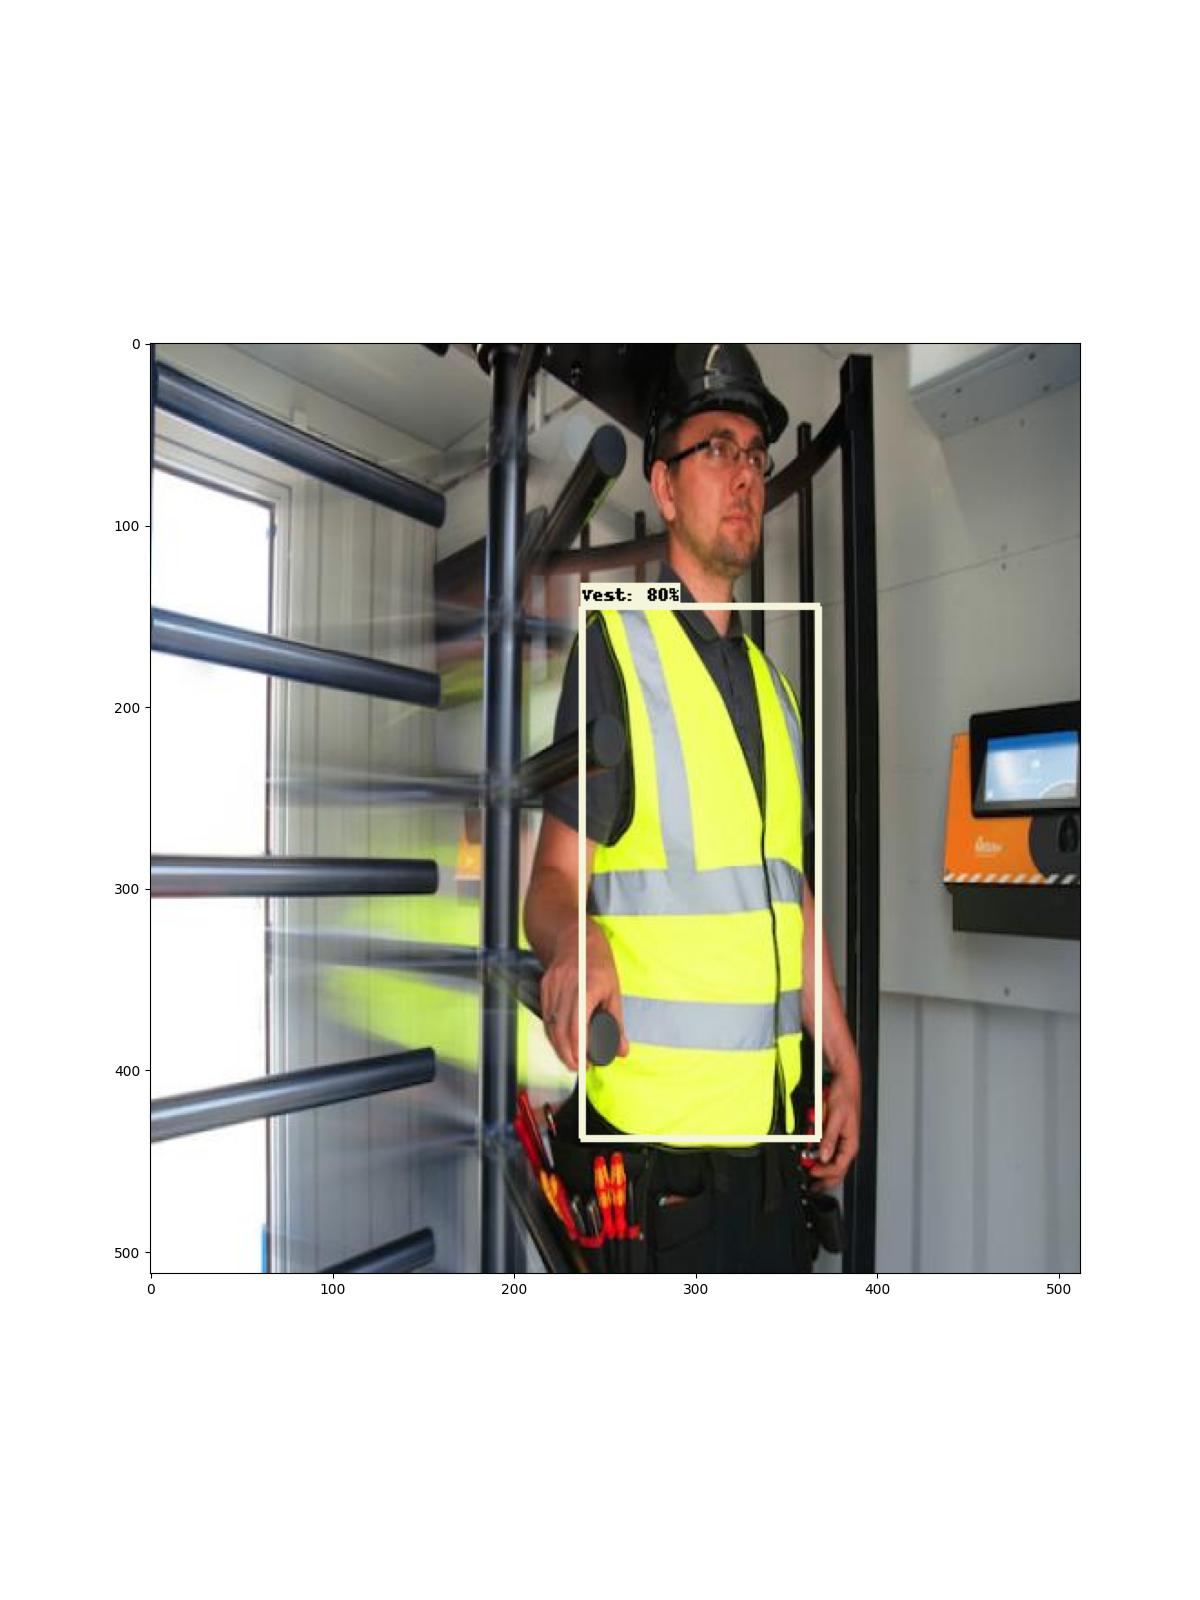

tp :  1
fp :  2
Precision: 0.3333333333333333
Recall: 0.3333333333333333
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/6_png.rf.79351
image_path :  /content/test_/8_jpg.rf.b92b3ee50deefa54ec95ad8c158298a1.jpg


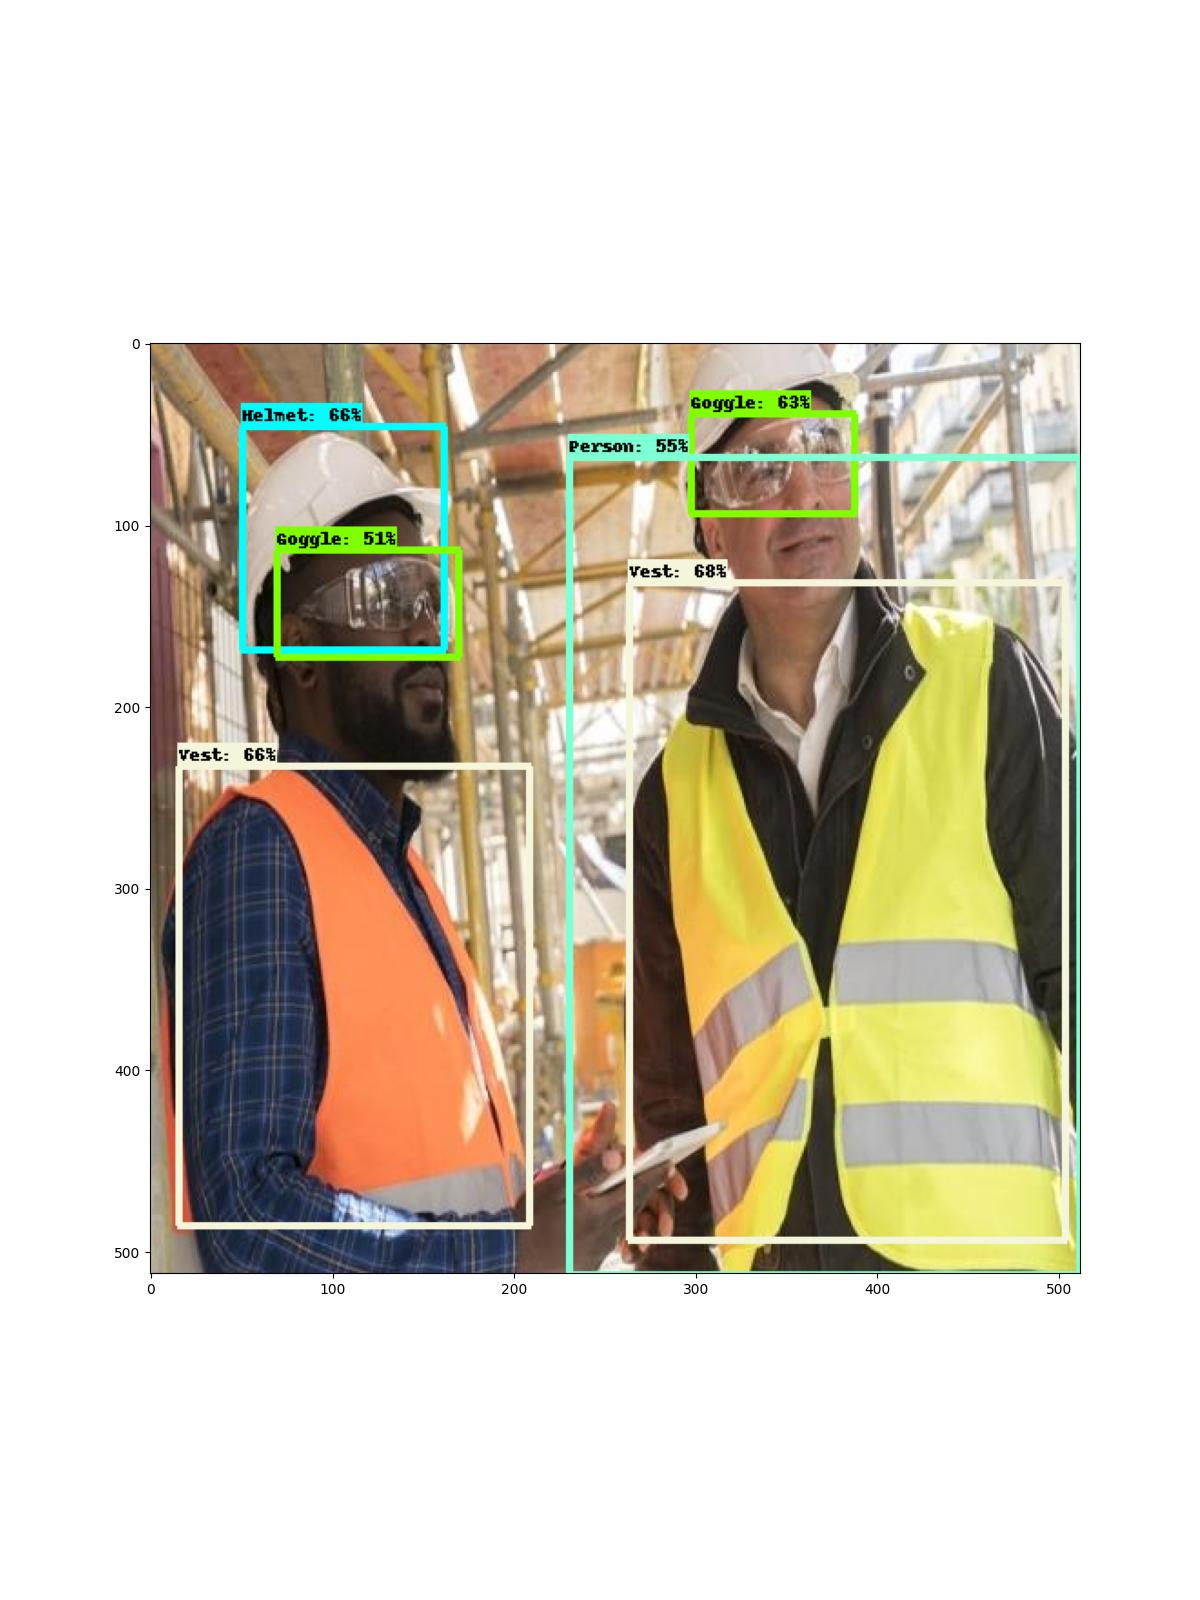

tp :  4
fp :  4
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Person', 'Person', 'Person', 'Vest']
Confusion Matrix:
[[2 0 0 0 0]
 [1 1 0 0 0]
 [0 0 2 0 0]
 [0 0 0 0 0]
 [0 0 1 0 1]]
/content/raw_test_image_output/8_jpg.rf.b92b3
image_path :  /content/test_/25_jpg.rf.7a8d58d1a470a5c821e9d74b05b98f9f.jpg


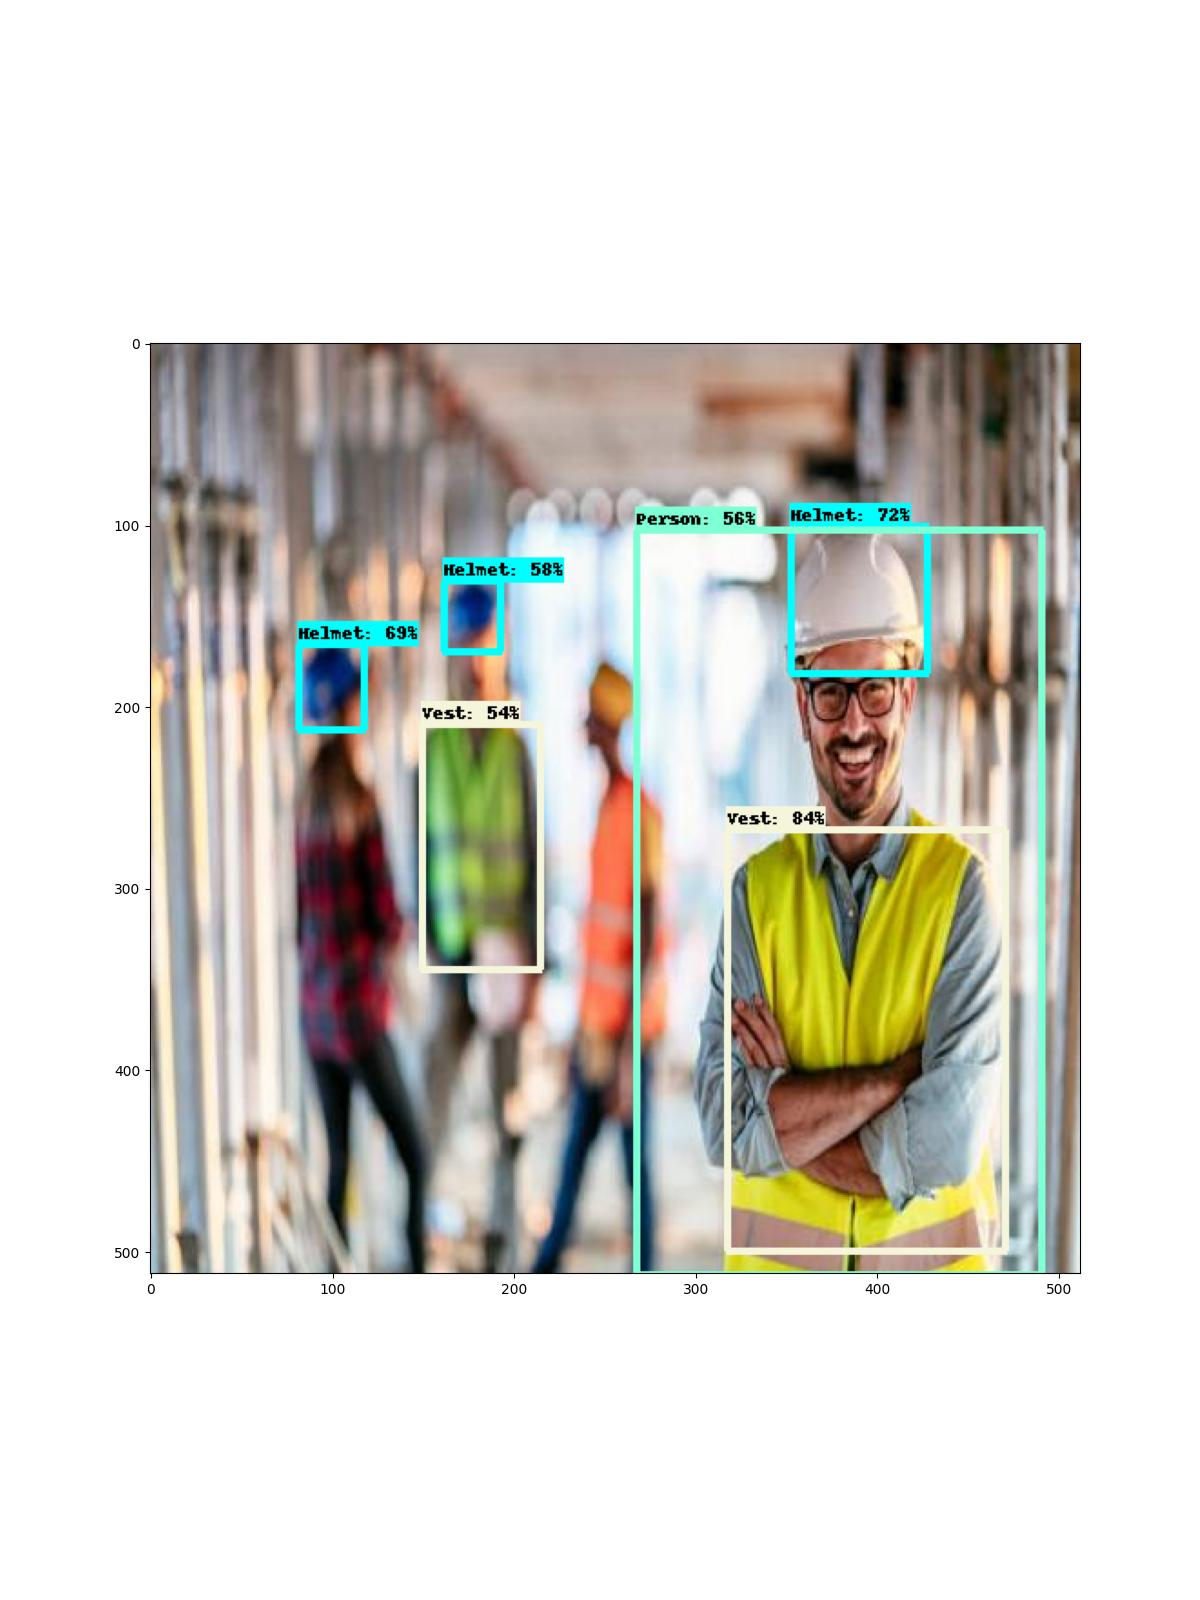

tp :  5
fp :  3
Precision: 0.625
Recall: 0.625
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Vest', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Helmet', 'Helmet', 'Person', 'Vest', 'Vest', 'Vest', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 2 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 3]]
/content/raw_test_image_output/25_jpg.rf.7a8d
image_path :  /content/test_/3_jpg.rf.c7cd152c864c65d48c42e8a4ea7af357.jpg


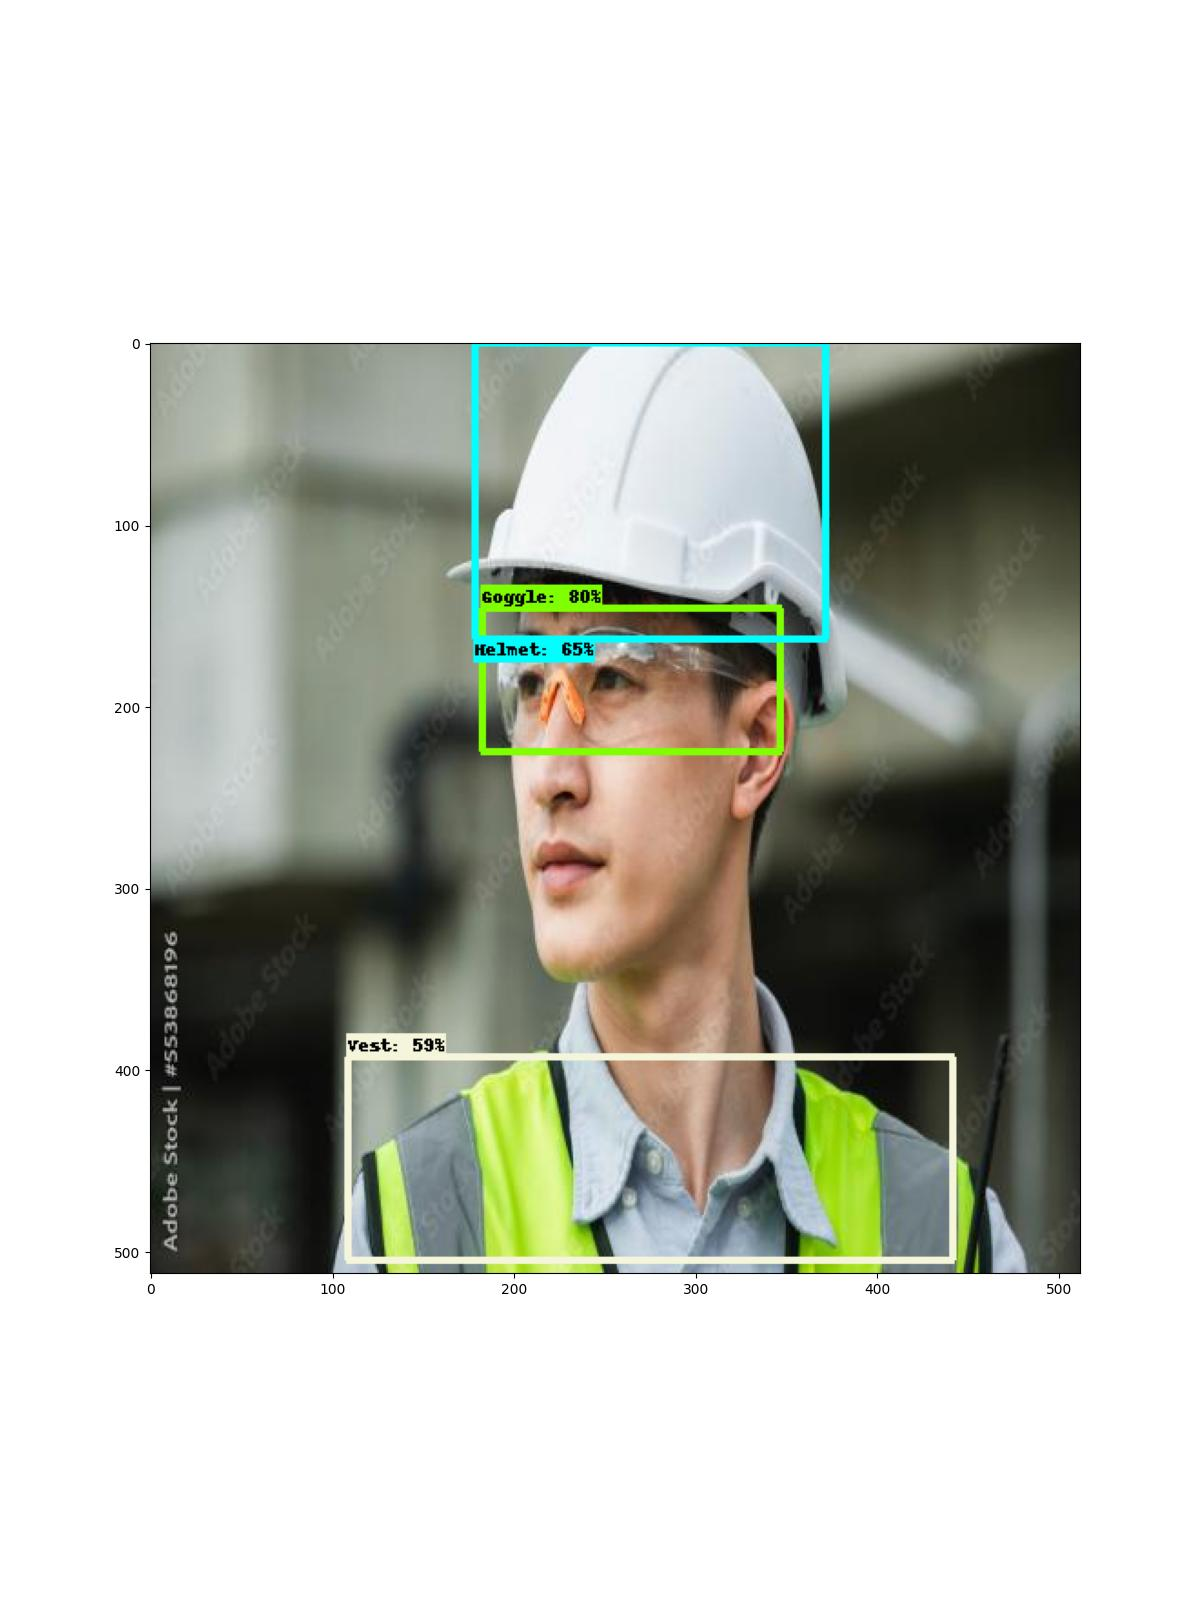

tp :  0
fp :  4
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Helmet', 'Shoe', 'Shoe', 'Shoe']
Confusion Matrix:
[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/3_jpg.rf.c7cd1
image_path :  /content/test_/1_webp.rf.24a400d72652b6f067eb8288434980f7.jpg


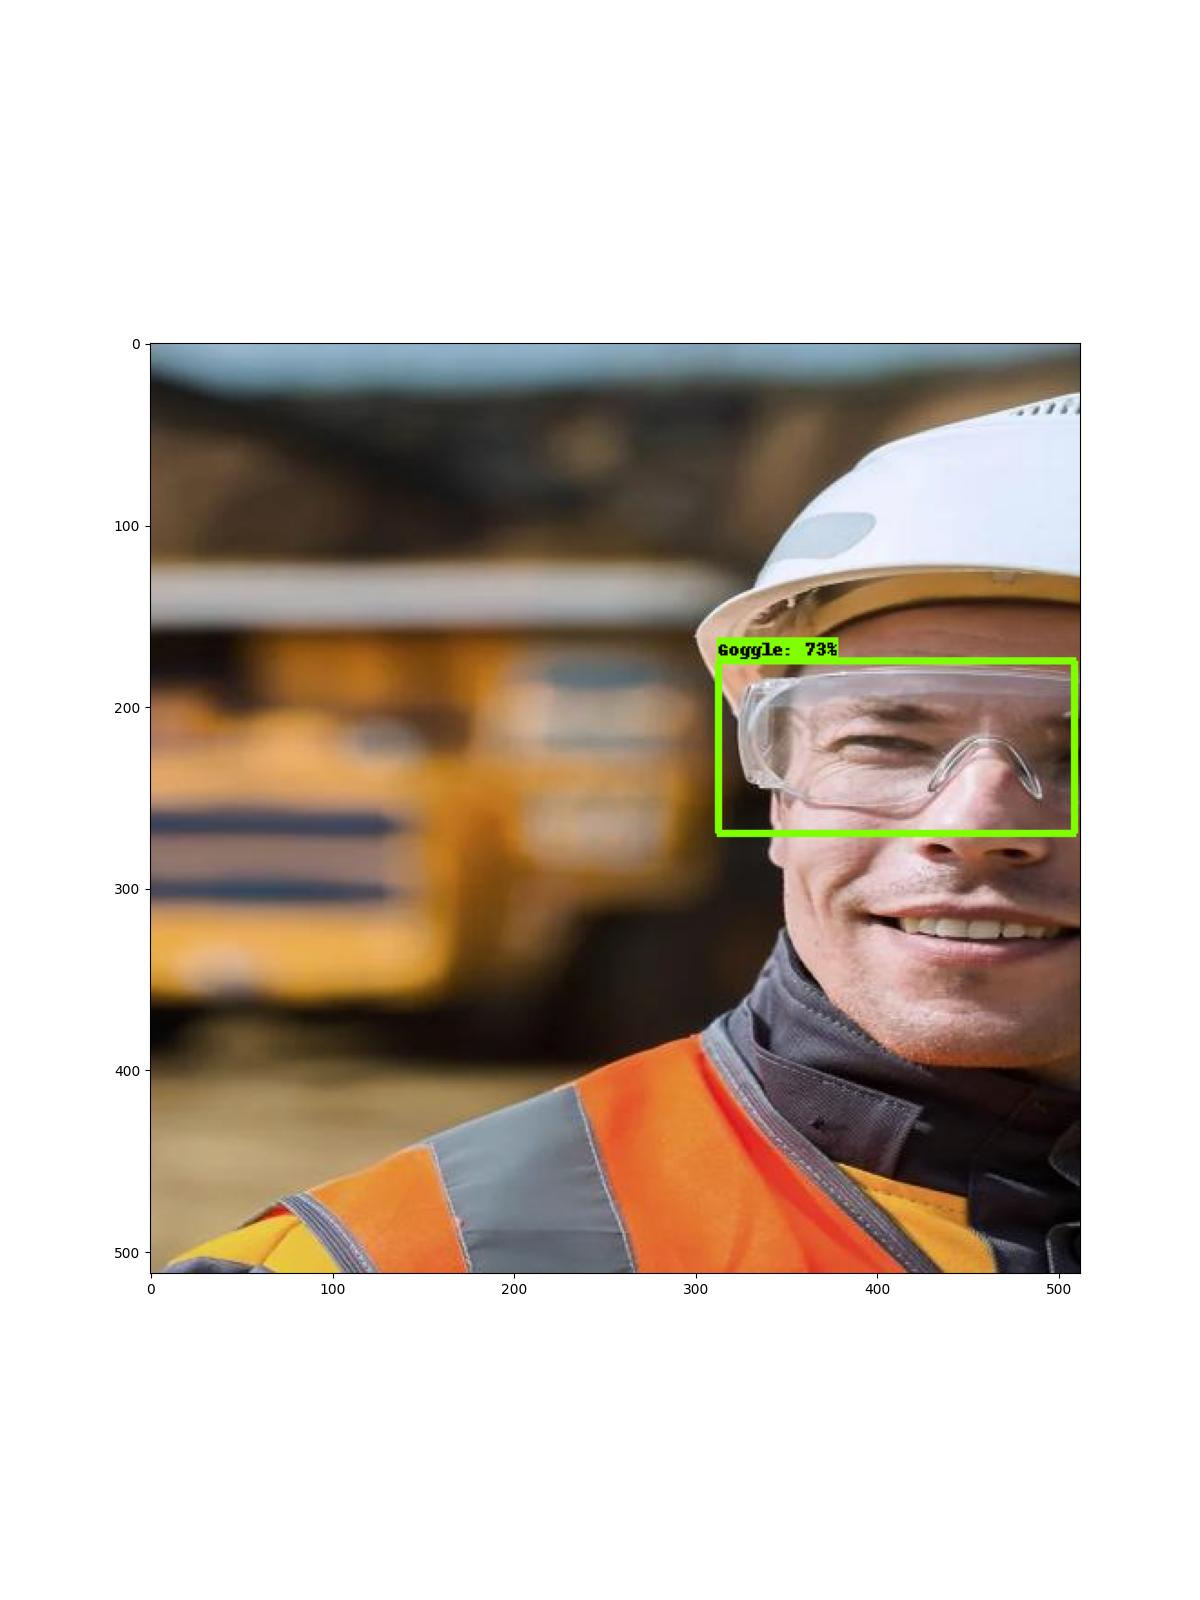

tp :  2
fp :  2
Precision: 0.5
Recall: 0.5
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Helmet', 'Helmet', 'Person', 'Person']
Confusion Matrix:
[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
/content/raw_test_image_output/1_webp.rf.24a4
image_path :  /content/test_/37_webp.rf.a0504d58d7e66c5e38d65b4fc6dfb14e.jpg


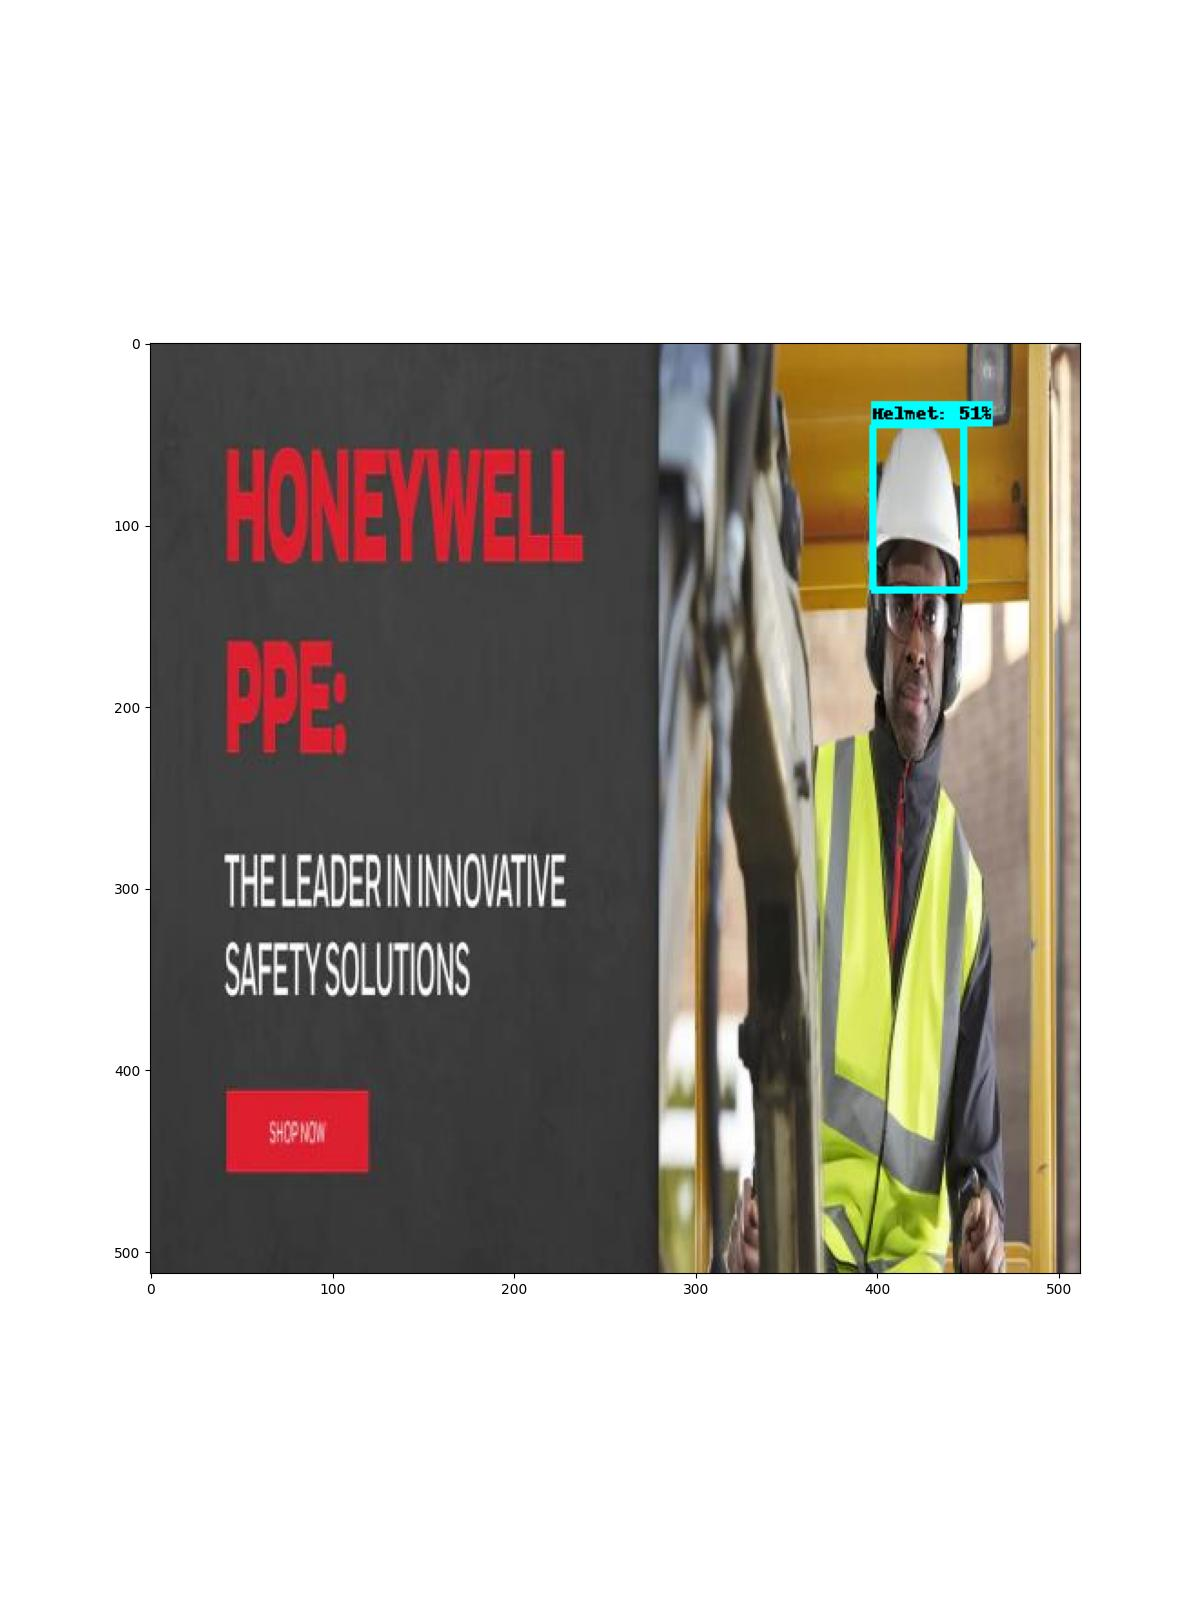

tp :  4
fp :  0
Precision: 1.0
Recall: 1.0
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Helmet', 'Person', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/37_webp.rf.a05
image_path :  /content/test_/2_jpg.rf.896bc93ce23b779d5b67315d179d6ffd.jpg


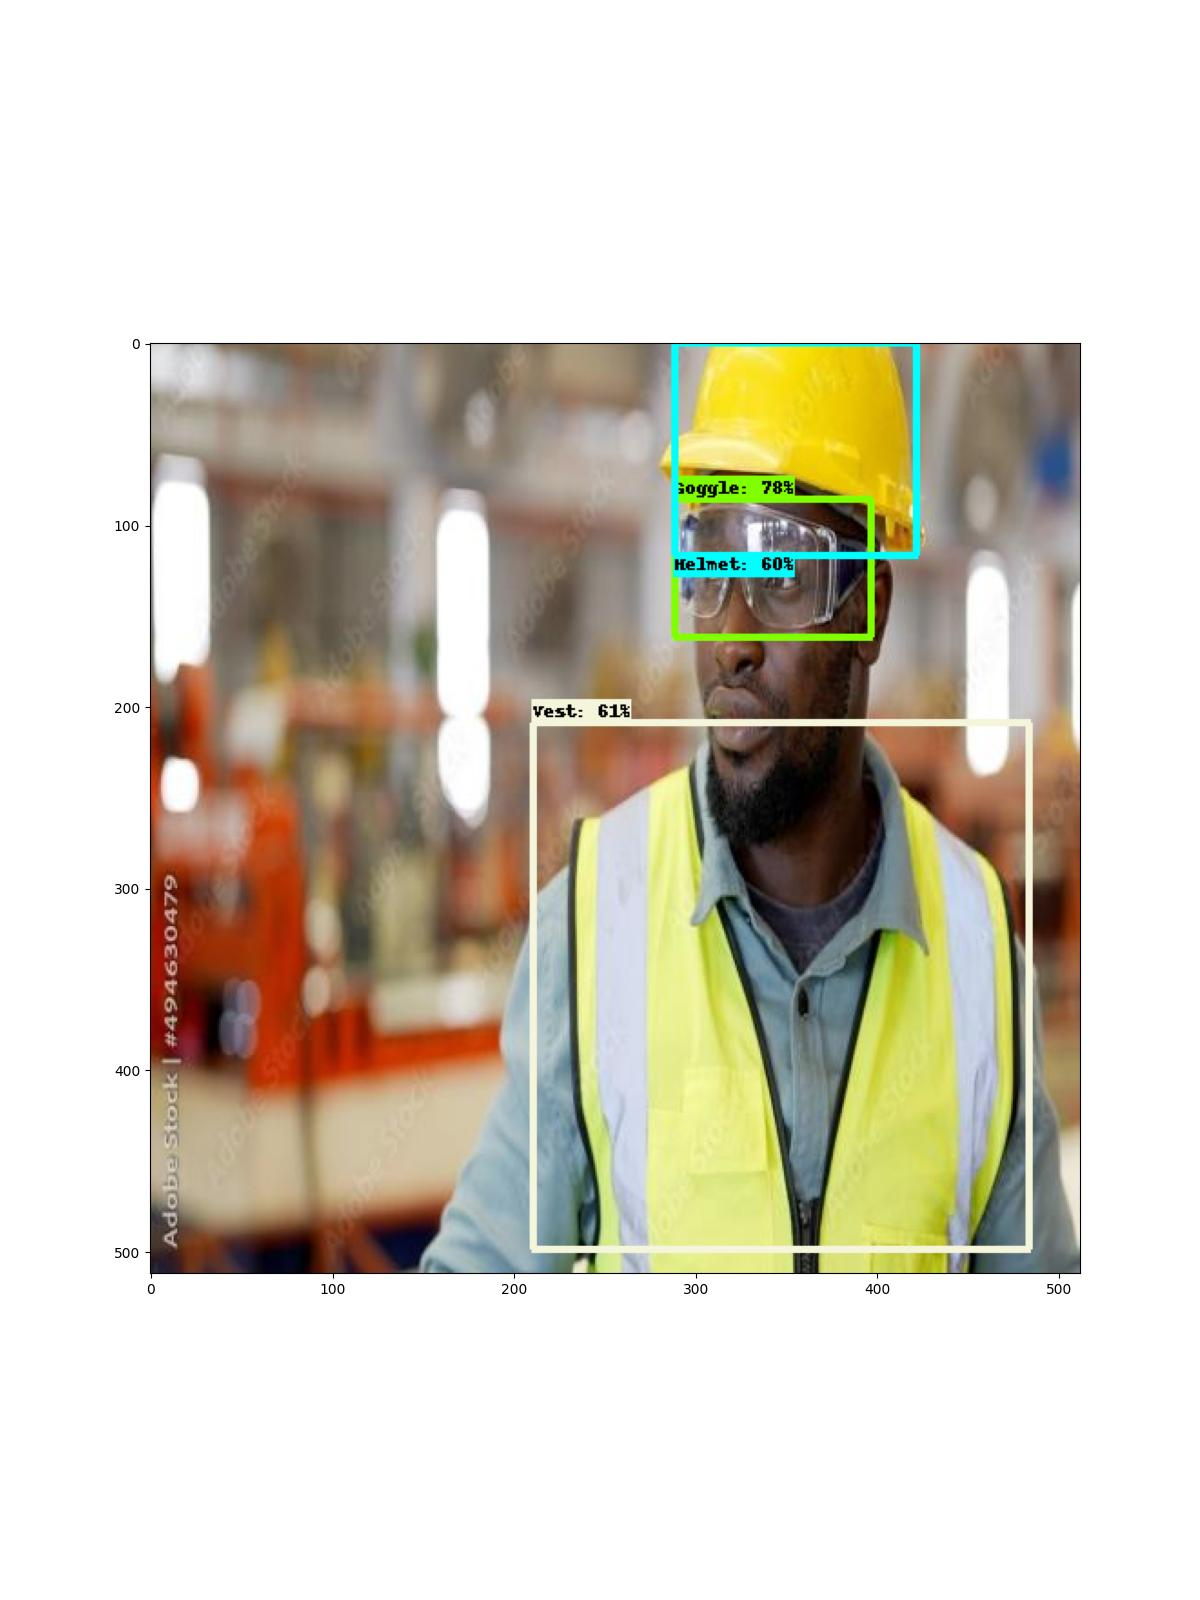

tp :  1
fp :  3
Precision: 0.25
Recall: 0.25
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Helmet', 'Helmet']
Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
/content/raw_test_image_output/2_jpg.rf.896bc
image_path :  /content/test_/ppe_0311_jpg.rf.4e27ff56c3222a9187c20a3a014fbcae.jpg


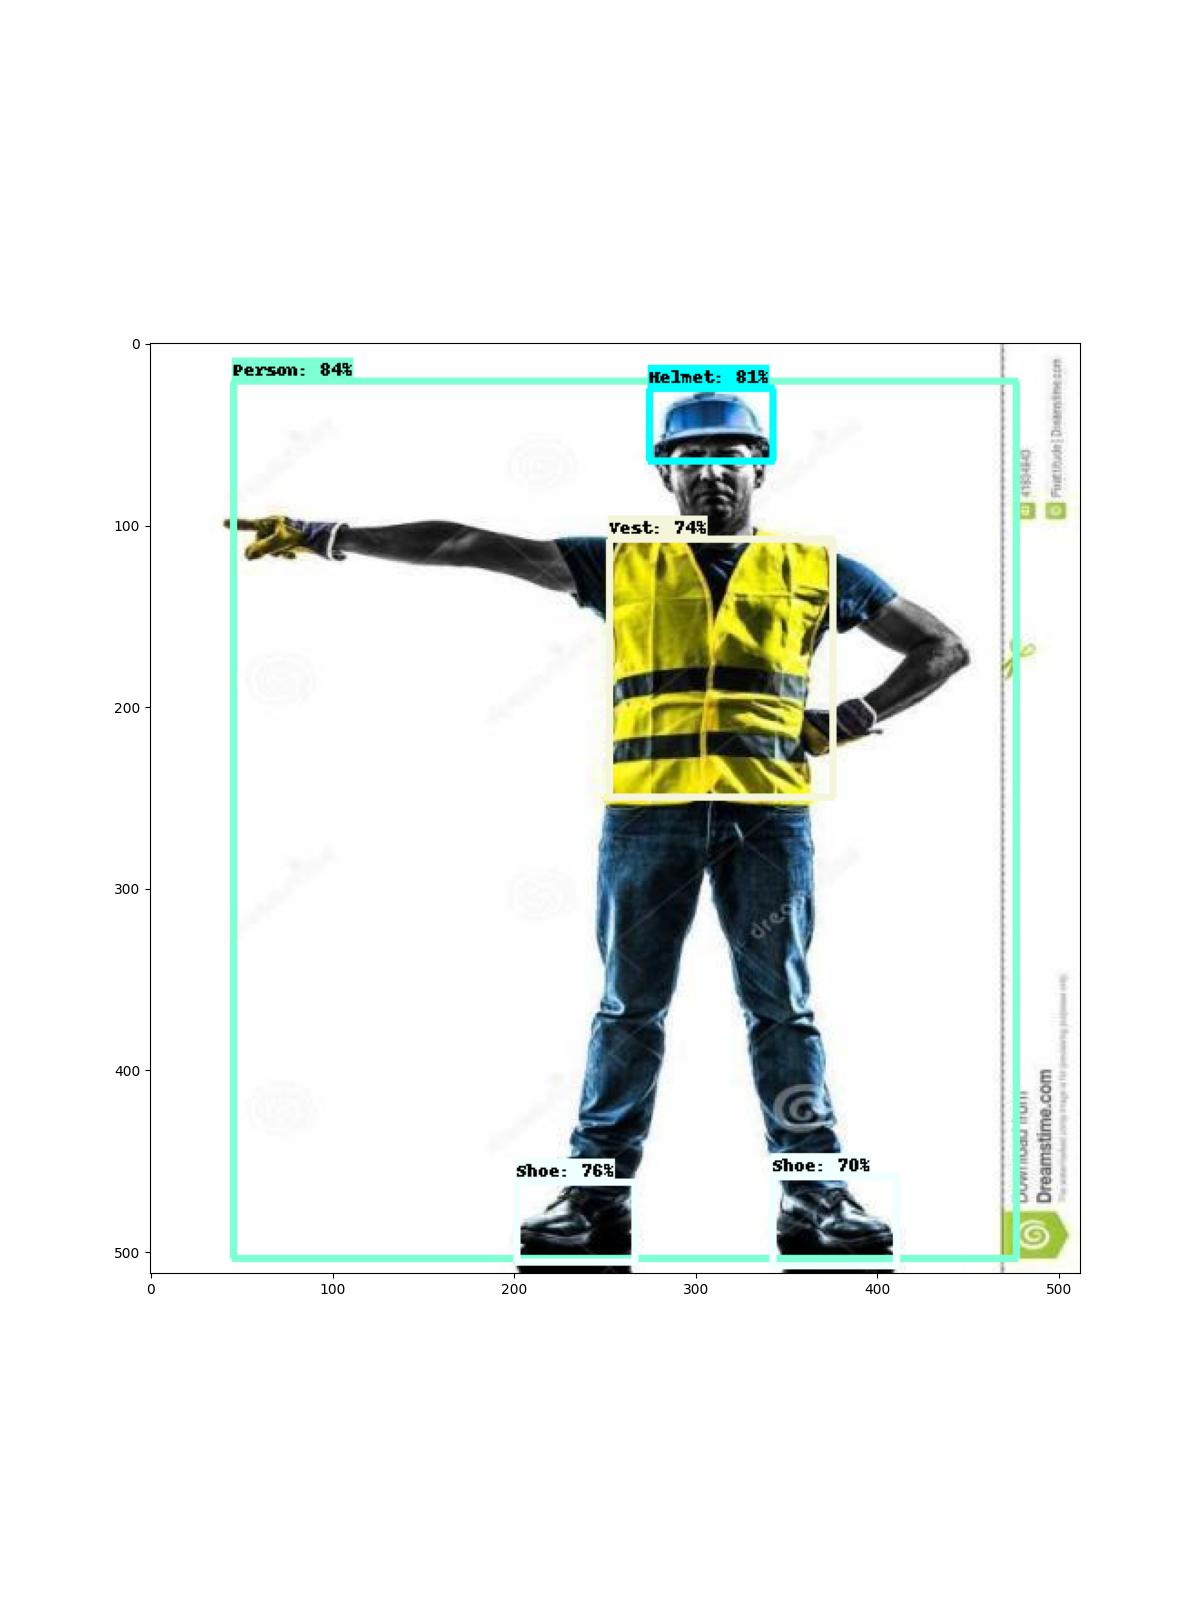

tp :  2
fp :  3
Precision: 0.4
Recall: 0.4
ground_truth_annotations_i :  ['Helmet', 'Person', 'Shoe', 'Shoe', 'Vest']
predicted_labels :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Shoe']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 2 0 0 0]
 [0 0 0 1 0]]
/content/raw_test_image_output/ppe_0311_jpg.r
image_path :  /content/test_/12_jpg.rf.e00e4d3631fd025b48b8dc6f2810036b.jpg


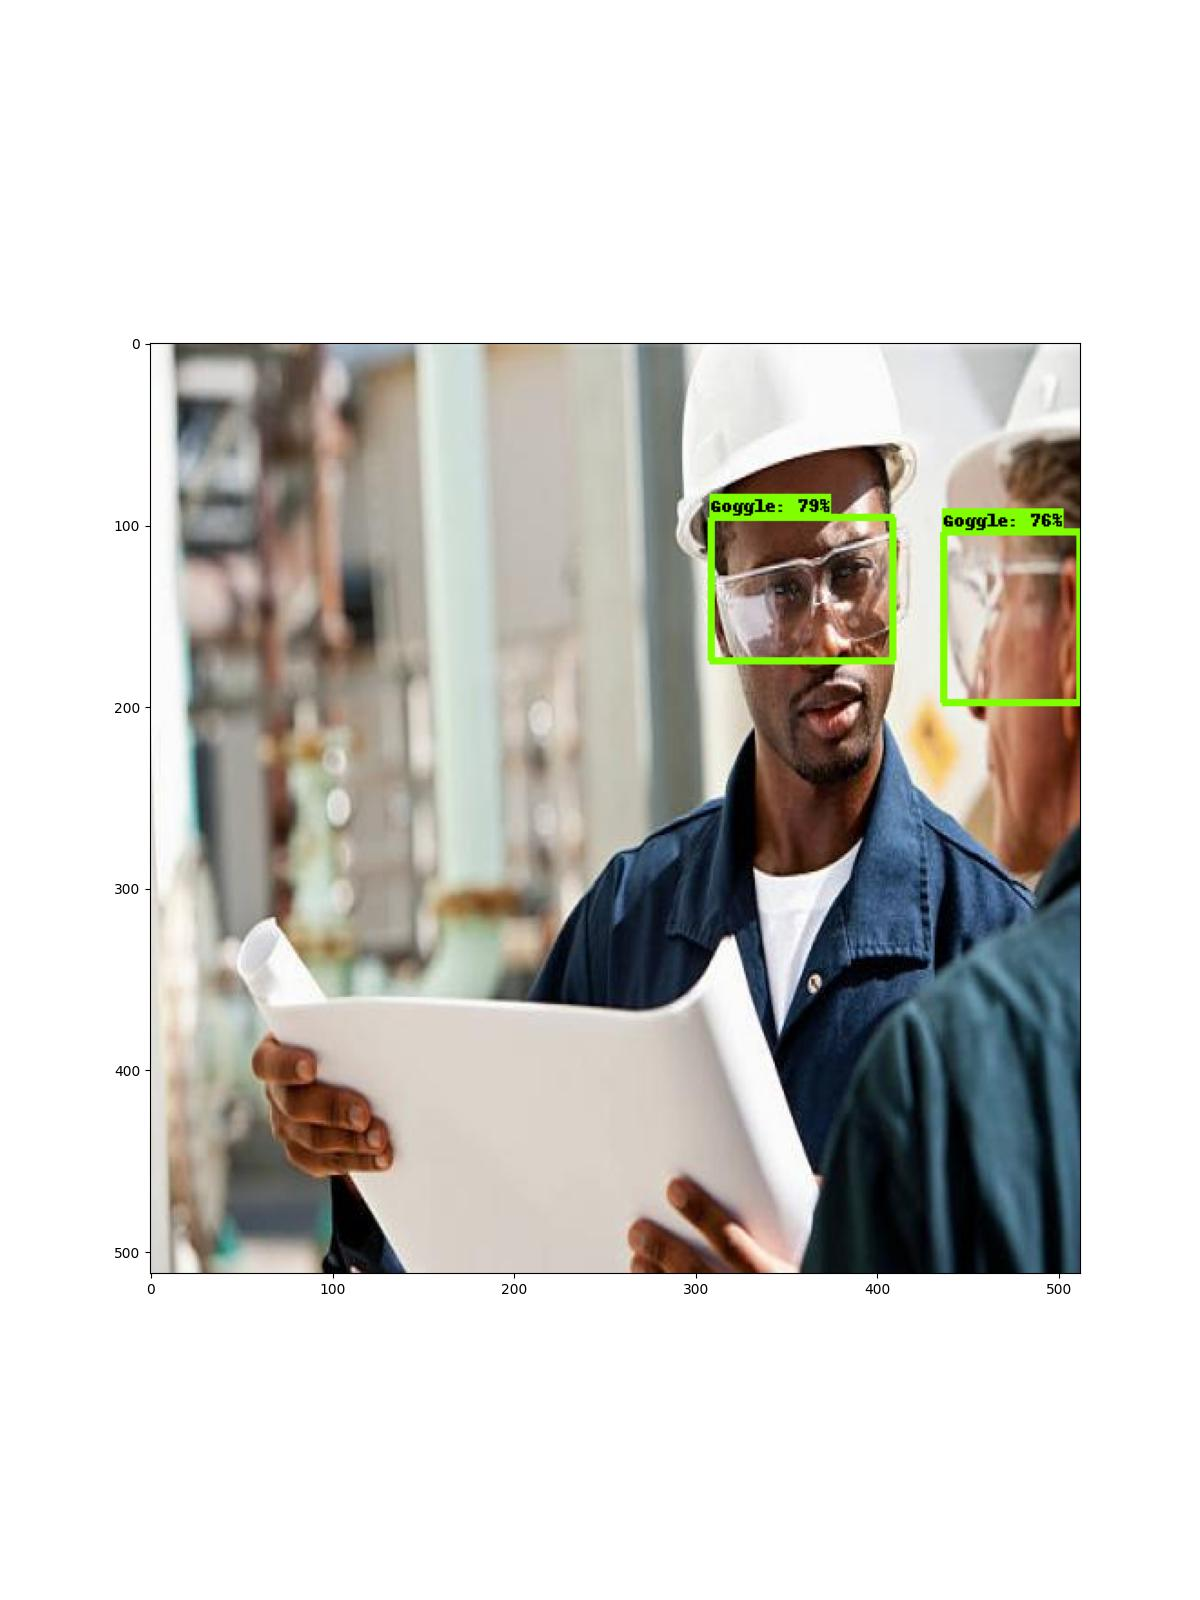

tp :  4
fp :  2
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person']
predicted_labels :  ['Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Shoe']
Confusion Matrix:
[[0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/12_jpg.rf.e00e
image_path :  /content/test_/33_jpeg.rf.6dea57186381fa297cf494bc3d2adb9a.jpg


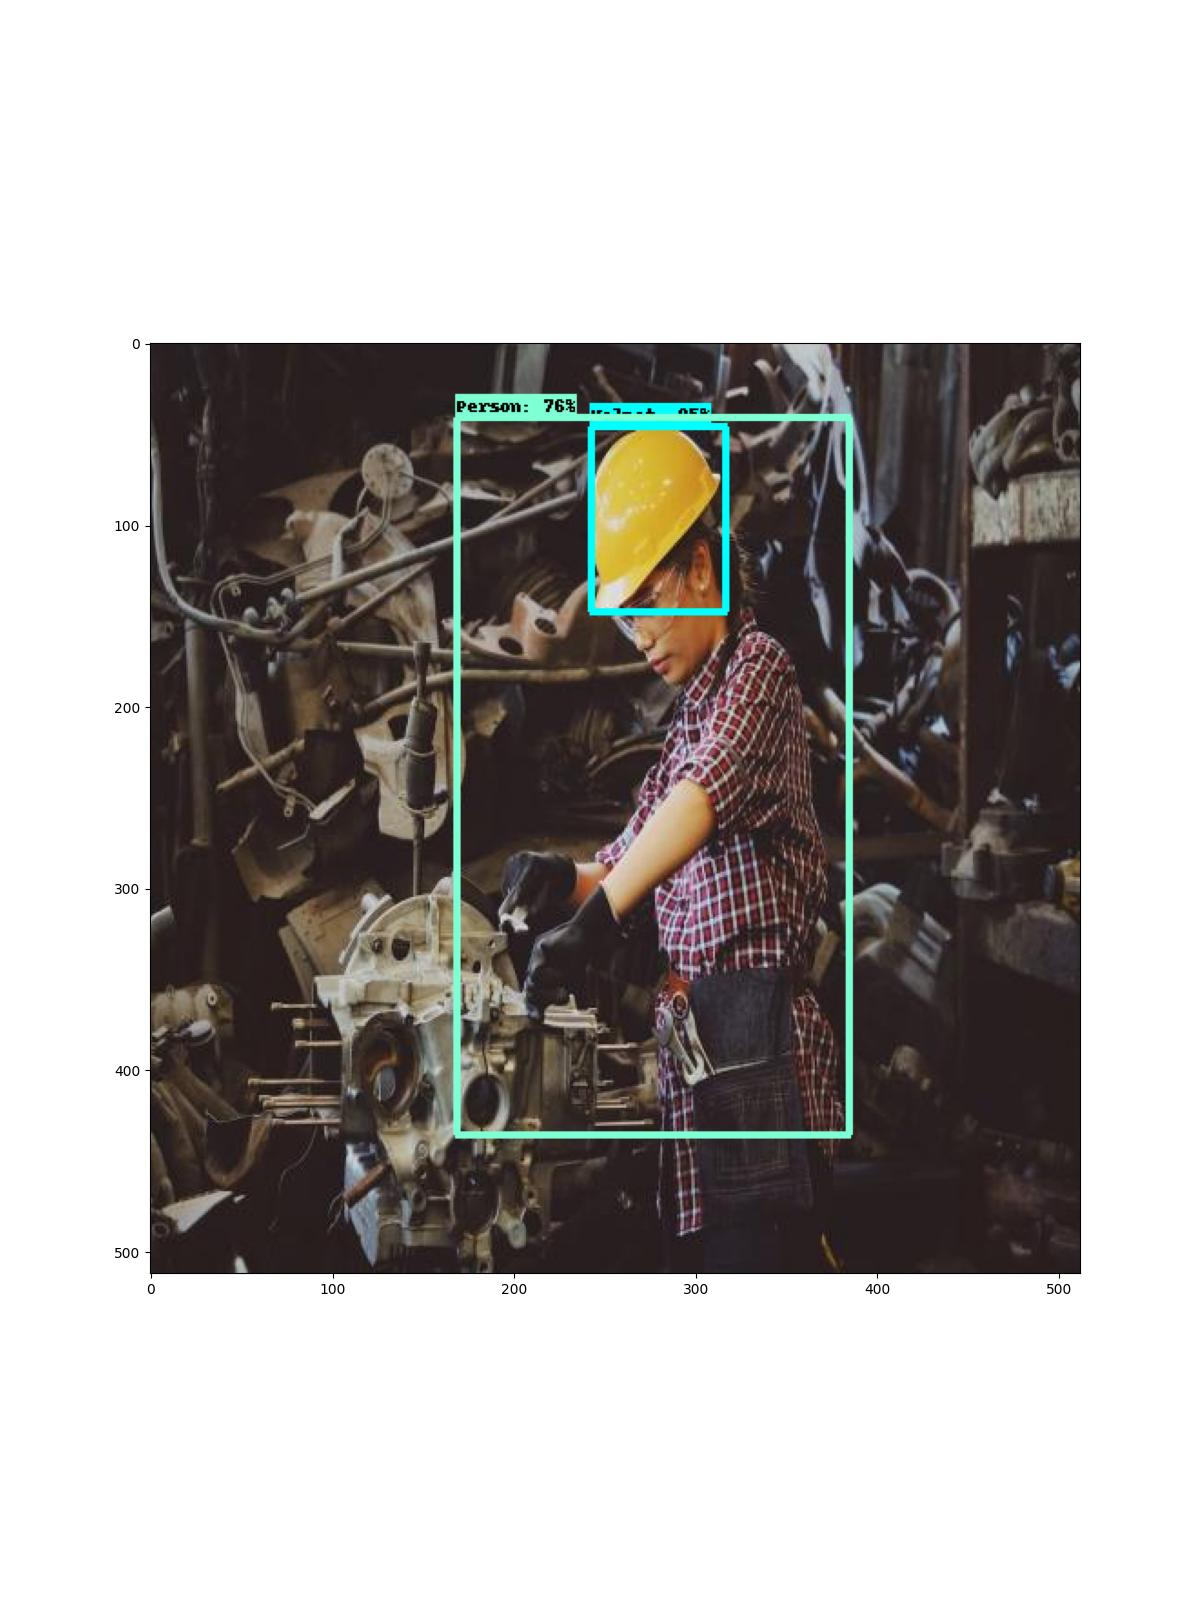

tp :  2
fp :  1
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Goggle', 'Helmet', 'Person']
predicted_labels :  ['Goggle', 'Helmet', 'Vest']
Confusion Matrix:
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
/content/raw_test_image_output/33_jpeg.rf.6de
image_path :  /content/test_/youtube-631_jpg.rf.ee10e765432ad41426333739df30b954.jpg


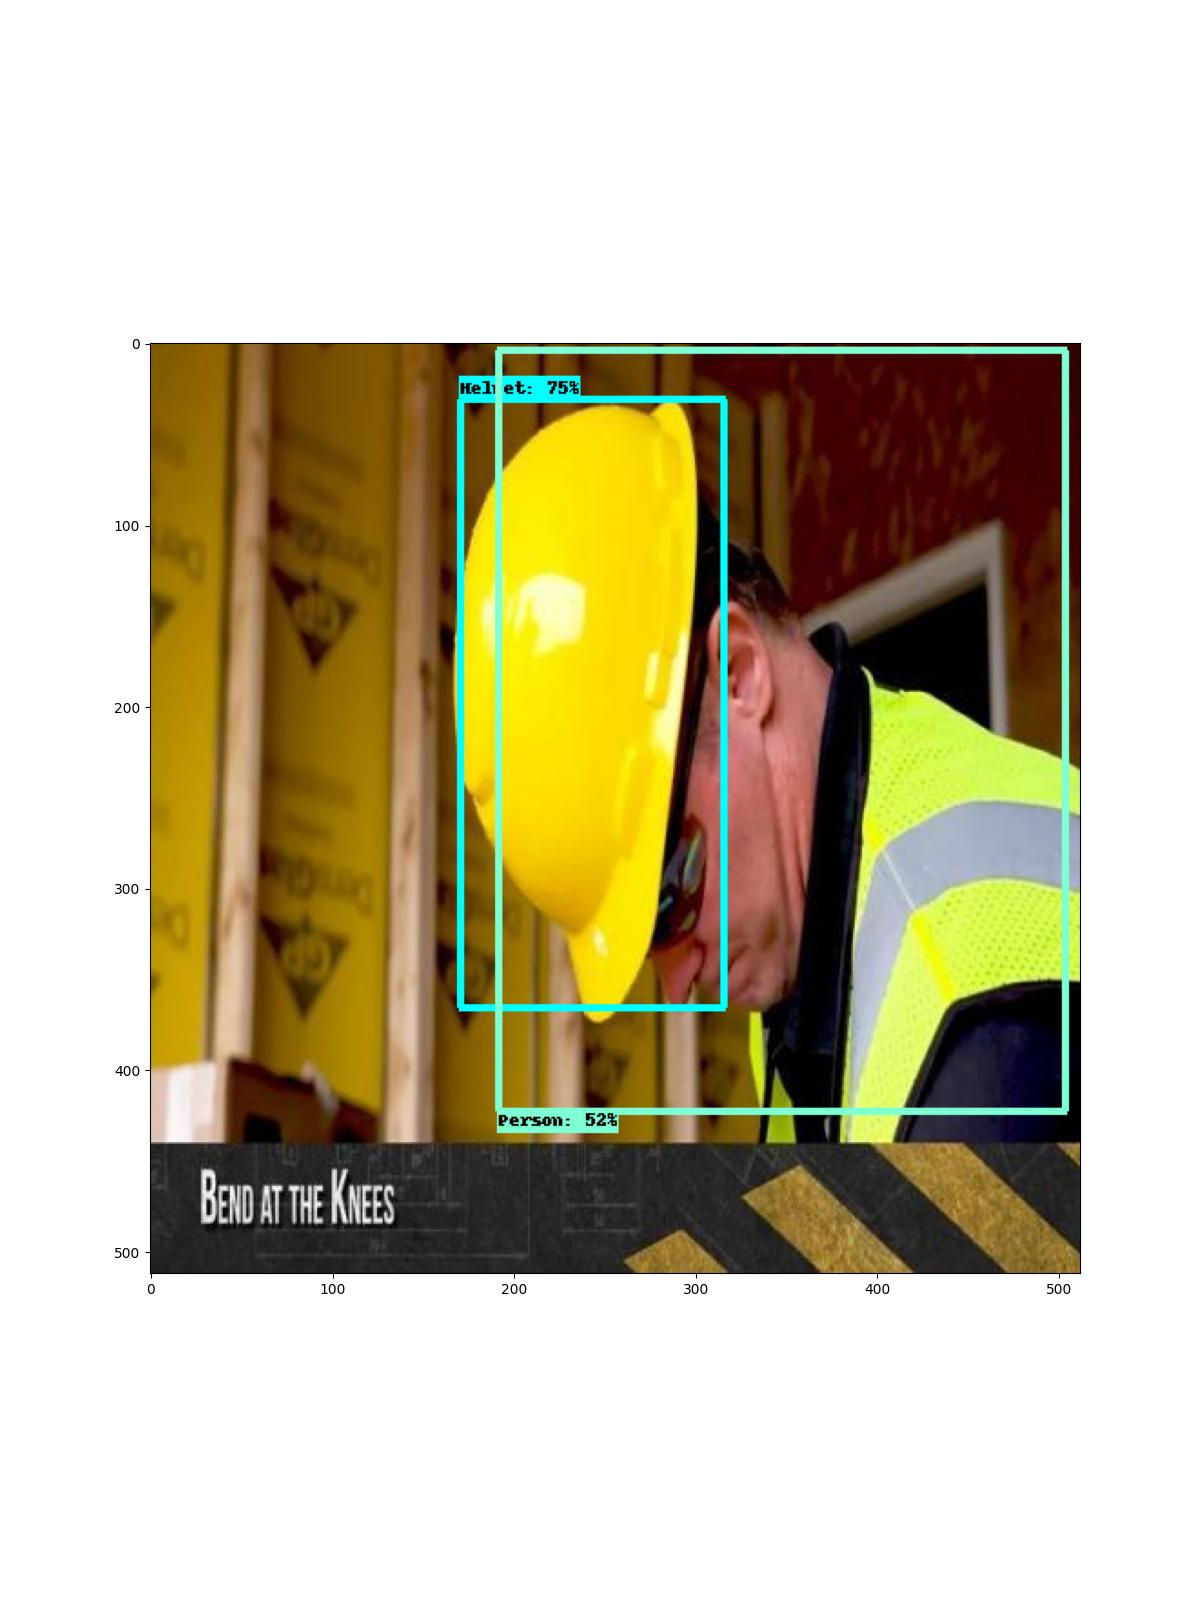

tp :  2
fp :  1
Precision: 0.6666666666666666
Recall: 0.6666666666666666
ground_truth_annotations_i :  ['Helmet', 'Person', 'Vest']
predicted_labels :  ['Person', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 1]]
/content/raw_test_image_output/youtube-631_jp
image_path :  /content/test_/11_webp.rf.b46e26181b1c5fa314962316c94059aa.jpg


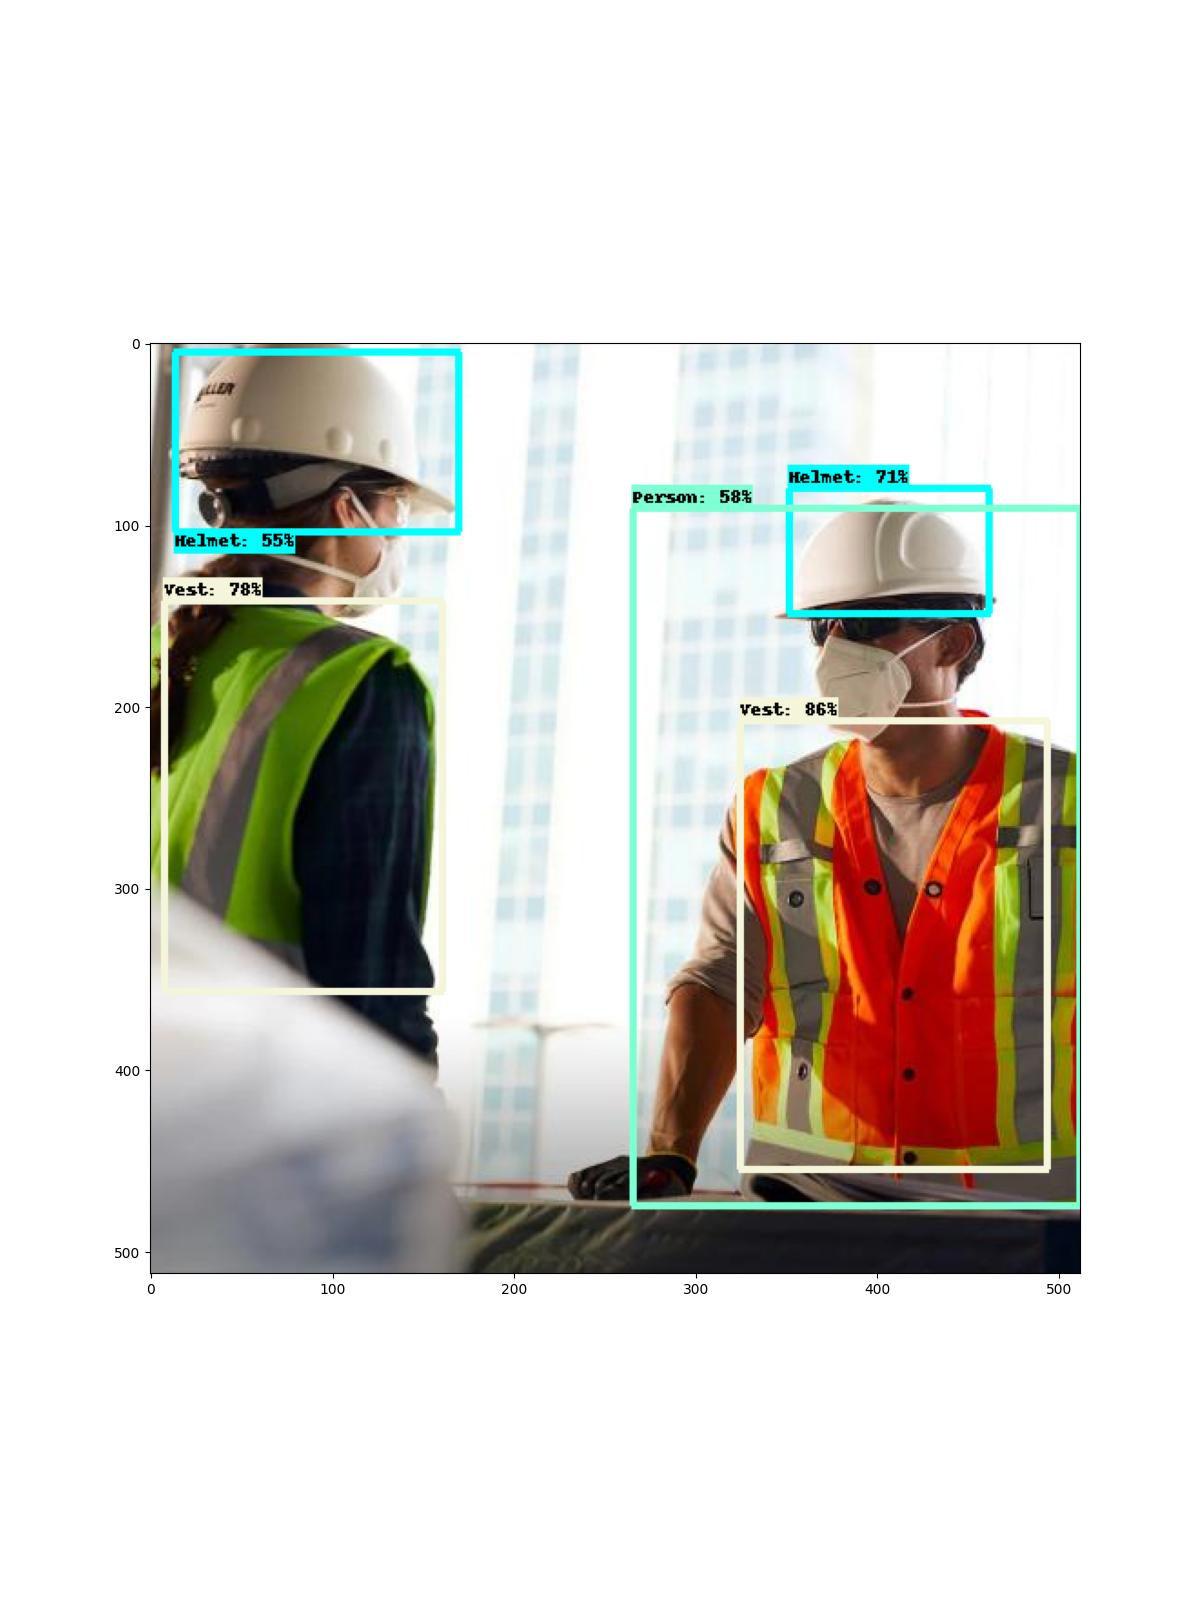

tp :  0
fp :  7
Precision: 0.0
Recall: 0.0
ground_truth_annotations_i :  ['Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Vest', 'Vest']
predicted_labels :  ['Goggle', 'Person', 'Shoe', 'Shoe', 'Shoe', 'Vest', 'Vest']
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 1 1 0]
 [0 0 0 2 0]
 [0 0 0 0 0]
 [0 0 0 0 2]]
/content/raw_test_image_output/11_webp.rf.b46
predicted_labels :  ['Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Person', 'Vest', 'Goggle', 'Person', 'Person', 'Shoe', 'Shoe', 'Goggle', 'Goggle', 'Goggle', 'Helmet', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Shoe', 'Shoe', 'Goggle', 'Vest', 'Goggle', 'Goggle', 'Goggle', 'Vest', 'Goggle', 'Goggle', 'Shoe', 'Vest', 'Shoe', 'Helmet', 'Person', 'Shoe', 'Helmet', 'Person', 'Person', 'Person', 'Person', 'Person', 'Shoe', 'Vest', 'Goggle', 'Vest', 'Vest', 'Goggle', 'Person', 'Shoe', 'Vest', 'Goggle', 'Goggle', 'Shoe', 'Vest', 'Goggl

In [39]:
# all image working- V1
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import Image as imgImage
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

ground_truth_annotations_l = []
predicted_labels_l = []
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    for obj in root.findall('.//object'):
        box = obj.find('bndbox')
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        boxes.append((ymin, xmin, ymax, xmax))

    return boxes

def get_ground_truth_annotations(xml_path):
    """Read ground truth annotations from XML file."""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    annotations = []
    for obj in root.findall('.//object'):
        name = obj.find('name').text
        annotations.append({'name': name})

    return annotations

images = os.listdir('/content/test_')
print(len(images))
isExist = os.path.exists('/content/raw_test_image_output')
if not isExist:
  os.mkdir('/content/raw_test_image_output')

confusion_matrix_data = {'true_labels': [], 'predicted_labels': []}

for img in images:
    image_path = '/content/test_/' + img
    xml_path = '/content/test_/' + img.replace('.jpg', '.xml')  # Replace with your ground truth annotations path

    try:
      if image_path[-4:]=='.jpg':
        print('image_path : ',image_path)
        raw_output_image_path = f'/content/raw_test_image_output/{img}'
        pil_img = imgImage(filename=raw_output_image_path)
        display(pil_img)
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
        detections, predictions_dict, shapes = detect_fn(input_tensor)

        detection_scores = detections['detection_scores'][0].numpy()
        # detection_classes = detections['detection_classes'][0].numpy() + 1
        detection_classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)

        pred_bbox = []
        for i in range(len(detections['detection_boxes'][0].numpy())):
          detection_bbox = detections['detection_boxes'][0][i].numpy()*512
          pred_bbox.append(detection_bbox.astype(int))
        pred_bbox = np.array(pred_bbox)

        my_list = ['apple', 'banana', 'orange']
        elements = [my_list[i-1] for i in idx]
        print(elements)
        # print('pred_bbox : ',pred_bbox)
        # print('detection_scores : ',detection_scores)
        # print('detection_classes : ',detection_classes)


        label_id_offset = 1
        image_np_with_detections = image_np.copy()
        # Get ground truth annotations
        ground_truth_annotations = get_ground_truth_annotations(xml_path)
        # print('ground_truth_annotations: ',ground_truth_annotations)
        ground_truth_bboxes = parse_xml(xml_path)
        # print('ground_truth_bboxes: ',ground_truth_bboxes)
        # Flatten the ground truth and predicted labels for the confusion matrix
        true_labels = [annotation['name'] for annotation in ground_truth_annotations]
        predicted_labels = [category_index[int(class_id)]['name'] for class_id in detection_classes]
        # print('predicted_labels : ',predicted_labels)
        # Update the confusion matrix data
        confusion_matrix_data['true_labels'].extend(true_labels)
        # print(true_labels)
        confusion_matrix_data['predicted_labels'].extend(predicted_labels)
        # print(predicted_labels)

        # finding best bounding box
        # Initialize lists to store the best bounding boxes and their IoU scores

        best_boxes = []

        best_ious = []
        best_index = []
        # Find the best bounding box for each true box

        for true_box in ground_truth_bboxes:

          max_iou = 0

          best_box = None

          for candidate_box in pred_bbox:

              iou = calculate_iou(true_box, candidate_box)

              if iou > max_iou:

                  max_iou = iou

                  best_box = candidate_box
                  index = np.where((pred_bbox == best_box).all(axis=1))[0][0]

          best_index.append(index)
          best_boxes.append(best_box)
          best_ious.append(max_iou)

        # print('oo',best_boxes,best_ious,best_index)
        pred_bbox = np.array(pred_bbox)[best_index]
        predicted_labels = np.array(predicted_labels)[best_index]
        detection_scores = np.array(detection_scores)[best_index]
        # print('detection_scores : ',predicted_labels)
        precision, recall = calculate_precision_recall(np.array(ground_truth_bboxes), np.array(ground_truth_annotations), np.array(pred_bbox), np.array(predicted_labels), np.array(detection_scores))

        print("Precision:", precision)
        print("Recall:", recall)

        ground_truth_annotations_i = []
        # adding label for confusion matrix
        for id in range(len(ground_truth_annotations)):
          ground_truth_annotations_i.append(ground_truth_annotations[id]['name'])


        # print('ground_truth_annotations_i : ',ground_truth_annotations_i)
        # print('predicted_labels : ',predicted_labels)
        l = ['Goggle','Helmet','Person','Shoe','Vest']
        ground_truth_annotations_i = sorted(ground_truth_annotations_i)
        predicted_labels = sorted(predicted_labels)
        print('ground_truth_annotations_i : ',ground_truth_annotations_i)
        print('predicted_labels : ',predicted_labels)
        conf_matrix = confusion_matrix(ground_truth_annotations_i, predicted_labels,labels=l)
        # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=l)
        # disp.plot()
        # plt.show()
        print("Confusion Matrix:")
        print(conf_matrix)



        # adding label for confusion matrix
        for id in range(len(ground_truth_annotations)):
          ground_truth_annotations_l.append(ground_truth_annotations[id]['name'])

        predicted_labels_l.extend(predicted_labels)

        label_id_offset = 1
        viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'][0].numpy(),
              (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
              detections['detection_scores'][0].numpy(),
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=200,
              min_score_thresh=.5,
              agnostic_mode=False,
        )

        plt.figure(figsize=(12,16))
        plt.imshow(image_np_with_detections)
        plt.show()
        save_path = f'/content/raw_test_image_output/{img[:14]}'
        print(save_path)
        plt.savefig(f'/content/raw_test_image_output/{img}')




    except Exception as inst:
        print(inst)


print('predicted_labels : ',predicted_labels_l)
print('ground_truth_annotations_l : ',ground_truth_annotations_l)
conf_matrix = confusion_matrix(ground_truth_annotations_l, predicted_labels_l)
print("Confusion Matrix:")
print(conf_matrix)

In [31]:
!zip -r /content/raw_test_image_output.zip /content/raw_test_image_output/
%cp /content/raw_test_image_output.zip /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/


updating: content/raw_test_image_output/ (stored 0%)
updating: content/raw_test_image_output/4_webp.rf.bbb3829e7a29949f802c5af5db00b754.jpg (deflated 18%)
updating: content/raw_test_image_output/34_jpg.rf.d7b9c8d25c2c9e83d003263f62265c3f.jpg (deflated 25%)
updating: content/raw_test_image_output/16_jpg.rf.3612742c5d30c5e891a49eb988d3299a.jpg (deflated 16%)
updating: content/raw_test_image_output/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.jpg (deflated 30%)
updating: content/raw_test_image_output/01FWJD7JTS1E8YVXVSWZAFNVAA_jpeg_jpg.rf.1253fe66374565fa55aa9ff39f97562a.jpg (deflated 15%)
updating: content/raw_test_image_output/00107_jpg.rf.a698618bf501c40e53871f6a4feb5eb5.jpg (deflated 31%)
updating: content/raw_test_image_output/27_jpg.rf.edee0b2b52736eb064ab71d75d264a89.jpg (deflated 21%)
updating: content/raw_test_image_output/01FWJD7JQDGP196BREGG8EKRX9_jpeg_jpg.rf.74bd31101a8aa9887f47bf644df259ec.jpg (deflated 24%)
updating: content/raw_test_image_output/15_jpg.rf.b2458f4fa77072fda0c1

In [32]:
!unzip /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/raw_test_image_output.zip -d  /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/


Archive:  /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/raw_test_image_output.zip
   creating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/4_webp.rf.bbb3829e7a29949f802c5af5db00b754.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/34_jpg.rf.d7b9c8d25c2c9e83d003263f62265c3f.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/16_jpg.rf.3612742c5d30c5e891a49eb988d3299a.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/21_jpg.rf.7110535ac4cc48bbb4a0f873230c2b06.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/content/raw_test_image_output/01FWJD7JTS1E8YVXVSWZAFNVAA_jpeg_jpg.rf.1253fe66374565fa55aa9ff39f97562a.jpg

In [33]:

!unzip /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc_V9.4.zip -d  /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000119458_jpg.rf.828c0688f4b21b11a7269b63a3b78546.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000119458_jpg.rf.828c0688f4b21b11a7269b63a3b78546.xml  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000119502_jpg.rf.09bfcd210e3b4df754b538b6e05e814b.jpg  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000119502_jpg.rf.09bfcd210e3b4df754b538b6e05e814b.xml  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000120070_jpg.rf.b28b0b2e92e205e0ca15a3b1fc5bf3c6.xml  
  inflating: /content/drive/MyDrive/temp_ppe/V9.4_mosaic_v8balanced_xml2TF/PPEDEV02.v1i.voc/train/000000120247_jpg.rf.ac55e55334977d196eb98e7f657ae0d9.xml  
  infla

## video inference

In [ ]:
print('Working!')

Working!


In [ ]:
# version 2 -

import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from object_detection.utils import visualization_utils as viz_utils

# Assume you have the following functions and variables defined:
# detect_fn = your_detection_function()
# category_index = your_category_index_definition()

isExist = os.path.exists('/content/saved_img')
if not isExist:
    os.mkdir('/content/saved_img')

Video_path = '/content/output.avi'
output_path = '/content/op.mp4'

cap = cv2.VideoCapture(Video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))
print('FPS: ', fps)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
i = 0

while cap.isOpened():
    ret, image_np = cap.read()
    if not ret:
        break
    i += 1
    try:
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
        detections, predictions_dict, shapes = detect_fn(input_tensor)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        # Visualize boxes and labels on the image
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.3,
            agnostic_mode=False,
        )

        # Save the processed frame
        save_path = f'/content/saved_img/{i}.png'
        cv2.imwrite(save_path, cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2BGR))

        out.write(image_np_with_detections)
        print('i : ',i)
    except Exception as inst:
        print(inst)

cap.release()
out.release()
cv2.destroyAllWindows()


FPS:  15
i :  1
i :  2
i :  3
i :  4
i :  5
i :  6
i :  7
i :  8
i :  9
i :  10
i :  11
i :  12
i :  13
i :  14
i :  15
i :  16
i :  17
i :  18
i :  19
i :  20
i :  21
i :  22
i :  23
i :  24
i :  25
i :  26
i :  27
i :  28
i :  29
i :  30
i :  31
i :  32
i :  33
i :  34
i :  35
i :  36
i :  37
i :  38
i :  39
i :  40
i :  41
i :  42
i :  43
i :  44
i :  45
i :  46
i :  47
i :  48
i :  49
i :  50
i :  51
i :  52
i :  53
i :  54
i :  55
i :  56
i :  57
i :  58
i :  59
i :  60
i :  61
i :  62
i :  63
i :  64
i :  65
i :  66
i :  67
i :  68
i :  69
i :  70
i :  71
i :  72
i :  73
i :  74
i :  75
i :  76
i :  77
i :  78
i :  79
i :  80
i :  81
i :  82
i :  83
i :  84
i :  85
i :  86
i :  87
i :  88
i :  89
i :  90
i :  91
i :  92
i :  93
i :  94
i :  95
i :  96
i :  97
i :  98
i :  99
i :  100
i :  101
i :  102
i :  103
i :  104
i :  105
i :  106
i :  107
i :  108
i :  109
i :  110
i :  111
i :  112
i :  113
i :  114
i :  115
i :  116
i :  117
i :  118
i :  119
i :  120
i :  121
i :  122
i

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/op.mp4"

# Compressed video path
compressed_path = "/content/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# #run detector on test image
# #it takes a little longer on the first run and then runs at normal speed.
# import random
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt

# TEST_IMAGE_PATHS = glob.glob('/content/test/test/*.jpg')
# # image_path = random.choice(TEST_IMAGE_PATHS)
# images = os.listdir('/content/test/test')
# print(len(images))
# isExist = os.path.exists('/content/saved_img')
# if not isExist:
#   os.mkdir('/content/saved_img')
# for img in images:
#   image_path = '/content/test/test/'+img
#   try:
#     image_np = load_image_into_numpy_array(image_path)
#     input_tensor = tf.convert_to_tensor(
#         np.expand_dims(image_np, 0), dtype=tf.float32)
#     detections, predictions_dict, shapes = detect_fn(input_tensor)

#     label_id_offset = 1
#     image_np_with_detections = image_np.copy()

#     viz_utils.visualize_boxes_and_labels_on_image_array(
#           image_np_with_detections,
#           detections['detection_boxes'][0].numpy(),
#           (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
#           detections['detection_scores'][0].numpy(),
#           category_index,
#           use_normalized_coordinates=True,
#           max_boxes_to_draw=200,
#           min_score_thresh=.5,
#           agnostic_mode=False,
#     )

#     plt.figure(figsize=(12,16))
#     plt.imshow(image_np_with_detections)
#     plt.show()
#     save_path = f'/content/saved_img/{img[:14]}'
#     # plt.savefig(save_path)
#     print(save_path)
#     plt.savefig(f'/content/saved_img/{img}')
#   except Exception as inst:
#     print(inst)
#   # Things to try:
#   # Flip horizontally
#   # image_np = np.fliplr(image_np).copy()

#   # Convert image to grayscale
#   # image_np = np.tile(
#   #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)



FileNotFoundError: [Errno 2] No such file or directory: '/content/test/test'

In [ ]:
# video code
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed.
import numpy as np
import tensorflow as tf
import cv2
import time
import os
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt




isExist = os.path.exists('/content/saved_img')
if not isExist:
  os.mkdir('/content/saved_img')

Video_path = '/content/ins.mp4'
output_path = '/content/op.mp4'


cap = cv2.VideoCapture(Video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))
print('FPS: ',fps)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
i=0
while cap.isOpened():
    ret, image_np = cap.read()
    if not ret:
        break
    i +=1
    try:
      # image_np = load_image_into_numpy_array(frame_image)
      # image_np = frame_image
      input_tensor = tf.convert_to_tensor(
          np.expand_dims(image_np, 0), dtype=tf.float32)
      detections, predictions_dict, shapes = detect_fn(input_tensor)

      label_id_offset = 1
      image_np_with_detections = image_np.copy()

      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.5,
            agnostic_mode=False,
      )

      plt.figure(figsize=(12,16))
      plt.imshow(image_np_with_detections)
      out.write(image_np_with_detections)
      # plt.show()
      save_path = f'/content/saved_img/{i}'
      # print(save_path)
      plt.savefig(f'/content/saved_img/{i}')
      plt.close()
    except Exception as inst:
      print(inst)

cap.release()
out.release()
cv2.destroyAllWindows()







'''



# for img in images:
cap = cv2.VideoCapture(Video_path)
i=0
while True:
    i +=1
    ok, frame_image = cap.read()
    if not ok:
        break

    # model_interpreter_start_time = time.time()
    # resize_img = cv2.resize(frame_image, (512, 512), interpolation=cv2.INTER_CUBIC)
    # reshape_image = frame_image.reshape(512,512, 3)
    # image_np_expanded = np.expand_dims(reshape_image, axis=0)
    # image_np_expanded = image_np_expanded.astype('uint8')  # float32
  # image_path = '/content/test/test/'+img
    try:
      # image_np = load_image_into_numpy_array(frame_image)
      image_np = frame_image
      input_tensor = tf.convert_to_tensor(
          np.expand_dims(image_np, 0), dtype=tf.float32)
      detections, predictions_dict, shapes = detect_fn(input_tensor)

      label_id_offset = 1
      image_np_with_detections = image_np.copy()

      viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.5,
            agnostic_mode=False,
      )

      plt.figure(figsize=(12,16))
      plt.imshow(image_np_with_detections)
      plt.show()
      save_path = f'/content/saved_img/{i}'
      print(save_path)
      plt.savefig(f'/content/saved_img/{i}')
    except Exception as inst:
      print(inst)
  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
'''


FPS:  30


"\n\n\n\n# for img in images:\ncap = cv2.VideoCapture(Video_path)\ni=0\nwhile True:\n    i +=1\n    ok, frame_image = cap.read()\n    if not ok:\n        break\n\n    # model_interpreter_start_time = time.time()\n    # resize_img = cv2.resize(frame_image, (512, 512), interpolation=cv2.INTER_CUBIC)\n    # reshape_image = frame_image.reshape(512,512, 3)\n    # image_np_expanded = np.expand_dims(reshape_image, axis=0)\n    # image_np_expanded = image_np_expanded.astype('uint8')  # float32\n  # image_path = '/content/test/test/'+img\n    try:\n      # image_np = load_image_into_numpy_array(frame_image)\n      image_np = frame_image\n      input_tensor = tf.convert_to_tensor(\n          np.expand_dims(image_np, 0), dtype=tf.float32)\n      detections, predictions_dict, shapes = detect_fn(input_tensor)\n\n      label_id_offset = 1\n      image_np_with_detections = image_np.copy()\n\n      viz_utils.visualize_boxes_and_labels_on_image_array(\n            image_np_with_detections,\n           

In [ ]:
matplotlib.pyplot.close()

In [ ]:
import time
time.sleep(480)
print('working')

working


In [ ]:
# Show video
mp4 = open('/content/output.avi','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# version 3

import numpy as np
import tensorflow as tf
import cv2
import os
from object_detection.utils import visualization_utils as viz_utils

# Assume you have the following functions and variables defined:
# detect_fn = your_detection_function()
# category_index = your_category_index_definition()

isExist = os.path.exists('/content/saved_img')
if not isExist:
    os.mkdir('/content/saved_img')

Video_path = '/content/ins.mp4'
output_path = '/content/op.mp4'

cap = cv2.VideoCapture(Video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))
print('FPS: ', fps)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
i = 0

while cap.isOpened():
    ret, image_np = cap.read()
    if not ret:
        break
    i += 1
    try:
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
        detections, predictions_dict, shapes = detect_fn(input_tensor)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        # Visualize boxes and labels on the image
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.5,
            agnostic_mode=False,
        )

        # Save the processed frame
        save_path = f'/content/saved_img/{i}.png'
        cv2.imwrite(save_path, cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2BGR))

        out.write(image_np_with_detections.astype('uint8'))

    except Exception as inst:
        print(inst)

cap.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
# Version 1

import numpy as np
import tensorflow as tf
import cv2
import time
import os
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Assume you have the following functions and variables defined:
# detect_fn = your_detection_function()
# category_index = your_category_index_definition()

isExist = os.path.exists('/content/saved_img')
if not isExist:
    os.mkdir('/content/saved_img')

Video_path = '/content/output.avi'
output_path = '/content/op.mp4'

cap = cv2.VideoCapture(Video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(5))
print('FPS: ', fps)
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
i = 0

while cap.isOpened():
    ret, image_np = cap.read()
    if not ret:
        break
    i += 1
    print('i : ',i)
    try:
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(image_np, 0), dtype=tf.float32)
        detections, predictions_dict, shapes = detect_fn(input_tensor)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        # Visualize boxes and labels on the image
        # (Make sure detect_fn, category_index, and viz_utils are correctly defined)
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.5,
            agnostic_mode=False,
        )

        # Save the processed frame
        save_path = f'/content/saved_img/{i}.png'
        cv2.imwrite(save_path, cv2.cvtColor(image_np_with_detections, cv2.COLOR_RGB2BGR))

        out.write(image_np_with_detections)

    except Exception as inst:
        print(inst)

cap.release()
out.release()
cv2.destroyAllWindows()


FPS:  15
i :  1
i :  2
i :  3
i :  4
i :  5
i :  6
i :  7
i :  8
i :  9
i :  10
i :  11
i :  12
i :  13
i :  14
i :  15
i :  16
i :  17
i :  18
i :  19
i :  20
i :  21
i :  22
i :  23
i :  24
i :  25
i :  26
i :  27
i :  28
i :  29
i :  30
i :  31
i :  32
i :  33
i :  34
i :  35
i :  36
i :  37
i :  38
i :  39
i :  40
i :  41
i :  42
i :  43
i :  44
i :  45
i :  46
i :  47
i :  48
i :  49
i :  50
i :  51
i :  52
i :  53
i :  54
i :  55
i :  56
i :  57
i :  58
i :  59
i :  60
i :  61
i :  62
i :  63
i :  64
i :  65
i :  66
i :  67
i :  68
i :  69
i :  70
i :  71
i :  72
i :  73
i :  74
i :  75
i :  76
i :  77
i :  78
i :  79
i :  80
i :  81
i :  82
i :  83
i :  84
i :  85
i :  86
i :  87
i :  88
i :  89
i :  90
i :  91
i :  92
i :  93
i :  94
i :  95
i :  96
i :  97
i :  98
i :  99
i :  100
i :  101
i :  102
i :  103
i :  104
i :  105
i :  106
i :  107
i :  108
i :  109
i :  110
i :  111
i :  112
i :  113
i :  114
i :  115
i :  116
i :  117
i :  118
i :  119
i :  120
i :  121
i :  122
i

In [ ]:
%%capture

!zip -r /content/saved_img.zip /content/saved_img/

%cp /content/saved_img.zip /content/drive/MyDrive/temp_ppe/temp_output


  adding: content/saved_img/ (stored 0%)
  adding: content/saved_img/124.png (deflated 5%)
  adding: content/saved_img/286.png (deflated 5%)
  adding: content/saved_img/796.png (deflated 5%)
  adding: content/saved_img/233.png (deflated 6%)
  adding: content/saved_img/294.png (deflated 5%)
  adding: content/saved_img/117.png (deflated 5%)
  adding: content/saved_img/588.png (deflated 5%)
  adding: content/saved_img/358.png (deflated 5%)
  adding: content/saved_img/296.png (deflated 5%)
  adding: content/saved_img/690.png (deflated 5%)
  adding: content/saved_img/155.png (deflated 6%)
  adding: content/saved_img/315.png (deflated 5%)
  adding: content/saved_img/731.png (deflated 5%)
  adding: content/saved_img/602.png (deflated 5%)
  adding: content/saved_img/46.png (deflated 6%)
  adding: content/saved_img/420.png (deflated 5%)
  adding: content/saved_img/800.png (deflated 5%)
  adding: content/saved_img/27.png (deflated 6%)
  adding: content/saved_img/202.png (deflated 5%)
  adding: c

In [ ]:
# # remove dir with file

# import shutil
# shutil.rmtree('/content/saved_img')